In [54]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy.ma as ma
import glob
from collections import namedtuple, OrderedDict
import netCDF4 as nc
import os
import scipy
import scipy.io as sio
from scipy import interpolate, signal
from pyproj import Proj,transform
import sys
sys.path.append('/ocean/ssahu/CANYONS/wcvi/grid/')
from bathy_common import *
from matplotlib import path
from salishsea_tools import viz_tools
import xarray as xr
from salishsea_tools import nc_tools
import scipy.io as sio
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import cmocean as cmo
import matplotlib.gridspec as gridspec
%matplotlib inline
from scipy.io import loadmat
from scipy.interpolate import griddata
from dateutil.parser import parse
from salishsea_tools import geo_tools, viz_tools, tidetools, nc_tools
import gsw
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Ellipse
import matplotlib as mpl

import seaborn as sns
from windrose import plot_windrose
from windrose import WindroseAxes


from dateutil        import parser
from datetime import datetime

import numpy.ma as ma

sns.set_context('talk')
sns.set_style('darkgrid')

In [55]:
sns.set_context('poster')
sns.set_style('darkgrid')

In [56]:
zlevels = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_20140915_00001440_grid_T.nc').variables['deptht'][:32]
y_wcvi_slice = np.array(np.arange(180,350))
x_wcvi_slice = np.array(np.arange(480,650))


bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

Z = bathy.variables['Bathymetry']


lon = bathy['nav_lon'][...]
lat = bathy['nav_lat'][...]



nc_file = nc.Dataset('/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/accurate_isopycnals_eddy_water_particles_two_months_more.nc')
nc_tools.show_variables(nc_file)

odict_keys(['init_x', 'init_y', 'init_z', 'init_t', 'init_age', 'init_transp', 'final_x', 'final_y', 'final_z', 'final_t', 'final_age', 'final_transp', 'traj_lon', 'traj_lat', 'traj_depth', 'traj_time', 'traj_temp', 'traj_salt', 'traj_dens'])


In [57]:


init_x = nc_file.variables['init_x']
init_z = nc_file.variables['init_z']
init_age = nc_file.variables['init_age']

traj_depth = nc_file.variables['traj_depth'][:]
traj_lon   = nc_file.variables['traj_lon'][:]
traj_lat   = nc_file.variables['traj_lat'][:]
traj_rho   = nc_file.variables['traj_dens'][:]
traj_tem   = nc_file.variables['traj_temp'][:]
traj_sal   = nc_file.variables['traj_salt'][:]
traj_time  = nc_file.variables['traj_time']


final_age = nc_file.variables['final_age']


# lon1=nc_file.variables['traj_lon'][:]
# lat1=nc_file.variables['traj_lat'][:]
# dep1=nc_file.variables['traj_depth'][:]
x1=nc_file.variables['init_x'][:]
y1=nc_file.variables['init_y'][:]
t1=nc_file.variables['traj_time'][:]

x_low = x1
y_low = y1

x2=nc_file.variables['final_x'][:]
y2=nc_file.variables['final_y'][:]


final_z = nc_file.variables['final_z'][:]

final_age_days = final_age[:]/(3600)

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type


In [58]:
x_final = []
y_final = []


for i in np.arange(x2.shape[0]):
    x_final = np.append(arr=x_final,values=x_wcvi_slice[np.int(np.rint(x2[i]))-1])
    y_final = np.append(arr=y_final,values=y_wcvi_slice[np.int(np.rint(y2[i]))-1])

In [59]:
zlevels[-1] 

541.08893

In [60]:
def plot_particle_track(particle_ind):
    
    part = particle_ind
    
    bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

    Z = bathy.variables['Bathymetry']


    lon = bathy['nav_lon'][...]
    lat = bathy['nav_lat'][...]



    file_model = nc.Dataset('/data/ssahu/NEP36_2013_summer_hindcast/cut_NEP36-S29_1d_20130429_20131025_grid_T_20130429-20130508.nc')

    lon_small = file_model.variables['nav_lon'][1:,1:]
    lat_small = file_model.variables['nav_lat'][1:,1:]




#     cmap=plt.cm.get_cmap('nipy_spectral')
    cmap = plt.cm.get_cmap('gist_rainbow_r')
    cmap.set_bad('#8b7765')
    cmin = 0
    cmax = 300

    import matplotlib as mpl
    #     norm = mpl.colors.Normalize(vmin=cmin,vmax=cmax)

    fig, ax = plt.subplots(1, 1, figsize=(16,12)); ax.grid()
    CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,200,10))
    CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], level = [0,100,200,500,1000])
    CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=12)
    CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)


    # part = ind[0]
    # for part in ind[139]:

    for k in np.arange(0,np.int(final_age_days[part]),10):
        y, x = geo_tools.find_closest_model_point(traj_lon[k,part],traj_lat[k,part],\
                                      lon,lat,grid='NEMO',tols=\
                                      {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                       'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})
        track1 = ax.scatter(x_wcvi_slice[np.int(np.rint(x1[part]))-1], y_wcvi_slice[np.int(np.rint(y1[part]))-1], s=500, marker = '*', c = 'magenta', alpha=0.9, edgecolor= 'orangered')
        q = ax.scatter(x, y, c = np.multiply(-1,np.ma.array(traj_depth[k,part]).filled()), cmap = cmap, vmin = cmin, vmax= cmax, s=100, alpha=0.9)#, edgecolor= 'cyan')

        t = np.int(np.rint(120 - traj_time[k,part]*120))
        level = np.int(np.rint((np.abs(zlevels - (-traj_depth[k,part]))).argmin()))



        j, i = geo_tools.find_closest_model_point(traj_lon[k,part],traj_lat[k,part],\
                                                  lon_small,lat_small,grid='NEMO',tols=\
                                                  {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                                   'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}}) 


    #     quiver = ax.quiver(x_wcvi_slice[::arrow_step], y_wcvi_slice[::arrow_step], u_rho_0[::arrow_step,::arrow_step], v_rho_0[::arrow_step,::arrow_step] , speeds[::arrow_step,::arrow_step], pivot='mid', cmap = cmap, width=0.005, minshaft= 0.5)
    #     quiver = ax.quiver(x, y, u_tzyx_loc, v_tzyx_loc , color = 'blue', cmap = cmap, pivot='tail', width=0.003, minshaft= 0.5)
    # #     legend = ax.legend(loc='best', fancybox=True, framealpha=0.25, fontsize =16)
    # ax.quiverkey(quiver, 610, 320,  0.1, r'0.1 m/sec', coordinates = 'data')

    ax.set_xlabel('x index', fontsize =16)
    ax.set_ylabel('y index', fontsize = 16)
    ax.tick_params(axis='both',labelsize =16)


    # ax.set_title('Particle track at depth \u2248 {d:.1f} m'.format(d = np.abs(traj_depth[0,part])), fontsize =16)
    ax.legend(loc = 'best')

    viz_tools.plot_land_mask(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='burlywood')
    viz_tools.plot_coastline(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='brown')

    ax.grid()

    cbar = fig.colorbar(q, ax=ax)
    cbar.set_label(label='Depth ($m$)', fontsize = 16)
    cbar.ax.tick_params(labelsize=16)
    fig.tight_layout()

    
def plot_combined_particle_track_one_month(particle_ind):
    
    
    bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

    Z = bathy.variables['Bathymetry']


    lon = bathy['nav_lon'][...]
    lat = bathy['nav_lat'][...]



    file_model = nc.Dataset('/data/ssahu/NEP36_2013_summer_hindcast/cut_NEP36-S29_1d_20130429_20131025_grid_T_20130429-20130508.nc')

    lon_small = file_model.variables['nav_lon'][1:,1:]
    lat_small = file_model.variables['nav_lat'][1:,1:]




#     cmap=plt.cm.get_cmap('nipy_spectral')
    cmap = plt.cm.get_cmap('gist_rainbow_r')
    cmap.set_bad('#8b7765')
    cmin = 0
    cmax = 300

    import matplotlib as mpl
    #     norm = mpl.colors.Normalize(vmin=cmin,vmax=cmax)

    fig, ax = plt.subplots(1, 1, figsize=(16,12)); ax.grid()
    CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,200,10))
    CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], level = [0,100,200,500,1000])
    CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=12)
    CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)


    # part = ind[0]
    # for part in ind[139]:
    
    for part in particle_ind:

        for k in np.arange(0,np.int(final_age_days[part]),10):
            y, x = geo_tools.find_closest_model_point(traj_lon[k,part],traj_lat[k,part],\
                                          lon,lat,grid='NEMO',tols=\
                                          {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                           'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})
            track1 = ax.scatter(x_wcvi_slice[np.int(np.rint(x1[part]))-1], y_wcvi_slice[np.int(np.rint(y1[part]))-1], s=500, marker = '*', c = 'magenta', alpha=0.9, edgecolor= 'orangered')
            q = ax.scatter(x, y, c = np.multiply(-1,np.ma.array(traj_depth[k,part]).filled()), cmap = cmap, vmin = cmin, vmax= cmax, s=10, alpha=0.9)#, edgecolor= 'k')

            t = np.int(np.rint(120 - traj_time[k,part]*120))
            level = np.int(np.rint((np.abs(zlevels - (-traj_depth[k,part]))).argmin()))



#             j, i = geo_tools.find_closest_model_point(traj_lon[k,part],traj_lat[k,part],\
#                                                       lon_small,lat_small,grid='NEMO',tols=\
#                                                       {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
#                                                        'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}}) 


    #     quiver = ax.quiver(x_wcvi_slice[::arrow_step], y_wcvi_slice[::arrow_step], u_rho_0[::arrow_step,::arrow_step], v_rho_0[::arrow_step,::arrow_step] , speeds[::arrow_step,::arrow_step], pivot='mid', cmap = cmap, width=0.005, minshaft= 0.5)
    #     quiver = ax.quiver(x, y, u_tzyx_loc, v_tzyx_loc , color = 'blue', cmap = cmap, pivot='tail', width=0.003, minshaft= 0.5)
    # #     legend = ax.legend(loc='best', fancybox=True, framealpha=0.25, fontsize =16)
    # ax.quiverkey(quiver, 610, 320,  0.1, r'0.1 m/sec', coordinates = 'data')

    ax.set_xlabel('x index', fontsize =16)
    ax.set_ylabel('y index', fontsize = 16)
    ax.tick_params(axis='both',labelsize =16)


    # ax.set_title('Particle track at depth \u2248 {d:.1f} m'.format(d = np.abs(traj_depth[0,part])), fontsize =16)
    ax.legend(loc = 'best')

    viz_tools.plot_land_mask(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='burlywood')
    viz_tools.plot_coastline(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='brown')

    ax.grid()

    cbar = fig.colorbar(q, ax=ax)
    cbar.set_label(label='Depth ($m$)', fontsize = 16)
    cbar.ax.tick_params(labelsize=16)
    fig.tight_layout()
    
    
def plot_particle_track_one_month_from_source(particle_ind):
    
    part = particle_ind
    
    bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

    Z = bathy.variables['Bathymetry']


    lon = bathy['nav_lon'][...]
    lat = bathy['nav_lat'][...]



    file_model = nc.Dataset('/data/ssahu/NEP36_2013_summer_hindcast/cut_NEP36-S29_1d_20130429_20131025_grid_T_20130429-20130508.nc')

    lon_small = file_model.variables['nav_lon'][1:,1:]
    lat_small = file_model.variables['nav_lat'][1:,1:]




#     cmap=plt.cm.get_cmap('nipy_spectral')
    cmap = plt.cm.get_cmap('gist_rainbow_r')
    cmap.set_bad('#8b7765')
    cmin = 0
    cmax = 300

    import matplotlib as mpl
    #     norm = mpl.colors.Normalize(vmin=cmin,vmax=cmax)

    fig, ax = plt.subplots(1, 1, figsize=(16,12)); ax.grid()
    CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,200,10))
    CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], level = [0,100,200,500,1000])
    CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=12)
    CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)


    # part = ind[0]
    # for part in ind[139]:

    for k in np.arange(2136,np.int(final_age_days[part]),10):
        y, x = geo_tools.find_closest_model_point(traj_lon[k,part],traj_lat[k,part],\
                                      lon,lat,grid='NEMO',tols=\
                                      {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                       'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})
        track1 = ax.scatter(x_wcvi_slice[np.int(np.rint(x1[part]))-1], y_wcvi_slice[np.int(np.rint(y1[part]))-1], s=500, marker = '*', c = 'magenta', alpha=0.9, edgecolor= 'orangered')
        q = ax.scatter(x, y, c = np.multiply(-1,np.ma.array(traj_depth[k,part]).filled()), cmap = cmap, vmin = cmin, vmax= cmax, s=100, alpha=0.9)#, edgecolor= 'cyan')

        t = np.int(np.rint(120 - traj_time[k,part]*120))
        level = np.int(np.rint((np.abs(zlevels - (-traj_depth[k,part]))).argmin()))



        j, i = geo_tools.find_closest_model_point(traj_lon[k,part],traj_lat[k,part],\
                                                  lon_small,lat_small,grid='NEMO',tols=\
                                                  {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                                   'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}}) 


    #     quiver = ax.quiver(x_wcvi_slice[::arrow_step], y_wcvi_slice[::arrow_step], u_rho_0[::arrow_step,::arrow_step], v_rho_0[::arrow_step,::arrow_step] , speeds[::arrow_step,::arrow_step], pivot='mid', cmap = cmap, width=0.005, minshaft= 0.5)
    #     quiver = ax.quiver(x, y, u_tzyx_loc, v_tzyx_loc , color = 'blue', cmap = cmap, pivot='tail', width=0.003, minshaft= 0.5)
    # #     legend = ax.legend(loc='best', fancybox=True, framealpha=0.25, fontsize =16)
    # ax.quiverkey(quiver, 610, 320,  0.1, r'0.1 m/sec', coordinates = 'data')

    ax.set_xlabel('x index', fontsize =16)
    ax.set_ylabel('y index', fontsize = 16)
    ax.tick_params(axis='both',labelsize =16)


    # ax.set_title('Particle track at depth \u2248 {d:.1f} m'.format(d = np.abs(traj_depth[0,part])), fontsize =16)
    ax.legend(loc = 'best')

    viz_tools.plot_land_mask(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='burlywood')
    viz_tools.plot_coastline(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='brown')

    ax.grid()

    cbar = fig.colorbar(q, ax=ax)
    cbar.set_label(label='Depth ($m$)', fontsize = 16)
    cbar.ax.tick_params(labelsize=16)
    fig.tight_layout()
    
    
    
    
def plot_pie_diagram(off_percentage, south_percentage, cuc_percentage, juan_percentage, north_percentage):

    bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

    Z = bathy.variables['Bathymetry']


    lon = bathy['nav_lon'][...]
    lat = bathy['nav_lat'][...]




    cmap=plt.cm.get_cmap('nipy_spectral')
    #     cmap = plt.cm.get_cmap('gist_rainbow')
    cmap.set_bad('#8b7765')
    cmin = 0
    cmax = 300

    import matplotlib as mpl
    #     norm = mpl.colors.Normalize(vmin=cmin,vmax=cmax)

    fig, ax = plt.subplots(1, 1, figsize=(16,12)); ax.grid()
    CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,200,10))
    CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], level = [0,100,200,500,1000])
    CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=12)
    CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)



    ax.set_xlabel('x index', fontsize =16)
    ax.set_ylabel('y index', fontsize = 16)
    ax.tick_params(axis='both',labelsize =16)
    for k in np.arange(x1.shape[0]):
        ax.scatter(x_wcvi_slice[np.int(x1[k]-1)],y_wcvi_slice[np.int(y1[k]-1)], marker = '*', c = 'red', s = 10, linewidths=3)
    

    # ax.set_title('Particle track at depth \u2248 {d:.1f} m'.format(d = np.abs(traj_depth[0,part])), fontsize =16)
    ax.legend(loc = 'best')

    viz_tools.plot_land_mask(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='burlywood')
    viz_tools.plot_coastline(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='brown')

    x = [520,575]
    y = [320,200]
    ax.plot(x, y , 'bo-')


    ax.hlines(y = 200, xmin = 575, xmax=645, color = 'b')
    ax.hlines(y = 320, xmin = 520, xmax=590, color = 'b')
    ax.grid()

    axins = inset_axes(ax, width="50%", height="75%",
                       bbox_to_anchor=(.085, .15, .5, .5),
                       bbox_transform=ax.transAxes, loc=3)
    axins.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)

    axins.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)


    labels = 'Offshore', 'From South', 'CUC','Strait outflow', 'From North', 'Local water'
    sizes = [off_percentage, south_percentage, cuc_percentage, juan_percentage, north_percentage, \
             100- (off_percentage + south_percentage + cuc_percentage + juan_percentage + north_percentage)]
    explode = (0, 0.1, 0.1, 0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')


    size = 0.35
    vals = np.array([[9.5, 0], [10.2, 0], [12.3, 0], [25.4, 51.7-25.4]])

    cmap = plt.get_cmap("tab20c")
    outer_colors = cmap(np.arange(4)*4)
    inner_colors = cmap(np.arange(5)*4)#cmap(np.array([1, 4, 7, 10, 13, 25]))

    axins.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    axins.axis('equal') 
    ax.vlines(x = 648, ymin = 255, ymax = 271, color = 'blue')

    fig.tight_layout()
    
    
def get_cov_ellipse(cov, centre, nstd, **kwargs):
    """
    Return a matplotlib Ellipse patch representing the covariance matrix
    cov centred at centre and scaled by the factor nstd.

    """

    # Find and sort eigenvalues and eigenvectors into descending order
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    # The anti-clockwise angle to rotate our ellipse by 
    vx, vy = eigvecs[:,0][0], eigvecs[:,0][1]
    theta = np.arctan2(vy, vx)

    # Width and height of ellipse to draw
    width, height = 2 * nstd * np.sqrt(eigvals)
    return Ellipse(xy=centre, width=width, height=height,
                   angle=np.degrees(theta), **kwargs)


def find_index(k):
    
    indice = np.zeros(final_age.shape[0])
    
    for m in np.arange(traj_lon.shape[1]):

        y, x = geo_tools.find_closest_model_point(traj_lon[k,m],traj_lat[k,m],\
                                      lon,lat,grid='NEMO',tols=\
                                      {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                       'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})
        y1,x1 = geo_tools.find_closest_model_point(traj_lon[k-500,m],traj_lat[k-500,m],\
                                      lon,lat,grid='NEMO',tols=\
                                      {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                       'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})

        bbox = mpl.transforms.Bbox(points=[(x,y), (x1,y1)]) 

        if (mpl.path.Path(vertices=vert).intersects_bbox(bbox, filled=True)) == True:
            
            indice[m] = m

        else:
            continue

    indexes = np.array(np.nonzero(indice))
    
    return indexes[0]


def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins)
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False )

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter(x, y, c=z, **kwargs)
    return ax


def mixing(T, S, inds):
    """
    Compute the water mass mixing percentage using Mamayev's (1975) mixing
    triangle.

    Parameters
    ----------
    T : Conservative Temperature
    S : Absolute Salinity
    inds :  2x3 array with thermohaline indices
            [T1 T2 T3
            S1 S2 S3]

    Returns
    -------
    m1, m2, m3 : Water mass percentage for masses 1, 2 e 3.

    """

    a = np.r_[inds, np.ones((1, 3))]
    b = np.c_[T.ravel(), S.ravel(), np.ones(T.shape).ravel()].T
    m = np.linalg.solve(a, b)
    m1 = m[0].reshape(T.shape)
    m2 = m[1].reshape(T.shape)
    m3 = m[2].reshape(T.shape)

    # Mask values outside mixing triangle.
    m1 = ma.masked_outside(ma.masked_invalid(m1), 0, 1)
    m2 = ma.masked_outside(ma.masked_invalid(m2), 0, 1)
    m3 = ma.masked_outside(ma.masked_invalid(m3), 0, 1)

    m1 = 100 * m1
    m2 = 100 * m2
    m3 = 100 * m3
    return m1, m2, m3


In [61]:
x = [510,575]
y = [320,200]


coefficients = np.polyfit(x, y, 1)

x_final_off = np.arange(x[0],x[1])
polynomial = np.poly1d(coefficients)
y_final_off = np.rint(polynomial(x_final_off))

p1= (x[0],y[0])
p1 = np.asarray(p1)
p2 = (x[1], y[1])
p2 = np.asarray(p2)



d = np.empty_like(x_final)

off_ind = []


for r in np.arange(x_final.shape[0]):

    p3 = (x_final[r], y_final[r])
    p3 = np.asarray(p3)
    d[r] =np.cross(p2-p1,p3-p1)/np.linalg.norm(p2-p1)
    
    if ((d[r] < 0) & (x_final[r] < 575)):
        off_ind = np.append(arr=off_ind, values=np.int(r))

In [62]:
num_north = np.round(a=final_age[(x_final < 580) & (y_final > 300)].shape[0]/final_z.shape[0], decimals=3)

north_percent = 100*num_north

print(north_percent)

num_cuc = np.round(a=np.where(final_z[((x_final < 630) & (y_final < 200)) & \
                                      ((x_final > 580) & (y_final < 200))]>26.3)[0].shape[0]/final_z.shape[0], decimals = 3)

cuc_percent = 100*num_cuc

print(cuc_percent)

num_south = np.round(a=np.where(final_z[((x_final < 630) & (y_final < 200)) & \
                                      ((x_final > 580) & (y_final < 200))]<=26.3)[0].shape[0]/final_z.shape[0], decimals = 3)

south_percent = 100*num_south

print(south_percent)

### Bigger box
x = [510,575]
y = [320,200]


coefficients = np.polyfit(x, y, 1)

x_final_off = np.arange(x[0],x[1])
polynomial = np.poly1d(coefficients)
y_final_off = np.rint(polynomial(x_final_off))

num_off = off_ind.shape[0]/final_z.shape[0]
off_percent = np.round(a=100*num_off, decimals=1)

print(off_percent)

num_juan = np.round(a=np.where((x_final > 648))[0].shape[0]/final_z.shape[0], decimals=3)

juan_percent = num_juan*100

print(juan_percent)

5.2
42.0
22.5
21.4
2.4


In [63]:
cuc_percent_low = cuc_percent
juan_percent_low = juan_percent
north_percent_low = north_percent
south_percent_low = south_percent
off_percent_low = off_percent



For particles rightly predicted by model for accurate eddy water on each isopycnal


/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


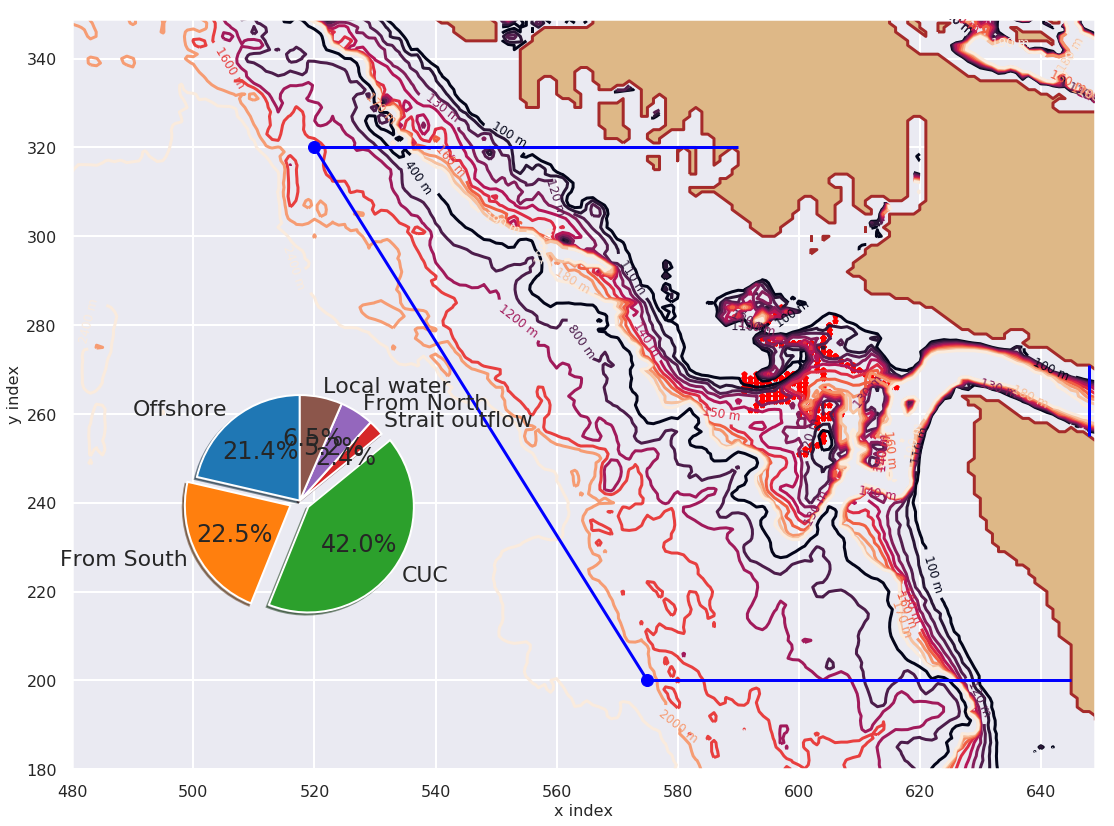

In [21]:
print("For particles rightly predicted by model for accurate eddy water on each isopycnal")


plot_pie_diagram(cuc_percentage=cuc_percent, juan_percentage=juan_percent, \
                 north_percentage=north_percent, south_percentage=south_percent, \
                 off_percentage=off_percent)

In [64]:
traj_tem_last   = np.empty_like(final_age_days)
traj_sal_last   = np.empty_like(final_age_days)
traj_rho_last   = np.empty_like(final_age_days)
traj_depth_last = np.empty_like(final_age_days)


traj_tem_init   = np.empty_like(final_age_days)
traj_sal_init   = np.empty_like(final_age_days)
traj_rho_init   = np.empty_like(final_age_days)
traj_depth_init = np.empty_like(final_age_days)

for r in np.arange(traj_tem_last.shape[0]):
    traj_tem_last[r]  =  traj_tem[np.int(final_age_days[r]),r]
    traj_sal_last[r]  =  traj_sal[np.int(final_age_days[r]),r]
    traj_rho_last[r]  =  traj_rho[np.int(final_age_days[r]),r]
    traj_depth_last[r] = traj_depth[np.int(final_age_days[r]),r]
    
    traj_tem_init[r]  =  traj_tem[0,r]
    traj_sal_init[r]  =  traj_sal[0,r]
    traj_rho_init[r]  =  traj_rho[0,r]    
    traj_depth_init[r]=  traj_depth[0,r] 
    

In [65]:
max_life_ind = np.array(np.where(final_age_days == np.max(final_age_days))[0])

off_ind   = off_ind
north_ind = np.where([(x_final < 580) & (y_final > 300)])[1]
south_ind = []
cuc_ind   = []


ind_all_south  = np.where(((x_final < 630) & (y_final < 200)) & \
                                      ((x_final > 580) & (y_final < 200)))[0]

for k in ind_all_south:
    if final_z[k] <= 26.3:
        south_ind = np.append(arr=south_ind, values= k)
        
    if final_z[k] > 26.3:
        cuc_ind = np.append(arr=cuc_ind, values=k)
        

juan_ind =  np.where((x_final > 648))[0]

non_local_ind = np.concatenate((off_ind, north_ind, south_ind, cuc_ind, juan_ind))

ind_local = np.setdiff1d(max_life_ind, np.unique(non_local_ind, return_index= False).astype(int), assume_unique=True)

# off_ind/

# ind_local = np.setdiff1d(max_life_ind, off_ind, assume_unique= True)

x_local_low_actual = x2[ind_local]
y_local_low_actual = y2[ind_local]

depth_local_low_actual = -traj_depth_last[ind_local]


In [66]:
count_ind = np.concatenate((ind_local, np.unique(non_local_ind, return_index= False).astype(int)))

count_ind.shape[0]/final_z.shape[0]

0.989501312335958

In [67]:

traj_tem_final_cuc = traj_tem_last[cuc_ind.astype(int)]
traj_sal_final_cuc = traj_sal_last[cuc_ind.astype(int)]
traj_rho_final_cuc = traj_rho_last[cuc_ind.astype(int)]
traj_depth_final_cuc = traj_depth_last[cuc_ind.astype(int)]
traj_days_final_cuc = final_age_days[cuc_ind.astype(int)]/24



traj_tem_final_north = traj_tem_last[north_ind.astype(int)]
traj_sal_final_north = traj_sal_last[north_ind.astype(int)]
traj_rho_final_north = traj_rho_last[north_ind.astype(int)]
traj_depth_final_north = traj_depth_last[north_ind.astype(int)]
traj_days_final_north = final_age_days[north_ind.astype(int)]/24



traj_tem_final_south   = traj_tem_last[south_ind.astype(int)]
traj_sal_final_south   = traj_sal_last[south_ind.astype(int)]
traj_rho_final_south   = traj_rho_last[south_ind.astype(int)]
traj_depth_final_south = traj_depth_last[south_ind.astype(int)]
traj_days_final_south  = final_age_days[south_ind.astype(int)]/24


traj_tem_final_juan = traj_tem_last[juan_ind.astype(int)]
traj_sal_final_juan = traj_sal_last[juan_ind.astype(int)]
traj_rho_final_juan = traj_rho_last[juan_ind.astype(int)]
traj_depth_final_juan = traj_depth_last[juan_ind.astype(int)]
traj_days_final_juan = final_age_days[juan_ind.astype(int)]/24


traj_tem_final_local = traj_tem_last[ind_local.astype(int)]
traj_sal_final_local = traj_sal_last[ind_local.astype(int)]
traj_rho_final_local = traj_rho_last[ind_local.astype(int)]
traj_depth_final_local = traj_depth_last[ind_local.astype(int)]
traj_days_final_local = final_age_days[ind_local.astype(int)]/24




x = [510,575]
y = [320,200]

coefficients = np.polyfit(x, y, 1)
x_final_off = np.arange(x[0],x[1])
polynomial = np.poly1d(coefficients)
y_final_off = np.rint(polynomial(x_final_off))

traj_tem_final_off = []
traj_sal_final_off = []
traj_rho_final_off = []
traj_depth_final_off = []
traj_days_final_off = []

for l in np.arange(off_ind.shape[0]):

    traj_depth_final_off = np.append(arr=traj_depth_final_off, values=traj_depth_last[np.int(off_ind[l])])
    traj_days_final_off = np.append(arr=traj_days_final_off, values=final_age_days[np.int(off_ind[l])]/24)
    traj_rho_final_off   = np.append(arr=traj_rho_final_off, values=traj_rho_last[np.int(off_ind[l])])
    traj_tem_final_off   = np.append(arr=traj_tem_final_off, values=traj_tem_last[np.int(off_ind[l])])
    traj_sal_final_off   = np.append(arr=traj_sal_final_off, values=traj_sal_last[np.int(off_ind[l])])


In [68]:
pressure_loc_cuc = np.empty_like(traj_depth_final_cuc)
SA_loc_cuc       = np.empty_like(traj_depth_final_cuc)
CT_loc_cuc       = np.empty_like(traj_depth_final_cuc)
spic_loc_cuc     = np.empty_like(traj_depth_final_cuc)



for i in np.arange(traj_depth_final_cuc.shape[0]):
    
    pressure_loc_cuc[i] = gsw.p_from_z(traj_depth_final_cuc[i],np.mean(traj_lat))
    
    SA_loc_cuc[i] = gsw.SA_from_SP(traj_sal_final_cuc[i], pressure_loc_cuc[i], np.mean(traj_lon), np.mean(traj_lat))
    
    CT_loc_cuc[i] = gsw.CT_from_pt(traj_sal_final_cuc[i], traj_tem_final_cuc[i])
    
    spic_loc_cuc[i] = gsw.spiciness0(SA_loc_cuc[i], CT_loc_cuc[i])
    
pressure_loc_off = np.empty_like(traj_depth_final_off)
SA_loc_off       = np.empty_like(traj_depth_final_off)
CT_loc_off       = np.empty_like(traj_depth_final_off)
spic_loc_off     = np.empty_like(traj_depth_final_off)



for i in np.arange(traj_depth_final_off.shape[0]):
    
    pressure_loc_off[i] = gsw.p_from_z(traj_depth_final_off[i],np.mean(traj_lat))
    
    SA_loc_off[i] = gsw.SA_from_SP(traj_sal_final_off[i], pressure_loc_off[i], np.mean(traj_lon), np.mean(traj_lat))
    
    CT_loc_off[i] = gsw.CT_from_pt(traj_sal_final_off[i], traj_tem_final_off[i])
    
    spic_loc_off[i] = gsw.spiciness0(SA_loc_off[i], CT_loc_off[i])
    
pressure_loc_south = np.empty_like(traj_depth_final_south)
SA_loc_south       = np.empty_like(traj_depth_final_south)
CT_loc_south       = np.empty_like(traj_depth_final_south)
spic_loc_south     = np.empty_like(traj_depth_final_south)



for i in np.arange(traj_depth_final_south.shape[0]):
    
    pressure_loc_south[i] = gsw.p_from_z(traj_depth_final_south[i],np.mean(traj_lat))
    
    SA_loc_south[i] = gsw.SA_from_SP(traj_sal_final_south[i], pressure_loc_south[i], np.mean(traj_lon), np.mean(traj_lat))
    
    CT_loc_south[i] = gsw.CT_from_pt(traj_sal_final_south[i], traj_tem_final_south[i])
    
    spic_loc_south[i] = gsw.spiciness0(SA_loc_south[i], CT_loc_south[i])
    
pressure_loc_north= np.empty_like(traj_depth_final_north)
SA_loc_north       = np.empty_like(traj_depth_final_north)
CT_loc_north       = np.empty_like(traj_depth_final_north)
spic_loc_north     = np.empty_like(traj_depth_final_north)



for i in np.arange(traj_depth_final_north.shape[0]):
    
    pressure_loc_north[i] = gsw.p_from_z(traj_depth_final_north[i],np.mean(traj_lat))
    
    SA_loc_north[i] = gsw.SA_from_SP(traj_sal_final_north[i], pressure_loc_north[i], np.mean(traj_lon), np.mean(traj_lat))
    
    CT_loc_north[i] = gsw.CT_from_pt(traj_sal_final_north[i], traj_tem_final_north[i])
    
    spic_loc_north[i] = gsw.spiciness0(SA_loc_north[i], CT_loc_north[i])
    

pressure_loc_juan= np.empty_like(traj_depth_final_juan)
SA_loc_juan       = np.empty_like(traj_depth_final_juan)
CT_loc_juan       = np.empty_like(traj_depth_final_juan)
spic_loc_juan     = np.empty_like(traj_depth_final_juan)



for i in np.arange(traj_depth_final_juan.shape[0]):
    
    pressure_loc_juan[i] = gsw.p_from_z(traj_depth_final_juan[i],np.mean(traj_lat))
    
    SA_loc_juan[i] = gsw.SA_from_SP(traj_sal_final_juan[i], pressure_loc_juan[i], np.mean(traj_lon), np.mean(traj_lat))
    
    CT_loc_juan[i] = gsw.CT_from_pt(traj_sal_final_juan[i], traj_tem_final_juan[i])
    
    spic_loc_juan[i] = gsw.spiciness0(SA_loc_juan[i], CT_loc_juan[i])
    

In [69]:

pressure_loc_init = np.empty_like(traj_tem_init)
SA_loc_init       = np.empty_like(traj_depth_init)
CT_loc_init       = np.empty_like(traj_depth_init)
spic_loc_init     = np.empty_like(traj_depth_init)



for i in np.arange(traj_depth_init.shape[0]):
    
    pressure_loc_init[i] = gsw.p_from_z(traj_depth_init[i],np.mean(traj_lat))
    
    SA_loc_init[i] = gsw.SA_from_SP(traj_sal_init[i], pressure_loc_init[i], np.mean(traj_lon), np.mean(traj_lat))
    
    CT_loc_init[i] = gsw.CT_from_pt(traj_sal_init[i], traj_tem_init[i])
    
    spic_loc_init[i] = gsw.spiciness0(SA_loc_init[i], CT_loc_init[i])
    
    
pressure_loc_local = np.empty_like(traj_depth_final_local)
SA_loc_local       = np.empty_like(traj_depth_final_local)
CT_loc_local       = np.empty_like(traj_depth_final_local)
spic_loc_local     = np.empty_like(traj_depth_final_local)



for i in np.arange(traj_depth_final_local.shape[0]):
    
    pressure_loc_local[i] = gsw.p_from_z(traj_depth_final_local[i],np.mean(traj_lat))
    
    SA_loc_local[i] = gsw.SA_from_SP(traj_sal_final_local[i], pressure_loc_local[i], np.mean(traj_lon), np.mean(traj_lat))
    
    CT_loc_local[i] = gsw.CT_from_pt(traj_sal_final_local[i], traj_tem_final_local[i])
    
    spic_loc_local[i] = gsw.spiciness0(SA_loc_local[i], CT_loc_local[i])    
    

In [70]:
spic_loc_local = spic_loc_local[spic_loc_local>-2]
spic_loc_init = spic_loc_init[spic_loc_init>-2]


In [71]:
##For Spice


spic_cuc   = np.mean(spic_loc_cuc)
spic_south = np.mean(spic_loc_south)
spic_off   = np.mean(spic_loc_off)
spic_north = np.mean(spic_loc_north)
spic_juan  = np.mean(spic_loc_juan)
spic_local = np.mean(spic_loc_local)

spic_cuc_std   = np.std(spic_loc_cuc)
spic_south_std = np.std(spic_loc_south)
spic_off_std   = np.std(spic_loc_off)
spic_north_std = np.std(spic_loc_north)
spic_juan_std  = np.std(spic_loc_juan)
spic_local_std = np.std(spic_loc_local)

frac_cuc   = cuc_percent_low/100
frac_south = south_percent_low/100
frac_off   = off_percent_low/100
frac_north = north_percent_low/100
frac_juan = juan_percent_low/100
frac_local = (ind_local.shape[0]/final_z.shape[0])

# spic_mixed = spic_cuc*frac_cuc + spic_south*frac_south + spic_off*frac_off + spic_juan*frac_juan + spic_north*frac_north + \
#      spic_local*frac_local

spic_mixed = spic_cuc*frac_cuc + spic_south*frac_south + spic_local*frac_local
    
print(spic_mixed)

err_mixing_spic = np.sqrt((spic_cuc_std*frac_cuc)**2 + (spic_south_std*frac_south)**2 + (spic_off_std*frac_off)**2 + (spic_juan_std*frac_juan)**2 + \
              (spic_north_std*frac_north)**2 + (spic_local_std*frac_local)**2)

# err_mixing_spic = np.sqrt((spic_cuc_std*frac_cuc)**2 + (spic_south_std*frac_south)**2 + (spic_local_std*frac_local)**2)

print(err_mixing_spic)

print(np.mean(spic_loc_init))

-0.0386852311955
0.0818785795432
-0.0727292476184


In [72]:
##For Spice


T_cuc   = np.mean(traj_tem_final_cuc)
T_south = np.mean(traj_tem_final_south)
T_off   = np.mean(traj_tem_final_off)
T_north = np.mean(traj_tem_final_north)
T_juan  = np.mean(traj_tem_final_juan)
T_local = np.mean(traj_tem_final_local)

T_cuc_std   = np.std(traj_tem_final_cuc)
T_south_std = np.std(traj_tem_final_south)
T_off_std   = np.std(traj_tem_final_off)
T_north_std = np.std(traj_tem_final_north)
T_juan_std  = np.std(traj_tem_final_juan)
T_local_std = np.std(traj_tem_final_local)

frac_cuc   = cuc_percent_low/100
frac_south = south_percent_low/100
frac_off   = off_percent_low/100
frac_north = north_percent_low/100
frac_juan = juan_percent_low/100


frac_local = (ind_local.shape[0]/final_z.shape[0])

# T_mixed = T_cuc*frac_cuc + T_south*frac_south + T_local*frac_local
T_mixed = T_cuc*frac_cuc + T_south*frac_south + T_off*frac_off + T_juan*frac_juan + T_north*frac_north + \
     T_local*frac_local
    
print(T_mixed)

err_mixing_T = np.sqrt((T_cuc_std*frac_cuc)**2 + (T_south_std*frac_south)**2 + (T_off_std*frac_off)**2 + (T_juan_std*frac_juan)**2 + \
              (T_north_std*frac_north)**2 + (T_local_std*frac_local)**2)

# err_mixing_T = np.sqrt((T_cuc_std*frac_cuc)**2 + (T_south_std*frac_south)**2 + (T_local_std*frac_local)**2)

print(err_mixing_T)

print(np.mean(traj_tem_init))

7.37871867717
0.27122033912
7.41741263981


In [73]:
##For Spice


Sal_cuc   = np.mean(traj_sal_final_cuc)
Sal_south = np.mean(traj_sal_final_south)
Sal_off   = np.mean(traj_sal_final_off)
Sal_north = np.mean(traj_sal_final_north)
Sal_juan  = np.mean(traj_sal_final_juan)
Sal_local = np.mean(traj_sal_final_local)

Sal_cuc_std   = np.std(traj_sal_final_cuc)
Sal_south_std = np.std(traj_sal_final_south)
Sal_off_std   = np.std(traj_sal_final_off)
Sal_north_std = np.std(traj_sal_final_north)
Sal_juan_std  = np.std(traj_sal_final_juan)
Sal_local_std = np.std(traj_sal_final_local)

frac_cuc   = cuc_percent_low/100
frac_south = (south_percent_low/100)*1.009
frac_off   = off_percent_low/100
frac_north = north_percent_low/100
frac_juan = juan_percent_low/100


frac_local = (ind_local.shape[0]/final_z.shape[0])

# Sal_mixed = Sal_cuc*frac_cuc + Sal_south*frac_south + Sal_local*frac_local
Sal_mixed = Sal_cuc*frac_cuc*0.98 + Sal_south*frac_south + Sal_off*frac_off + Sal_juan*frac_juan + Sal_north*frac_north + \
     Sal_local*frac_local
    
print(Sal_mixed)

err_mixing_Sal = np.sqrt((Sal_cuc_std*frac_cuc)**2 + (Sal_south_std*frac_south)**2 + (Sal_off_std*frac_off)**2 + (Sal_juan_std*frac_juan)**2 + \
              (Sal_north_std*frac_north)**2 + (Sal_local_std*frac_local)**2)

# err_mixing_Sal = np.sqrt((Sal_cuc_std*frac_cuc)**2 + (Sal_south_std*frac_south)**2 + (Sal_local_std*frac_local)**2)

print(err_mixing_Sal)

print(np.mean(traj_sal_init))

33.7255527991
0.140608736921
33.6966018693


In [74]:
##For Density


Rho_cuc   = np.mean(traj_rho_final_cuc)
Rho_south = np.mean(traj_rho_final_south)
Rho_off   = np.mean(traj_rho_final_off)
Rho_north = np.mean(traj_rho_final_north)
Rho_juan  = np.mean(traj_rho_final_juan)
Rho_local = np.mean(traj_rho_final_local)

Rho_cuc_std   = np.std(traj_rho_final_cuc)
Rho_south_std = np.std(traj_rho_final_south)
Rho_off_std   = np.std(traj_rho_final_off)
Rho_north_std = np.std(traj_rho_final_north)
Rho_juan_std  = np.std(traj_rho_final_juan)
Rho_local_std = np.std(traj_rho_final_local)

frac_cuc   = cuc_percent_low/100
frac_south = (south_percent_low/100)*1.009
frac_off   = off_percent_low/100
frac_north = north_percent_low/100
frac_juan = juan_percent_low/100
frac_local = (ind_local.shape[0]/final_z.shape[0])

# Rho_mixed = Rho_cuc*frac_cuc + Rho_south*frac_south + Rho_local*frac_local
Rho_mixed = Rho_cuc*frac_cuc*0.98 + Rho_south*frac_south + Rho_off*frac_off + Rho_juan*frac_juan + Rho_north*frac_north + \
     Rho_local*frac_local
    
print(Rho_mixed)

err_mixing_Rho = np.sqrt((Rho_cuc_std*frac_cuc)**2 + (Rho_south_std*frac_south)**2 + (Rho_off_std*frac_off)**2 + (Rho_juan_std*frac_juan)**2 + \
              (Rho_north_std*frac_north)**2 + (Rho_local_std*frac_local)**2)

# err_mixing_Rho = np.sqrt((Rho_cuc_std*frac_cuc)**2 + (Rho_south_std*frac_south)**2 + (Rho_local_std*frac_local)**2)

print(err_mixing_Rho)

print(np.mean(traj_rho_init))

26.3679742154
0.136040893073
26.3340703792


In [75]:
data_table = {'Temperature ($^{\circ}$C)': [T_cuc, T_south, T_off, T_north, T_juan, T_local, T_mixed], \
              'T_Std': [T_cuc_std, T_south_std, T_off_std, T_north_std, T_juan_std, T_local_std, err_mixing_T],\
              'Salinity (PSU)': [Sal_cuc, Sal_south, Sal_off, Sal_north, Sal_juan, Sal_local, Sal_mixed], \
              'Sal_Std': [Sal_cuc_std, Sal_south_std, Sal_off_std, Sal_north_std, Sal_juan_std, Sal_local_std, err_mixing_Sal], \
              'Potential Density': [Rho_cuc, Rho_south, Rho_off, Rho_north, Rho_juan, Rho_local, Rho_mixed],\
              'Rho_Std': [Rho_cuc_std, Rho_south_std, Rho_off_std, Rho_north_std, Rho_juan_std, Rho_local_std, err_mixing_Rho], \
              'Type of Source Water':['CUC water', 'South Water', 'Offshore Water', 'North Water', \
                                         'Strait Outflow Water', 'Local Water', 'Eddy Water']}

df = pd.DataFrame(data=data_table, columns=['Type of Source Water','Temperature ($^{\circ}$C)', 'T_Std', 'Salinity (PSU)', 'Sal_Std', \
                                            'Potential Density', 'Rho_Std'])

df['Temperature ($^{\\circ}$C)'] = df['Temperature ($^{\\circ}$C)'].astype(float).round(1)
df['T_Std'] = df['T_Std'].astype(float).round(2)


df['Salinity (PSU)'] = df['Salinity (PSU)'].astype(float).round(1)
df['Sal_Std'] = df['Sal_Std'].astype(float).round(2)

df['Potential Density'] = df['Potential Density'].astype(float).round(1)
df['Rho_Std'] = df['Rho_Std'].astype(float).round(2)

# df.groupby(df.columns.str[-1], axis=1).apply(lambda x: x.astype(str).apply('±'.join, 1))

# df['Temperature ($^{\\circ}$C)'] = df['Temperature ($^{\\circ}$C)'].apply(lambda x: x.astype(str).apply('±'.join, 1))

# df.head(10)

for i in np.arange(len(df)):
    print('±'.join((df['Temperature ($^{\\circ}$C)'][i].astype(str),df['T_Std'][i].astype(str))))


6.7±0.47
7.7±0.32
7.6±0.7
7.9±1.01
9.5±1.12
7.5±0.74
7.4±0.27


In [76]:
df.head(10)

,Type of Source Water,Temperature ($^{\circ}$C),T_Std,Salinity (PSU),Sal_Std,Potential Density,Rho_Std
0,CUC water,6.7,0.47,34.0,0.04,26.6,0.09
1,South Water,7.7,0.32,33.7,0.22,26.3,0.22
2,Offshore Water,7.6,0.70,33.3,0.53,26.0,0.50
3,North Water,7.9,1.01,33.1,0.56,25.8,0.58
4,Strait Outflow Water,9.5,1.12,31.4,0.44,24.3,0.42
5,Local Water,7.5,0.74,33.5,0.75,26.1,0.65
6,Eddy Water,7.4,0.27,33.7,0.14,26.4,0.14


In [77]:
dg = pd.DataFrame(columns=['Temperature ($^{\\circ}$C)','Salinity (PSU)', 'Potential Density'], index = ['CUC water', 'South Water', 'Offshore Water', 'North Water', \
                                         'Strait Outflow Water', 'Local Water', 'Eddy Water'])


for i in np.arange(len(df)):
    print(i)
    dg['Temperature ($^{\\circ}$C)'][i] = '±'.join((df['Temperature ($^{\\circ}$C)'][i].astype(str), \
                                                    df['T_Std'][i].astype(str)))
    dg['Salinity (PSU)'][i] = '±'.join((df['Salinity (PSU)'][i].astype(str), \
                                                    df['Sal_Std'][i].astype(str)))
    
    dg['Potential Density'][i] = '±'.join((df['Potential Density'][i].astype(str), \
                                                    df['Rho_Std'][i].astype(str)))
    
    

0
1
2
3
4
5
6


In [78]:
dg.head(6)

,Temperature ($^{\circ}$C),Salinity (PSU),Potential Density
CUC water,6.7±0.47,34.0±0.04,26.6±0.09
South Water,7.7±0.32,33.7±0.22,26.3±0.22
Offshore Water,7.6±0.7,33.3±0.53,26.0±0.5
North Water,7.9±1.01,33.1±0.56,25.8±0.58
Strait Outflow Water,9.5±1.12,31.4±0.44,24.3±0.42
Local Water,7.5±0.74,33.5±0.75,26.1±0.65


In [79]:
df.to_latex(index=False)

'\\begin{tabular}{lrrrrrr}\n\\toprule\n Type of Source Water &  Temperature (\\$\\textasciicircum\\{\\textbackslashcirc\\}\\$C) &  T\\_Std &  Salinity (PSU) &  Sal\\_Std &  Potential Density &  Rho\\_Std \\\\\n\\midrule\n            CUC water &                        6.7 &   0.47 &            34.0 &     0.04 &               26.6 &     0.09 \\\\\n          South Water &                        7.7 &   0.32 &            33.7 &     0.22 &               26.3 &     0.22 \\\\\n       Offshore Water &                        7.6 &   0.70 &            33.3 &     0.53 &               26.0 &     0.50 \\\\\n          North Water &                        7.9 &   1.01 &            33.1 &     0.56 &               25.8 &     0.58 \\\\\n Strait Outflow Water &                        9.5 &   1.12 &            31.4 &     0.44 &               24.3 &     0.42 \\\\\n          Local Water &                        7.5 &   0.74 &            33.5 &     0.75 &               26.1 &     0.65 \\\\\n           Eddy W

In [22]:
def calculate_kde(variable):
    
    
    if variable == 'Temperature':
        

        
        kde_cuc = scipy.stats.gaussian_kde(traj_tem_final_cuc)
        kde_south = scipy.stats.gaussian_kde(traj_tem_final_south)
        kde_local = scipy.stats.gaussian_kde(traj_tem_final_local)
        kde_juan  = scipy.stats.gaussian_kde(traj_tem_final_juan)
        kde_north = scipy.stats.gaussian_kde(traj_tem_final_north)
        kde_off = scipy.stats.gaussian_kde(traj_tem_final_off)

        kde_init  = scipy.stats.gaussian_kde(traj_tem_init)
        
        
        mu = T_mixed
        sigma = err_mixing_T
        #grid = np.linspace(-0.3,0.2,500)
#         grid = np.linspace(mu - 6*sigma, mu + 6*sigma, 100)        
        grid = np.linspace(5,10, 10000) 

        #weighted kde curves
        w_cuc   = kde_cuc(grid)*(cuc_percent/100)
        w_south = kde_south(grid)*(south_percent/100)
        w_local = kde_local(grid)*(ind_local.shape[0]/final_z.shape[0])
        w_north = kde_north(grid)*(north_percent/100)
        w_juan = kde_juan(grid)*(juan_percent/100)
        w_off = kde_off(grid)*(off_percent/100)
        w_init = kde_init(grid)
        
        return w_cuc, w_south, w_local, w_north, w_juan, w_off, w_init, grid, mu, sigma
    
        
    if variable == 'Salinity':
        

        
        kde_cuc = scipy.stats.gaussian_kde(traj_sal_final_cuc, bw_method=-2)
        kde_south = scipy.stats.gaussian_kde(traj_sal_final_south)
        kde_local = scipy.stats.gaussian_kde(traj_sal_final_local)
        kde_juan  = scipy.stats.gaussian_kde(traj_sal_final_juan)
        kde_north = scipy.stats.gaussian_kde(traj_sal_final_north)
        kde_off = scipy.stats.gaussian_kde(traj_sal_final_off)

        kde_init  = scipy.stats.gaussian_kde(traj_sal_init)
        
        
        mu = Sal_mixed
        sigma = err_mixing_Sal
        #grid = np.linspace(-0.3,0.2,500)
#         grid = np.linspace(33, mu + 3*sigma, 100)  
        grid = np.linspace(31, 34.5, 10000) 
        

        #weighted kde curves
        w_cuc   = kde_cuc(grid)*(cuc_percent/100)
        w_south = kde_south(grid)*(south_percent/100)
        w_local = kde_local(grid)*(ind_local.shape[0]/final_z.shape[0])
        w_north = kde_north(grid)*(north_percent/100)
        w_juan = kde_juan(grid)*(juan_percent/100)
        w_off = kde_off(grid)*(off_percent/100)
        w_init = kde_init(grid)
        
        return w_cuc, w_south, w_local, w_north, w_juan, w_off, w_init, grid, mu, sigma
    
    if variable == 'Density':
        

        
        kde_cuc = scipy.stats.gaussian_kde(traj_rho_final_cuc, bw_method=-1)
        kde_south = scipy.stats.gaussian_kde(traj_rho_final_south)
        kde_local = scipy.stats.gaussian_kde(traj_rho_final_local)
        kde_juan  = scipy.stats.gaussian_kde(traj_rho_final_juan)
        kde_north = scipy.stats.gaussian_kde(traj_rho_final_north)
        kde_off = scipy.stats.gaussian_kde(traj_rho_final_off)

        kde_init  = scipy.stats.gaussian_kde(traj_rho_init)
        
        
        mu = Rho_mixed
        sigma = err_mixing_Rho
        #grid = np.linspace(-0.3,0.2,500)
#         grid = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)    
        grid = np.linspace(23,28, 10000) 
        

        #weighted kde curves
        w_cuc   = kde_cuc(grid)*(cuc_percent/100)
        w_south = kde_south(grid)*(south_percent/100)
        w_local = kde_local(grid)*(ind_local.shape[0]/final_z.shape[0])
        w_north = kde_north(grid)*(north_percent/100)
        w_juan = kde_juan(grid)*(juan_percent/100)
        w_off = kde_off(grid)*(off_percent/100)
        w_init = kde_init(grid)
        
        return w_cuc, w_south, w_local, w_north, w_juan, w_off, w_init, grid, mu, sigma
     
    
    
    if variable == 'Spice':
        

        
        kde_cuc = scipy.stats.gaussian_kde(spic_loc_cuc, bw_method=-1)
        kde_south = scipy.stats.gaussian_kde(spic_loc_south)
        kde_local = scipy.stats.gaussian_kde(spic_loc_local)
        kde_juan  = scipy.stats.gaussian_kde(spic_loc_juan)
        kde_north = scipy.stats.gaussian_kde(spic_loc_north)
        kde_off = scipy.stats.gaussian_kde(spic_loc_off)

        kde_init  = scipy.stats.gaussian_kde(spic_loc_init)
        
        
        mu = spic_mixed
        sigma = err_mixing_spic
        #grid = np.linspace(-0.3,0.2,500)
#         grid = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)  
        grid = np.linspace(-2,2, 10000)   

#         grid = np.linspace(5,10, 10000)    
        

        #weighted kde curves
        w_cuc   = kde_cuc(grid)*(cuc_percent/100)
        w_south = kde_south(grid)*(south_percent/100)
        w_local = kde_local(grid)*(ind_local.shape[0]/final_z.shape[0])
        w_north = kde_north(grid)*(north_percent/100)
        w_juan = kde_juan(grid)*(juan_percent/100)
        w_off = kde_off(grid)*(off_percent/100)
        w_init = kde_init(grid)
        
        return w_cuc, w_south, w_local, w_north, w_juan, w_off, w_init, grid, mu, sigma
    
    
    if variable == 'Depth':
        

        
        kde_cuc = scipy.stats.gaussian_kde(-traj_depth_final_cuc)
        kde_south = scipy.stats.gaussian_kde(-traj_depth_final_south)
        kde_local = scipy.stats.gaussian_kde(-traj_depth_final_local)
        kde_juan  = scipy.stats.gaussian_kde(-traj_depth_final_juan)
        kde_north = scipy.stats.gaussian_kde(-traj_depth_final_north)
        kde_off = scipy.stats.gaussian_kde(-traj_depth_final_off)

        kde_init  = scipy.stats.gaussian_kde(-traj_depth_init)
        
        
 
        #grid = np.linspace(-0.3,0.2,500)
#         grid = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)  
        grid = np.linspace(0,500, 10000)   

#         grid = np.linspace(5,10, 10000)    
        

        #weighted kde curves
        w_cuc   = kde_cuc(grid)*(cuc_percent/100)
        w_south = kde_south(grid)*(south_percent/100)
        w_local = kde_local(grid)*(ind_local.shape[0]/final_z.shape[0])
        w_north = kde_north(grid)*(north_percent/100)
        w_juan = kde_juan(grid)*(juan_percent/100)
        w_off = kde_off(grid)*(off_percent/100)
        w_init = kde_init(grid)
        
        return w_cuc, w_south, w_local, w_north, w_juan, w_off, w_init, grid
    
    
    if variable == 'Days':
        

        
        kde_cuc = scipy.stats.gaussian_kde(traj_days_final_cuc)
        kde_south = scipy.stats.gaussian_kde(traj_days_final_south)
#         kde_local = scipy.stats.gaussian_kde(traj_days_final_local)
        kde_juan  = scipy.stats.gaussian_kde(traj_days_final_juan)
        kde_north = scipy.stats.gaussian_kde(traj_days_final_north)
        kde_off = scipy.stats.gaussian_kde(traj_days_final_off)


        
        
 
        #grid = np.linspace(-0.3,0.2,500)
#         grid = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)  
        grid = np.linspace(0,200, 10000)   

#         grid = np.linspace(5,10, 10000)    
        

        #weighted kde curves
        w_cuc   = kde_cuc(grid)*(cuc_percent/100)
        w_south = kde_south(grid)*(south_percent/100)
#         w_local = kde_local(grid)*(ind_local.shape[0]/final_z.shape[0])
        w_north = kde_north(grid)*(north_percent/100)
        w_juan = kde_juan(grid)*(juan_percent/100)
        w_off = kde_off(grid)*(off_percent/100)
#         w_init = kde_init(grid)
        
        return w_cuc, w_south, w_north, w_juan, w_off,  grid
        
        
        
        
        

        
        

In [23]:
sns.set_context('paper')

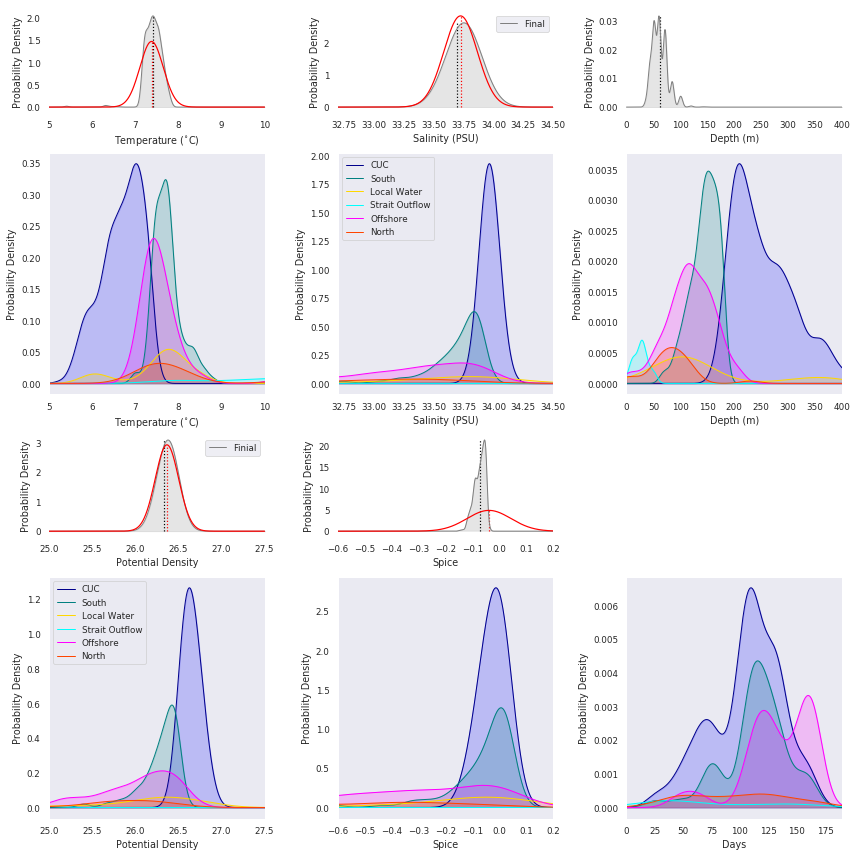

In [25]:
fig = plt.figure(figsize=(12,12))

# fig = plt.figure(figsize=(13,8))

gs2 = gridspec.GridSpec(6, 3)
# gs2.update(left=0.55, right=0.98, hspace=0.05)

# gs2.update(wspace=0.025, hspace=0.05)


ax1 = plt.subplot(gs2[1:3, 0])
ax1_marg = plt.subplot(gs2[0, 0], sharex=ax1, frameon = False)

ax2 = plt.subplot(gs2[4:, 0])
ax2_marg = plt.subplot(gs2[3, 0], sharex=ax2, frameon = False)



ax3 = plt.subplot(gs2[1:3, 1])
ax3_marg = plt.subplot(gs2[0, 1], sharex=ax3, frameon = False)

ax4 = plt.subplot(gs2[4:, 1])
ax4_marg = plt.subplot(gs2[3, 1], sharex=ax4, frameon = False)


ax5 = plt.subplot(gs2[1:3, 2])
ax5_marg = plt.subplot(gs2[0, 2], sharex=ax5, frameon = False)

ax6 = plt.subplot(gs2[4:, 2])
# ax6_marg = plt.subplot(gs2[3, 2], sharex=ax6, frameon = False)


#Temperature
w_cuc, w_south, w_local, w_north, w_juan, w_off, w_init, grid, mu, sigma = calculate_kde(variable='Temperature')


ax1.plot(grid, w_cuc, lw=1, color = 'darkblue', label = "CUC")
ax1.fill_between(grid, w_cuc, lw=1, color  = 'blue', alpha= 0.2)
# ax.vlines(x=np.mean(spic_loc_cuc), color = 'blue',  ymax=np.max(w_cuc), ymin = 0, linestyles='dotted')

ax1.plot(grid, w_south, lw=1, color = 'teal', label = "South")
ax1.fill_between(grid, w_south, color = 'teal',alpha = 0.2)

ax1.plot(grid, w_local, lw=1, color = 'gold', label = "Local Water")
ax1.fill_between(grid, w_local, color = 'gold', alpha= 0.2)
# ax.vlines(x=spic_local, color = 'yellow',  ymax=np.max(w_local), ymin = 0, linestyles='dotted')

ax1.plot(grid, w_juan, lw=1, color = 'cyan', label = "Strait Outflow")
ax1.fill_between(grid, w_juan, color = 'cyan', alpha= 0.2)

ax1.plot(grid, w_off, lw=1, color = 'magenta', label = "Offshore")
ax1.fill_between(grid, w_off, color = 'magenta', alpha= 0.2)

ax1.plot(grid, w_north, lw=1, color = 'orangered', label = "North")
ax1.fill_between(grid, w_north, color = 'orangered', alpha= 0.2)

ax1_marg.plot(grid, w_init, lw=1, color = 'gray', label = "Final")
ax1_marg.fill_between(grid, w_init, color = 'gray', alpha= 0.2)

ax1_marg.vlines(x=np.mean(traj_tem_init), color = 'k', ymax=np.max(w_init), \
                 ymin= 0, linestyles='dotted')

ax1_marg.plot(grid, scipy.stats.norm.pdf(grid, mu, sigma), 'red')
ax1_marg.vlines(x=mu, color = 'red', ymax=np.max(scipy.stats.norm.pdf(grid, mu, sigma)), ymin= 0, linestyles='dotted')
# fig.subplots_adjust(hspace=0)

ax1.set_xlim(5,10)
ax1.set_xlabel('Temperature ($^{\circ}$C)')
ax1.set_ylabel('Probability Density')
# ax1.legend(loc= 'best')

ax1_marg.set_xlim(5,10)
ax1_marg.set_xlabel('Temperature ($^{\circ}$C)')
ax1_marg.set_ylabel('Probability Density')
# ax1_marg.legend(loc= 'best')
# ax1.get_legend().remove()
ax1.grid()


#Salinity
w_cuc, w_south, w_local, w_north, w_juan, w_off, w_init, grid, mu, sigma = calculate_kde(variable='Salinity')


ax3.plot(grid, w_cuc, lw=1, color = 'darkblue', label = "CUC")
ax3.fill_between(grid, w_cuc, lw=1, color  = 'blue', alpha= 0.2)
# ax.vlines(x=np.mean(spic_loc_cuc), color = 'blue',  ymax=np.max(w_cuc), ymin = 0, linestyles='dotted')

ax3.plot(grid, w_south, lw=1, color = 'teal', label = "South")
ax3.fill_between(grid, w_south, color = 'teal',alpha = 0.2)

ax3.plot(grid, w_local, lw=1, color = 'gold', label = "Local Water")
ax3.fill_between(grid, w_local, color = 'gold', alpha= 0.2)
# ax.vlines(x=spic_local, color = 'yellow',  ymax=np.max(w_local), ymin = 0, linestyles='dotted')

ax3.plot(grid, w_juan, lw=1, color = 'cyan', label = "Strait Outflow")
ax3.fill_between(grid, w_juan, color = 'cyan', alpha= 0.2)

ax3.plot(grid, w_off, lw=1, color = 'magenta', label = "Offshore")
ax3.fill_between(grid, w_off, color = 'magenta', alpha= 0.2)

ax3.plot(grid, w_north, lw=1, color = 'orangered', label = "North")
ax3.fill_between(grid, w_north, color = 'orangered', alpha= 0.2)

ax3_marg.plot(grid, w_init, lw=1, color = 'gray', label = "Final")
ax3_marg.fill_between(grid, w_init, color = 'gray', alpha= 0.2)

ax3_marg.vlines(x=np.mean(traj_sal_init), color = 'k', ymax=np.max(w_init), \
                 ymin= 0, linestyles='dotted')

ax3_marg.plot(grid, scipy.stats.norm.pdf(grid, mu, sigma), 'red')
ax3_marg.vlines(x=mu, color = 'red', ymax=np.max(scipy.stats.norm.pdf(grid, mu, sigma)), ymin= 0, linestyles='dotted')
# fig.subplots_adjust(hspace=0)

ax3.set_xlim(32.7,34.5)
ax3.set_xlabel('Salinity (PSU)')
ax3.set_ylabel('Probability Density')
# ax3.get_legend().remove()

ax3_marg.set_xlim(32.7,34.5)
ax3_marg.set_xlabel('Salinity (PSU)')
ax3_marg.set_ylabel('Probability Density')
# ax3_marg.get_legend().remove()
ax3.grid()


#Density
w_cuc, w_south, w_local, w_north, w_juan, w_off, w_init, grid, mu, sigma = calculate_kde(variable='Density')


ax2.plot(grid, w_cuc, lw=1, color = 'darkblue', label = "CUC")
ax2.fill_between(grid, w_cuc, lw=1, color  = 'blue', alpha= 0.2)
# ax.vlines(x=np.mean(spic_loc_cuc), color = 'blue',  ymax=np.max(w_cuc), ymin = 0, linestyles='dotted')

ax2.plot(grid, w_south, lw=1, color = 'teal', label = "South")
ax2.fill_between(grid, w_south, color = 'teal',alpha = 0.2)

ax2.plot(grid, w_local, lw=1, color = 'gold', label = "Local Water")
ax2.fill_between(grid, w_local, color = 'gold', alpha= 0.2)
# ax.vlines(x=spic_local, color = 'yellow',  ymax=np.max(w_local), ymin = 0, linestyles='dotted')

ax2.plot(grid, w_juan, lw=1, color = 'cyan', label = "Strait Outflow")
ax2.fill_between(grid, w_juan, color = 'cyan', alpha= 0.2)

ax2.plot(grid, w_off, lw=1, color = 'magenta', label = "Offshore")
ax2.fill_between(grid, w_off, color = 'magenta', alpha= 0.2)

ax2.plot(grid, w_north, lw=1, color = 'orangered', label = "North")
ax2.fill_between(grid, w_north, color = 'orangered', alpha= 0.2)

ax2_marg.plot(grid, w_init, lw=1, color = 'gray', label = "Finial")
ax2_marg.fill_between(grid, w_init, color = 'gray', alpha= 0.2)

ax2_marg.vlines(x=np.mean(traj_rho_init), color = 'k', ymax=np.max(w_init), \
                 ymin= 0, linestyles='dotted')

ax2_marg.plot(grid, scipy.stats.norm.pdf(grid, mu, sigma), 'red')
ax2_marg.vlines(x=mu, color = 'red', ymax=np.max(scipy.stats.norm.pdf(grid, mu, sigma)), ymin= 0, linestyles='dotted')
# fig.subplots_adjust(hspace=0)

ax2.set_xlim(25,27.5)
ax2.set_xlabel('Potential Density')
ax2.set_ylabel('Probability Density')
# ax3.get_legend().remove()

ax2_marg.set_xlim(25,27.5)
ax2_marg.set_xlabel('Potential Density')
ax2_marg.set_ylabel('Probability Density')
# ax3_marg.get_legend().remove()
ax2.grid()

#Spice
w_cuc, w_south, w_local, w_north, w_juan, w_off, w_init, grid, mu, sigma = calculate_kde(variable='Spice')


ax4.plot(grid, w_cuc, lw=1, color = 'darkblue', label = "CUC")
ax4.fill_between(grid, w_cuc, lw=1, color  = 'blue', alpha= 0.2)
# ax.vlines(x=np.mean(spic_loc_cuc), color = 'blue',  ymax=np.max(w_cuc), ymin = 0, linestyles='dotted')

ax4.plot(grid, w_south, lw=1, color = 'teal', label = "South")
ax4.fill_between(grid, w_south, color = 'teal',alpha = 0.2)

ax4.plot(grid, w_local, lw=1, color = 'gold', label = "Local Water")
ax4.fill_between(grid, w_local, color = 'gold', alpha= 0.2)
# ax.vlines(x=spic_local, color = 'yellow',  ymax=np.max(w_local), ymin = 0, linestyles='dotted')

ax4.plot(grid, w_juan, lw=1, color = 'cyan', label = "Strait Outflow")
ax4.fill_between(grid, w_juan, color = 'cyan', alpha= 0.2)

ax4.plot(grid, w_off, lw=1, color = 'magenta', label = "Offshore")
ax4.fill_between(grid, w_off, color = 'magenta', alpha= 0.2)

ax4.plot(grid, w_north, lw=1, color = 'orangered', label = "North")
ax4.fill_between(grid, w_north, color = 'orangered', alpha= 0.2)

ax4_marg.plot(grid, w_init, lw=1, color = 'gray', label = "Final")
ax4_marg.fill_between(grid, w_init, color = 'gray', alpha= 0.2)

ax4_marg.vlines(x=np.mean(spic_loc_init), color = 'k', ymax=np.max(w_init), \
                 ymin= 0, linestyles='dotted')

ax4_marg.plot(grid, scipy.stats.norm.pdf(grid, mu, sigma), 'red')
ax4_marg.vlines(x=mu, color = 'red', ymax=np.max(scipy.stats.norm.pdf(grid, mu, sigma)), ymin= 0, linestyles='dotted')
# fig.subplots_adjust(hspace=0)

ax4.set_xlim(-0.6,0.2)
ax4.set_xlabel('Spice')
ax4.set_ylabel('Probability Density')
# ax3.get_legend().remove()

ax4_marg.set_xlim(-0.6,0.2)
ax4_marg.set_xlabel('Spice')
ax4_marg.set_ylabel('Probability Density')
# ax3_marg.get_legend().remove()
ax4.grid()



#Depth
w_cuc, w_south, w_local, w_north, w_juan, w_off, w_init, grid = calculate_kde(variable='Depth')


ax5.plot(grid, w_cuc, lw=1, color = 'darkblue', label = "CUC")
ax5.fill_between(grid, w_cuc, lw=1, color  = 'blue', alpha= 0.2)
# ax.vlines(x=np.mean(spic_loc_cuc), color = 'blue',  ymax=np.max(w_cuc), ymin = 0, linestyles='dotted')

ax5.plot(grid, w_south, lw=1, color = 'teal', label = "South")
ax5.fill_between(grid, w_south, color = 'teal',alpha = 0.2)

ax5.plot(grid, w_local, lw=1, color = 'gold', label = "Local Water")
ax5.fill_between(grid, w_local, color = 'gold', alpha= 0.2)
# ax.vlines(x=spic_local, color = 'yellow',  ymax=np.max(w_local), ymin = 0, linestyles='dotted')

ax5.plot(grid, w_juan, lw=1, color = 'cyan', label = "Strait Outflow")
ax5.fill_between(grid, w_juan, color = 'cyan', alpha= 0.2)

ax5.plot(grid, w_off, lw=1, color = 'magenta', label = "Offshore")
ax5.fill_between(grid, w_off, color = 'magenta', alpha= 0.2)

ax5.plot(grid, w_north, lw=1, color = 'orangered', label = "North")
ax5.fill_between(grid, w_north, color = 'orangered', alpha= 0.2)

ax5_marg.plot(grid, w_init, lw=1, color = 'gray', label = "Final")
ax5_marg.fill_between(grid, w_init, color = 'gray', alpha= 0.2)

ax5_marg.vlines(x=np.mean(-traj_depth_init), color = 'k', ymax=np.max(w_init), \
                 ymin= 0, linestyles='dotted')


ax5.set_xlim(0,400)
ax5.set_xlabel('Depth (m)')
ax5.set_ylabel('Probability Density')
# ax3.get_legend().remove()

ax5_marg.set_xlim(0,400)
ax5_marg.set_xlabel('Depth (m)')
ax5_marg.set_ylabel('Probability Density')
# ax3_marg.get_legend().remove()
ax5.grid()

#Days
w_cuc, w_south,  w_north, w_juan, w_off,  grid = calculate_kde(variable='Days')


ax6.plot(grid, w_cuc, lw=1, color = 'darkblue', label = "CUC")
ax6.fill_between(grid, w_cuc, lw=1, color  = 'blue', alpha= 0.2)
# ax.vlines(x=np.mean(spic_loc_cuc), color = 'blue',  ymax=np.max(w_cuc), ymin = 0, linestyles='dotted')

ax6.plot(grid, w_south, lw=1, color = 'teal', label = "South")
ax6.fill_between(grid, w_south, color = 'teal',alpha = 0.2)


ax6.plot(grid, w_juan, lw=1, color = 'cyan', label = "Strait Outflow")
ax6.fill_between(grid, w_juan, color = 'cyan', alpha= 0.2)

ax6.plot(grid, w_off, lw=1, color = 'magenta', label = "Offshore")
ax6.fill_between(grid, w_off, color = 'magenta', alpha= 0.2)

ax6.plot(grid, w_north, lw=1, color = 'orangered', label = "North")
ax6.fill_between(grid, w_north, color = 'orangered', alpha= 0.2)




ax6.set_xlim(0,190)
ax6.set_xlabel('Days')
ax6.set_ylabel('Probability Density')
# ax6.legend(loc = 'best')
# ax3.get_legend().remove()

# ax3_marg.get_legend().remove()
ax6.grid()



ax2.legend(loc = 'best')
ax2_marg.legend(loc = 'best')

ax3.legend(loc = 'best')
ax3_marg.legend(loc = 'best')



gs2.tight_layout(fig=fig,rect=[0, 0, 1, 1], h_pad=0.1)



In [ ]:
#For poster

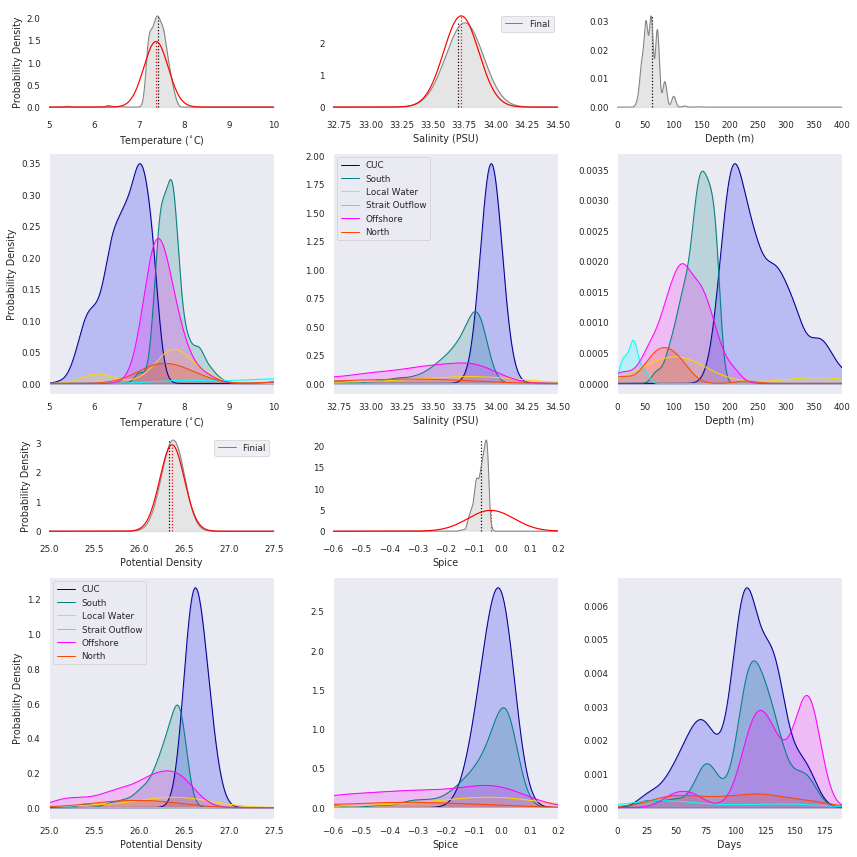

In [24]:
fig = plt.figure(figsize=(12,12))

# fig = plt.figure(figsize=(13,8))

gs2 = gridspec.GridSpec(6, 3)
# gs2.update(left=0.55, right=0.98, hspace=0.05)

# gs2.update(wspace=0.025, hspace=0.05)


ax1 = plt.subplot(gs2[1:3, 0])
ax1_marg = plt.subplot(gs2[0, 0], sharex=ax1, frameon = False)

ax2 = plt.subplot(gs2[4:, 0])
ax2_marg = plt.subplot(gs2[3, 0], sharex=ax2, frameon = False)



ax3 = plt.subplot(gs2[1:3, 1])
ax3_marg = plt.subplot(gs2[0, 1], sharex=ax3, frameon = False)

ax4 = plt.subplot(gs2[4:, 1])
ax4_marg = plt.subplot(gs2[3, 1], sharex=ax4, frameon = False)


ax5 = plt.subplot(gs2[1:3, 2])
ax5_marg = plt.subplot(gs2[0, 2], sharex=ax5, frameon = False)

ax6 = plt.subplot(gs2[4:, 2])
# ax6_marg = plt.subplot(gs2[3, 2], sharex=ax6, frameon = False)


#Temperature
w_cuc, w_south, w_local, w_north, w_juan, w_off, w_init, grid, mu, sigma = calculate_kde(variable='Temperature')


ax1.plot(grid, w_cuc, lw=1, color = 'darkblue', label = "CUC")
ax1.fill_between(grid, w_cuc, lw=1, color  = 'blue', alpha= 0.2)
# ax.vlines(x=np.mean(spic_loc_cuc), color = 'blue',  ymax=np.max(w_cuc), ymin = 0, linestyles='dotted')

ax1.plot(grid, w_south, lw=1, color = 'teal', label = "South")
ax1.fill_between(grid, w_south, color = 'teal',alpha = 0.2)

ax1.plot(grid, w_local, lw=1, color = 'gold', label = "Local Water")
ax1.fill_between(grid, w_local, color = 'gold', alpha= 0.2)
# ax.vlines(x=spic_local, color = 'yellow',  ymax=np.max(w_local), ymin = 0, linestyles='dotted')

ax1.plot(grid, w_juan, lw=1, color = 'cyan', label = "Strait Outflow")
ax1.fill_between(grid, w_juan, color = 'cyan', alpha= 0.2)

ax1.plot(grid, w_off, lw=1, color = 'magenta', label = "Offshore")
ax1.fill_between(grid, w_off, color = 'magenta', alpha= 0.2)

ax1.plot(grid, w_north, lw=1, color = 'orangered', label = "North")
ax1.fill_between(grid, w_north, color = 'orangered', alpha= 0.2)

ax1_marg.plot(grid, w_init, lw=1, color = 'gray', label = "Final")
ax1_marg.fill_between(grid, w_init, color = 'gray', alpha= 0.2)

ax1_marg.vlines(x=np.mean(traj_tem_init), color = 'k', ymax=np.max(w_init), \
                 ymin= 0, linestyles='dotted')

ax1_marg.plot(grid, scipy.stats.norm.pdf(grid, mu, sigma), 'red')
ax1_marg.vlines(x=mu, color = 'red', ymax=np.max(scipy.stats.norm.pdf(grid, mu, sigma)), ymin= 0, linestyles='dotted')
# fig.subplots_adjust(hspace=0)

ax1.set_xlim(5,10)
ax1.set_xlabel('Temperature ($^{\circ}$C)')
ax1.set_ylabel('Probability Density')
# ax1.legend(loc= 'best')

ax1_marg.set_xlim(5,10)
ax1_marg.set_xlabel('Temperature ($^{\circ}$C)')
ax1_marg.set_ylabel('Probability Density')
# ax1_marg.legend(loc= 'best')
# ax1.get_legend().remove()
ax1.grid()


#Salinity
w_cuc, w_south, w_local, w_north, w_juan, w_off, w_init, grid, mu, sigma = calculate_kde(variable='Salinity')


ax3.plot(grid, w_cuc, lw=1, color = 'darkblue', label = "CUC")
ax3.fill_between(grid, w_cuc, lw=1, color  = 'blue', alpha= 0.2)
# ax.vlines(x=np.mean(spic_loc_cuc), color = 'blue',  ymax=np.max(w_cuc), ymin = 0, linestyles='dotted')

ax3.plot(grid, w_south, lw=1, color = 'teal', label = "South")
ax3.fill_between(grid, w_south, color = 'teal',alpha = 0.2)

ax3.plot(grid, w_local, lw=1, color = 'gold', label = "Local Water")
ax3.fill_between(grid, w_local, color = 'gold', alpha= 0.2)
# ax.vlines(x=spic_local, color = 'yellow',  ymax=np.max(w_local), ymin = 0, linestyles='dotted')

ax3.plot(grid, w_juan, lw=1, color = 'cyan', label = "Strait Outflow")
ax3.fill_between(grid, w_juan, color = 'cyan', alpha= 0.2)

ax3.plot(grid, w_off, lw=1, color = 'magenta', label = "Offshore")
ax3.fill_between(grid, w_off, color = 'magenta', alpha= 0.2)

ax3.plot(grid, w_north, lw=1, color = 'orangered', label = "North")
ax3.fill_between(grid, w_north, color = 'orangered', alpha= 0.2)

ax3_marg.plot(grid, w_init, lw=1, color = 'gray', label = "Final")
ax3_marg.fill_between(grid, w_init, color = 'gray', alpha= 0.2)

ax3_marg.vlines(x=np.mean(traj_sal_init), color = 'k', ymax=np.max(w_init), \
                 ymin= 0, linestyles='dotted')

ax3_marg.plot(grid, scipy.stats.norm.pdf(grid, mu, sigma), 'red')
ax3_marg.vlines(x=mu, color = 'red', ymax=np.max(scipy.stats.norm.pdf(grid, mu, sigma)), ymin= 0, linestyles='dotted')
# fig.subplots_adjust(hspace=0)

ax3.set_xlim(32.7,34.5)
ax3.set_xlabel('Salinity (PSU)')
ax3.set_ylabel('')
# ax3.get_legend().remove()

ax3_marg.set_xlim(32.7,34.5)
ax3_marg.set_xlabel('Salinity (PSU)')
ax3_marg.set_ylabel('')
# ax3_marg.get_legend().remove()
ax3.grid()


#Density
w_cuc, w_south, w_local, w_north, w_juan, w_off, w_init, grid, mu, sigma = calculate_kde(variable='Density')


ax2.plot(grid, w_cuc, lw=1, color = 'darkblue', label = "CUC")
ax2.fill_between(grid, w_cuc, lw=1, color  = 'blue', alpha= 0.2)
# ax.vlines(x=np.mean(spic_loc_cuc), color = 'blue',  ymax=np.max(w_cuc), ymin = 0, linestyles='dotted')

ax2.plot(grid, w_south, lw=1, color = 'teal', label = "South")
ax2.fill_between(grid, w_south, color = 'teal',alpha = 0.2)

ax2.plot(grid, w_local, lw=1, color = 'gold', label = "Local Water")
ax2.fill_between(grid, w_local, color = 'gold', alpha= 0.2)
# ax.vlines(x=spic_local, color = 'yellow',  ymax=np.max(w_local), ymin = 0, linestyles='dotted')

ax2.plot(grid, w_juan, lw=1, color = 'cyan', label = "Strait Outflow")
ax2.fill_between(grid, w_juan, color = 'cyan', alpha= 0.2)

ax2.plot(grid, w_off, lw=1, color = 'magenta', label = "Offshore")
ax2.fill_between(grid, w_off, color = 'magenta', alpha= 0.2)

ax2.plot(grid, w_north, lw=1, color = 'orangered', label = "North")
ax2.fill_between(grid, w_north, color = 'orangered', alpha= 0.2)

ax2_marg.plot(grid, w_init, lw=1, color = 'gray', label = "Finial")
ax2_marg.fill_between(grid, w_init, color = 'gray', alpha= 0.2)

ax2_marg.vlines(x=np.mean(traj_rho_init), color = 'k', ymax=np.max(w_init), \
                 ymin= 0, linestyles='dotted')

ax2_marg.plot(grid, scipy.stats.norm.pdf(grid, mu, sigma), 'red')
ax2_marg.vlines(x=mu, color = 'red', ymax=np.max(scipy.stats.norm.pdf(grid, mu, sigma)), ymin= 0, linestyles='dotted')
# fig.subplots_adjust(hspace=0)

ax2.set_xlim(25,27.5)
ax2.set_xlabel('Potential Density')
ax2.set_ylabel('Probability Density')
# ax3.get_legend().remove()

ax2_marg.set_xlim(25,27.5)
ax2_marg.set_xlabel('Potential Density')
ax2_marg.set_ylabel('Probability Density')
# ax3_marg.get_legend().remove()
ax2.grid()

#Spice
w_cuc, w_south, w_local, w_north, w_juan, w_off, w_init, grid, mu, sigma = calculate_kde(variable='Spice')


ax4.plot(grid, w_cuc, lw=1, color = 'darkblue', label = "CUC")
ax4.fill_between(grid, w_cuc, lw=1, color  = 'blue', alpha= 0.2)
# ax.vlines(x=np.mean(spic_loc_cuc), color = 'blue',  ymax=np.max(w_cuc), ymin = 0, linestyles='dotted')

ax4.plot(grid, w_south, lw=1, color = 'teal', label = "South")
ax4.fill_between(grid, w_south, color = 'teal',alpha = 0.2)

ax4.plot(grid, w_local, lw=1, color = 'gold', label = "Local Water")
ax4.fill_between(grid, w_local, color = 'gold', alpha= 0.2)
# ax.vlines(x=spic_local, color = 'yellow',  ymax=np.max(w_local), ymin = 0, linestyles='dotted')

ax4.plot(grid, w_juan, lw=1, color = 'cyan', label = "Strait Outflow")
ax4.fill_between(grid, w_juan, color = 'cyan', alpha= 0.2)

ax4.plot(grid, w_off, lw=1, color = 'magenta', label = "Offshore")
ax4.fill_between(grid, w_off, color = 'magenta', alpha= 0.2)

ax4.plot(grid, w_north, lw=1, color = 'orangered', label = "North")
ax4.fill_between(grid, w_north, color = 'orangered', alpha= 0.2)

ax4_marg.plot(grid, w_init, lw=1, color = 'gray', label = "Final")
ax4_marg.fill_between(grid, w_init, color = 'gray', alpha= 0.2)

ax4_marg.vlines(x=np.mean(spic_loc_init), color = 'k', ymax=np.max(w_init), \
                 ymin= 0, linestyles='dotted')

ax4_marg.plot(grid, scipy.stats.norm.pdf(grid, mu, sigma), 'red')
ax4_marg.vlines(x=mu, color = 'red', ymax=np.max(scipy.stats.norm.pdf(grid, mu, sigma)), ymin= 0, linestyles='dotted')
# fig.subplots_adjust(hspace=0)

ax4.set_xlim(-0.6,0.2)
ax4.set_xlabel('Spice')
ax4.set_ylabel('')
# ax3.get_legend().remove()

ax4_marg.set_xlim(-0.6,0.2)
ax4_marg.set_xlabel('Spice')
ax4_marg.set_ylabel('')
# ax3_marg.get_legend().remove()
ax4.grid()



#Depth
w_cuc, w_south, w_local, w_north, w_juan, w_off, w_init, grid = calculate_kde(variable='Depth')


ax5.plot(grid, w_cuc, lw=1, color = 'darkblue', label = "CUC")
ax5.fill_between(grid, w_cuc, lw=1, color  = 'blue', alpha= 0.2)
# ax.vlines(x=np.mean(spic_loc_cuc), color = 'blue',  ymax=np.max(w_cuc), ymin = 0, linestyles='dotted')

ax5.plot(grid, w_south, lw=1, color = 'teal', label = "South")
ax5.fill_between(grid, w_south, color = 'teal',alpha = 0.2)

ax5.plot(grid, w_local, lw=1, color = 'gold', label = "Local Water")
ax5.fill_between(grid, w_local, color = 'gold', alpha= 0.2)
# ax.vlines(x=spic_local, color = 'yellow',  ymax=np.max(w_local), ymin = 0, linestyles='dotted')

ax5.plot(grid, w_juan, lw=1, color = 'cyan', label = "Strait Outflow")
ax5.fill_between(grid, w_juan, color = 'cyan', alpha= 0.2)

ax5.plot(grid, w_off, lw=1, color = 'magenta', label = "Offshore")
ax5.fill_between(grid, w_off, color = 'magenta', alpha= 0.2)

ax5.plot(grid, w_north, lw=1, color = 'orangered', label = "North")
ax5.fill_between(grid, w_north, color = 'orangered', alpha= 0.2)

ax5_marg.plot(grid, w_init, lw=1, color = 'gray', label = "Final")
ax5_marg.fill_between(grid, w_init, color = 'gray', alpha= 0.2)

ax5_marg.vlines(x=np.mean(-traj_depth_init), color = 'k', ymax=np.max(w_init), \
                 ymin= 0, linestyles='dotted')


ax5.set_xlim(0,400)
ax5.set_xlabel('Depth (m)')
ax5.set_ylabel('')
# ax3.get_legend().remove()

ax5_marg.set_xlim(0,400)
ax5_marg.set_xlabel('Depth (m)')
ax5_marg.set_ylabel('')
# ax3_marg.get_legend().remove()
ax5.grid()

#Days
w_cuc, w_south,  w_north, w_juan, w_off,  grid = calculate_kde(variable='Days')


ax6.plot(grid, w_cuc, lw=1, color = 'darkblue', label = "CUC")
ax6.fill_between(grid, w_cuc, lw=1, color  = 'blue', alpha= 0.2)
# ax.vlines(x=np.mean(spic_loc_cuc), color = 'blue',  ymax=np.max(w_cuc), ymin = 0, linestyles='dotted')

ax6.plot(grid, w_south, lw=1, color = 'teal', label = "South")
ax6.fill_between(grid, w_south, color = 'teal',alpha = 0.2)


ax6.plot(grid, w_juan, lw=1, color = 'cyan', label = "Strait Outflow")
ax6.fill_between(grid, w_juan, color = 'cyan', alpha= 0.2)

ax6.plot(grid, w_off, lw=1, color = 'magenta', label = "Offshore")
ax6.fill_between(grid, w_off, color = 'magenta', alpha= 0.2)

ax6.plot(grid, w_north, lw=1, color = 'orangered', label = "North")
ax6.fill_between(grid, w_north, color = 'orangered', alpha= 0.2)




ax6.set_xlim(0,190)
ax6.set_xlabel('Days')
ax6.set_ylabel('')
# ax6.legend(loc = 'best')
# ax3.get_legend().remove()

# ax3_marg.get_legend().remove()
ax6.grid()



ax2.legend(loc = 'best')
ax2_marg.legend(loc = 'best')

ax3.legend(loc = 'best')
ax3_marg.legend(loc = 'best')



gs2.tight_layout(fig=fig,rect=[0, 0, 1, 1], h_pad=0.1)



In [23]:
#Temperature
w_cuc, w_south, w_local, w_north, w_juan, w_off, w_init, grid, mu_tem, sigma_tem = calculate_kde(variable='Temperature')

#Salinity
w_cuc, w_south, w_local, w_north, w_juan, w_off, w_init, grid, mu_sal, sigma_sal = calculate_kde(variable='Salinity')

#Density
w_cuc, w_south, w_local, w_north, w_juan, w_off, w_init, grid, mu_den, sigma_den = calculate_kde(variable='Density')

#Spice
w_cuc, w_south, w_local, w_north, w_juan, w_off, w_init, grid, mu_spic, sigma_spic = calculate_kde(variable='Spice')



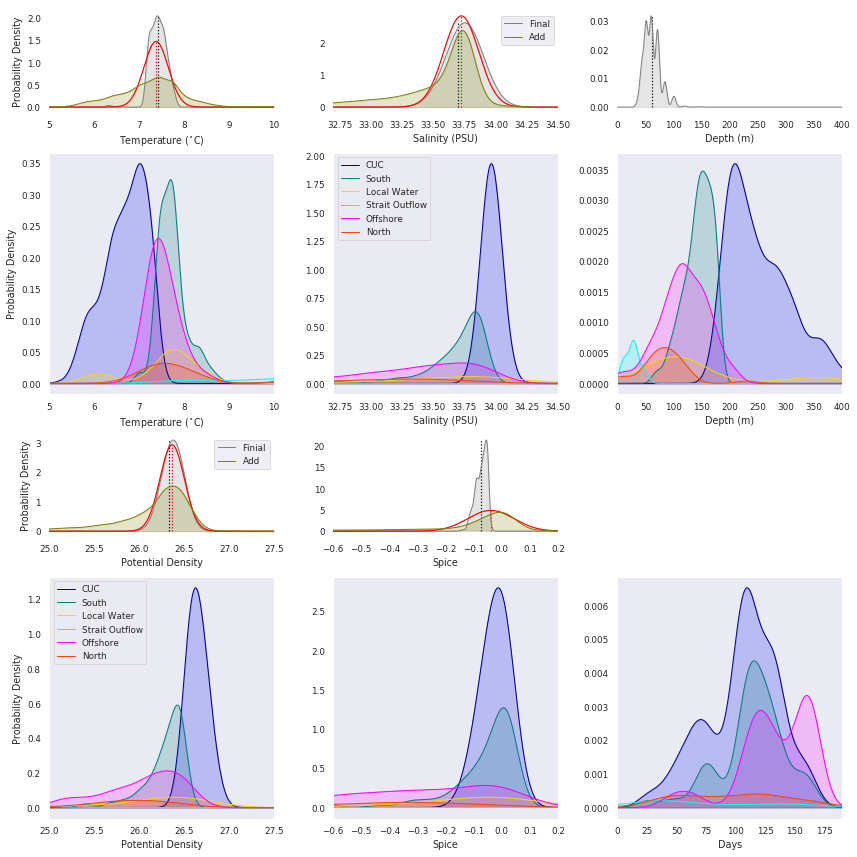

In [38]:
fig = plt.figure(figsize=(12,12))

# fig = plt.figure(figsize=(13,8))

gs2 = gridspec.GridSpec(6, 3)
# gs2.update(left=0.55, right=0.98, hspace=0.05)

# gs2.update(wspace=0.025, hspace=0.05)


ax1 = plt.subplot(gs2[1:3, 0])
ax1_marg = plt.subplot(gs2[0, 0], sharex=ax1, frameon = False)

ax2 = plt.subplot(gs2[4:, 0])
ax2_marg = plt.subplot(gs2[3, 0], sharex=ax2, frameon = False)



ax3 = plt.subplot(gs2[1:3, 1])
ax3_marg = plt.subplot(gs2[0, 1], sharex=ax3, frameon = False)

ax4 = plt.subplot(gs2[4:, 1])
ax4_marg = plt.subplot(gs2[3, 1], sharex=ax4, frameon = False)


ax5 = plt.subplot(gs2[1:3, 2])
ax5_marg = plt.subplot(gs2[0, 2], sharex=ax5, frameon = False)

ax6 = plt.subplot(gs2[4:, 2])
# ax6_marg = plt.subplot(gs2[3, 2], sharex=ax6, frameon = False)


#Temperature
w_cuc, w_south, w_local, w_north, w_juan, w_off, w_init, grid, mu, sigma = calculate_kde(variable='Temperature')


ax1.plot(grid, w_cuc, lw=1, color = 'darkblue', label = "CUC")
ax1.fill_between(grid, w_cuc, lw=1, color  = 'blue', alpha= 0.2)
# ax.vlines(x=np.mean(spic_loc_cuc), color = 'blue',  ymax=np.max(w_cuc), ymin = 0, linestyles='dotted')

ax1.plot(grid, w_south, lw=1, color = 'teal', label = "South")
ax1.fill_between(grid, w_south, color = 'teal',alpha = 0.2)

ax1.plot(grid, w_local, lw=1, color = 'gold', label = "Local Water")
ax1.fill_between(grid, w_local, color = 'gold', alpha= 0.2)
# ax.vlines(x=spic_local, color = 'yellow',  ymax=np.max(w_local), ymin = 0, linestyles='dotted')

ax1.plot(grid, w_juan, lw=1, color = 'cyan', label = "Strait Outflow")
ax1.fill_between(grid, w_juan, color = 'cyan', alpha= 0.2)

ax1.plot(grid, w_off, lw=1, color = 'magenta', label = "Offshore")
ax1.fill_between(grid, w_off, color = 'magenta', alpha= 0.2)

ax1.plot(grid, w_north, lw=1, color = 'orangered', label = "North")
ax1.fill_between(grid, w_north, color = 'orangered', alpha= 0.2)

ax1_marg.plot(grid, w_init, lw=1, color = 'gray', label = "Final")
ax1_marg.fill_between(grid, w_init, color = 'gray', alpha= 0.2)

ax1_marg.vlines(x=np.mean(traj_tem_init), color = 'k', ymax=np.max(w_init), \
                 ymin= 0, linestyles='dotted')

ax1_marg.plot(grid, scipy.stats.norm.pdf(grid, mu, sigma), 'red')
ax1_marg.vlines(x=mu, color = 'red', ymax=np.max(scipy.stats.norm.pdf(grid, mu, sigma)), ymin= 0, linestyles='dotted')
# fig.subplots_adjust(hspace=0)



ax1_marg.plot(grid, (w_cuc+w_south+w_local+w_juan+w_off+w_north), lw=1, color = 'olive', label = "Add")
ax1_marg.fill_between(grid, (w_cuc+w_south+w_local+w_juan+w_off+w_north), lw=1, color  = 'olive', alpha= 0.2)

ax1.set_xlim(5,10)
ax1.set_xlabel('Temperature ($^{\circ}$C)')
ax1.set_ylabel('Probability Density')
# ax1.legend(loc= 'best')

ax1_marg.set_xlim(5,10)
ax1_marg.set_xlabel('Temperature ($^{\circ}$C)')
ax1_marg.set_ylabel('Probability Density')
# ax1_marg.legend(loc= 'best')
# ax1.get_legend().remove()
ax1.grid()


#Salinity
w_cuc, w_south, w_local, w_north, w_juan, w_off, w_init, grid, mu, sigma = calculate_kde(variable='Salinity')


ax3.plot(grid, w_cuc, lw=1, color = 'darkblue', label = "CUC")
ax3.fill_between(grid, w_cuc, lw=1, color  = 'blue', alpha= 0.2)
# ax.vlines(x=np.mean(spic_loc_cuc), color = 'blue',  ymax=np.max(w_cuc), ymin = 0, linestyles='dotted')

ax3.plot(grid, w_south, lw=1, color = 'teal', label = "South")
ax3.fill_between(grid, w_south, color = 'teal',alpha = 0.2)

ax3.plot(grid, w_local, lw=1, color = 'gold', label = "Local Water")
ax3.fill_between(grid, w_local, color = 'gold', alpha= 0.2)
# ax.vlines(x=spic_local, color = 'yellow',  ymax=np.max(w_local), ymin = 0, linestyles='dotted')

ax3.plot(grid, w_juan, lw=1, color = 'cyan', label = "Strait Outflow")
ax3.fill_between(grid, w_juan, color = 'cyan', alpha= 0.2)

ax3.plot(grid, w_off, lw=1, color = 'magenta', label = "Offshore")
ax3.fill_between(grid, w_off, color = 'magenta', alpha= 0.2)

ax3.plot(grid, w_north, lw=1, color = 'orangered', label = "North")
ax3.fill_between(grid, w_north, color = 'orangered', alpha= 0.2)

ax3_marg.plot(grid, w_init, lw=1, color = 'gray', label = "Final")
ax3_marg.fill_between(grid, w_init, color = 'gray', alpha= 0.2)

ax3_marg.vlines(x=np.mean(traj_sal_init), color = 'k', ymax=np.max(w_init), \
                 ymin= 0, linestyles='dotted')


ax3_marg.plot(grid, scipy.stats.norm.pdf(grid, mu, sigma), 'red')
ax3_marg.vlines(x=mu, color = 'red', ymax=np.max(scipy.stats.norm.pdf(grid, mu, sigma)), ymin= 0, linestyles='dotted')
# fig.subplots_adjust(hspace=0)

grid = np.linspace(30.79, 34.29, 10000) 
ax3_marg.plot(grid, (w_cuc+w_south+w_local+w_juan+w_off+w_north), lw=1, color = 'olive', label = "Add")
ax3_marg.fill_between(grid, (w_cuc+w_south+w_local+w_juan+w_off+w_north), lw=1, color  = 'olive', alpha= 0.2)

ax3.set_xlim(32.7,34.5)
ax3.set_xlabel('Salinity (PSU)')
ax3.set_ylabel('')
# ax3.get_legend().remove()

ax3_marg.set_xlim(32.7,34.5)
ax3_marg.set_xlabel('Salinity (PSU)')
ax3_marg.set_ylabel('')
# ax3_marg.get_legend().remove()
ax3.grid()


#Density
w_cuc, w_south, w_local, w_north, w_juan, w_off, w_init, grid, mu, sigma = calculate_kde(variable='Density')


ax2.plot(grid, w_cuc, lw=1, color = 'darkblue', label = "CUC")
ax2.fill_between(grid, w_cuc, lw=1, color  = 'blue', alpha= 0.2)
# ax.vlines(x=np.mean(spic_loc_cuc), color = 'blue',  ymax=np.max(w_cuc), ymin = 0, linestyles='dotted')

ax2.plot(grid, w_south, lw=1, color = 'teal', label = "South")
ax2.fill_between(grid, w_south, color = 'teal',alpha = 0.2)

ax2.plot(grid, w_local, lw=1, color = 'gold', label = "Local Water")
ax2.fill_between(grid, w_local, color = 'gold', alpha= 0.2)
# ax.vlines(x=spic_local, color = 'yellow',  ymax=np.max(w_local), ymin = 0, linestyles='dotted')

ax2.plot(grid, w_juan, lw=1, color = 'cyan', label = "Strait Outflow")
ax2.fill_between(grid, w_juan, color = 'cyan', alpha= 0.2)

ax2.plot(grid, w_off, lw=1, color = 'magenta', label = "Offshore")
ax2.fill_between(grid, w_off, color = 'magenta', alpha= 0.2)

ax2.plot(grid, w_north, lw=1, color = 'orangered', label = "North")
ax2.fill_between(grid, w_north, color = 'orangered', alpha= 0.2)

ax2_marg.plot(grid, w_init, lw=1, color = 'gray', label = "Finial")
ax2_marg.fill_between(grid, w_init, color = 'gray', alpha= 0.2)

ax2_marg.vlines(x=np.mean(traj_rho_init), color = 'k', ymax=np.max(w_init), \
                 ymin= 0, linestyles='dotted')

ax2_marg.plot(grid, scipy.stats.norm.pdf(grid, mu, sigma), 'red')
ax2_marg.vlines(x=mu, color = 'red', ymax=np.max(scipy.stats.norm.pdf(grid, mu, sigma)), ymin= 0, linestyles='dotted')
# fig.subplots_adjust(hspace=0)



grid = np.linspace(22.8,27.8, 10000)
ax2_marg.plot(grid, (w_cuc+w_south+w_local+w_juan+w_off+w_north), lw=1, color = 'olive', label = "Add")
ax2_marg.fill_between(grid, (w_cuc+w_south+w_local+w_juan+w_off+w_north), lw=1, color  = 'olive', alpha= 0.2)

ax2.set_xlim(25,27.5)
ax2.set_xlabel('Potential Density')
ax2.set_ylabel('Probability Density')
# ax3.get_legend().remove()

ax2_marg.set_xlim(25,27.5)
ax2_marg.set_xlabel('Potential Density')
ax2_marg.set_ylabel('Probability Density')
# ax3_marg.get_legend().remove()
ax2.grid()

#Spice
w_cuc, w_south, w_local, w_north, w_juan, w_off, w_init, grid, mu, sigma = calculate_kde(variable='Spice')


ax4.plot(grid, w_cuc, lw=1, color = 'darkblue', label = "CUC")
ax4.fill_between(grid, w_cuc, lw=1, color  = 'blue', alpha= 0.2)
# ax.vlines(x=np.mean(spic_loc_cuc), color = 'blue',  ymax=np.max(w_cuc), ymin = 0, linestyles='dotted')

ax4.plot(grid, w_south, lw=1, color = 'teal', label = "South")
ax4.fill_between(grid, w_south, color = 'teal',alpha = 0.2)

ax4.plot(grid, w_local, lw=1, color = 'gold', label = "Local Water")
ax4.fill_between(grid, w_local, color = 'gold', alpha= 0.2)
# ax.vlines(x=spic_local, color = 'yellow',  ymax=np.max(w_local), ymin = 0, linestyles='dotted')

ax4.plot(grid, w_juan, lw=1, color = 'cyan', label = "Strait Outflow")
ax4.fill_between(grid, w_juan, color = 'cyan', alpha= 0.2)

ax4.plot(grid, w_off, lw=1, color = 'magenta', label = "Offshore")
ax4.fill_between(grid, w_off, color = 'magenta', alpha= 0.2)

ax4.plot(grid, w_north, lw=1, color = 'orangered', label = "North")
ax4.fill_between(grid, w_north, color = 'orangered', alpha= 0.2)

ax4_marg.plot(grid, w_init, lw=1, color = 'gray', label = "Final")
ax4_marg.fill_between(grid, w_init, color = 'gray', alpha= 0.2)

ax4_marg.vlines(x=np.mean(spic_loc_init), color = 'k', ymax=np.max(w_init), \
                 ymin= 0, linestyles='dotted')

ax4_marg.plot(grid, scipy.stats.norm.pdf(grid, mu, sigma), 'red')
ax4_marg.vlines(x=mu, color = 'red', ymax=np.max(scipy.stats.norm.pdf(grid, mu, sigma)), ymin= 0, linestyles='dotted')
# fig.subplots_adjust(hspace=0)

ax4_marg.plot(grid, (w_cuc+w_south+w_local+w_juan+w_off+w_north), lw=1, color = 'olive', label = "Add")
ax4_marg.fill_between(grid, (w_cuc+w_south+w_local+w_juan+w_off+w_north), lw=1, color  = 'olive', alpha= 0.2)

ax4.set_xlim(-0.6,0.2)
ax4.set_xlabel('Spice')
ax4.set_ylabel('')
# ax3.get_legend().remove()

ax4_marg.set_xlim(-0.6,0.2)
ax4_marg.set_xlabel('Spice')
ax4_marg.set_ylabel('')
# ax3_marg.get_legend().remove()
ax4.grid()



#Depth
w_cuc, w_south, w_local, w_north, w_juan, w_off, w_init, grid = calculate_kde(variable='Depth')


ax5.plot(grid, w_cuc, lw=1, color = 'darkblue', label = "CUC")
ax5.fill_between(grid, w_cuc, lw=1, color  = 'blue', alpha= 0.2)
# ax.vlines(x=np.mean(spic_loc_cuc), color = 'blue',  ymax=np.max(w_cuc), ymin = 0, linestyles='dotted')


ax5.plot(grid, w_south, lw=1, color = 'teal', label = "South")
ax5.fill_between(grid, w_south, color = 'teal',alpha = 0.2)

ax5.plot(grid, w_local, lw=1, color = 'gold', label = "Local Water")
ax5.fill_between(grid, w_local, color = 'gold', alpha= 0.2)
# ax.vlines(x=spic_local, color = 'yellow',  ymax=np.max(w_local), ymin = 0, linestyles='dotted')

ax5.plot(grid, w_juan, lw=1, color = 'cyan', label = "Strait Outflow")
ax5.fill_between(grid, w_juan, color = 'cyan', alpha= 0.2)

ax5.plot(grid, w_off, lw=1, color = 'magenta', label = "Offshore")
ax5.fill_between(grid, w_off, color = 'magenta', alpha= 0.2)

ax5.plot(grid, w_north, lw=1, color = 'orangered', label = "North")
ax5.fill_between(grid, w_north, color = 'orangered', alpha= 0.2)

ax5_marg.plot(grid, w_init, lw=1, color = 'gray', label = "Final")
ax5_marg.fill_between(grid, w_init, color = 'gray', alpha= 0.2)

ax5_marg.vlines(x=np.mean(-traj_depth_init), color = 'k', ymax=np.max(w_init), \
                 ymin= 0, linestyles='dotted')


ax5.set_xlim(0,400)
ax5.set_xlabel('Depth (m)')
ax5.set_ylabel('')
# ax3.get_legend().remove()

ax5_marg.set_xlim(0,400)
ax5_marg.set_xlabel('Depth (m)')
ax5_marg.set_ylabel('')
# ax3_marg.get_legend().remove()
ax5.grid()

#Days
w_cuc, w_south,  w_north, w_juan, w_off,  grid = calculate_kde(variable='Days')


ax6.plot(grid, w_cuc, lw=1, color = 'darkblue', label = "CUC")
ax6.fill_between(grid, w_cuc, lw=1, color  = 'blue', alpha= 0.2)
# ax.vlines(x=np.mean(spic_loc_cuc), color = 'blue',  ymax=np.max(w_cuc), ymin = 0, linestyles='dotted')

ax6.plot(grid, w_south, lw=1, color = 'teal', label = "South")
ax6.fill_between(grid, w_south, color = 'teal',alpha = 0.2)


ax6.plot(grid, w_juan, lw=1, color = 'cyan', label = "Strait Outflow")
ax6.fill_between(grid, w_juan, color = 'cyan', alpha= 0.2)

ax6.plot(grid, w_off, lw=1, color = 'magenta', label = "Offshore")
ax6.fill_between(grid, w_off, color = 'magenta', alpha= 0.2)

ax6.plot(grid, w_north, lw=1, color = 'orangered', label = "North")
ax6.fill_between(grid, w_north, color = 'orangered', alpha= 0.2)




ax6.set_xlim(0,190)
ax6.set_xlabel('Days')
ax6.set_ylabel('')
# ax6.legend(loc = 'best')
# ax3.get_legend().remove()

# ax3_marg.get_legend().remove()
ax6.grid()



ax2.legend(loc = 'best')
ax2_marg.legend(loc = 'best')

ax3.legend(loc = 'best')
ax3_marg.legend(loc = 'best')



gs2.tight_layout(fig=fig,rect=[0, 0, 1, 1], h_pad=0.1)



In [ ]:
table_dict = {'Temperature ($^{\circ}$C)': [, 2], 'Salinity (PSU)': [3, 4], 'Potential Density': [3, 4], 'Spice': [3,4]}

(5, 12)

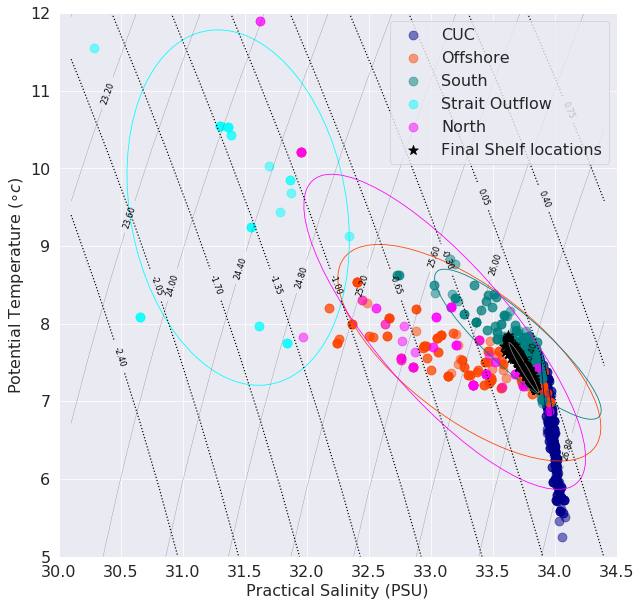

In [55]:
# colors = cmo.cm.phase(np.linspace(0, 1, 200))


# traj_sal_domain = traj_sal[traj_sal != 1.0100000202412861e+20]
# traj_tem_domain = traj_tem[traj_sal != 1.0100000202412861e+20]

# smin = np.nanmin(traj_sal_last)  - (0.01 * np.nanmin(traj_sal_last))
smin = 30
smax = np.nanmax(traj_sal_last)  + (0.01 * np.nanmax(traj_sal_last))
# tmin = np.nanmin(traj_tem_last) - (0.1 * np.nanmax(traj_tem_last))
tmin = 4
tmax = 12
# tmax = np.nanmax(traj_tem_last) + (0.1 * np.nanmax(traj_tem_last))
 
# Calculate how many gridcells we need in the x and y dimensions
xdim = int(round((smax-smin)/0.1+1,0))
ydim = int(round((tmax-tmin)+1,0))
 
# Create empty grid of zeros
dens_1 = np.empty((ydim,xdim))
spic_1 = np.empty((ydim,xdim))
SA = np.empty((xdim))
CT = np.empty((ydim)) 
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(1,ydim-1,ydim)+tmin
si = np.linspace(1,xdim-1,xdim)*0.1+smin
 
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        
        SA[i] = gsw.SA_from_SP(si[i], 0, np.mean(traj_lon), np.mean(traj_lat))

        CT[j] = gsw.CT_from_pt(si[i], ti[j])
        
        dens_1[j,i]=gsw.rho(SA[i],CT[j],0)
        
        spic_1[j,i] = gsw.spiciness0(SA[i],CT[j])
 
# Substract 1000 to convert to sigma-t
dens_1 = dens_1 - 1000;
 
# Plot data ***********************************************
fig1, ax = plt.subplots(1, 1, figsize=(10,10))
CS = ax.contour(si,ti,dens_1, np.arange(22.4,27,0.4), linestyles='dashed', linewidths = 0.2,colors='k')
CS1 = ax.contour(si,ti,spic_1,np.arange(-2.4,1,0.35), linestyles='dotted', colors='k')
plt.clabel(CS, fontsize=8, inline=1, fmt='%0.2f') # Label every second level
plt.clabel(CS1, fontsize=8, inline=1, fmt='%0.2f') # Label every second level



ax.scatter(traj_sal_final_cuc, traj_tem_final_cuc, s=80, alpha=0.5, c = 'darkblue', label = 'CUC')
sal_mean_cuc = np.mean(traj_sal_final_cuc)
tem_mean_cuc = np.mean(traj_tem_final_cuc)
cov_cuc = np.cov(traj_sal_final_cuc, traj_tem_final_cuc)
cuc_ell = get_cov_ellipse(cov_cuc, (sal_mean_cuc, tem_mean_cuc), 2,
                    ec='darkblue', fc = None)
cuc_ell.set_facecolor('none')
ax.add_artist(cuc_ell)




ax.scatter(traj_sal_final_off, traj_tem_final_off, s=80, alpha=0.5, c = 'orangered', label = 'Offshore')
sal_mean_off = np.mean(traj_sal_final_off)
tem_mean_off = np.mean(traj_tem_final_off)
cov_off = np.cov(traj_sal_final_off, traj_tem_final_off)
off_ell = get_cov_ellipse(cov_off, (sal_mean_off, tem_mean_off), 2,
                    ec='orangered', fc = None)
off_ell.set_facecolor('none')
ax.add_artist(off_ell)


traj_tem_final_north = traj_tem_final_north[traj_sal_final_north > 30]
traj_sal_final_north = traj_sal_final_north[traj_sal_final_north > 30]

ax.scatter(traj_sal_final_south, traj_tem_final_south, s=80, alpha=0.5, c= 'Teal', label = 'South')
sal_mean_south = np.mean(traj_sal_final_south)
tem_mean_south = np.mean(traj_tem_final_south)
cov_south = np.cov(traj_sal_final_south, traj_tem_final_south)
south_ell = get_cov_ellipse(cov_south, (sal_mean_south, tem_mean_south), 3,
                    ec='Teal', fc = None)
south_ell.set_facecolor('none')
ax.add_artist(south_ell)




# traj_tem_final_juan = traj_tem_final_juan[traj_sal_final_juan < 32.8]
# traj_sal_final_juan = traj_sal_final_juan[traj_sal_final_juan < 32.8]

ax.scatter(traj_sal_final_juan, traj_tem_final_juan, s=80, alpha=0.5, c = 'cyan', label = 'Strait Outflow')
sal_mean_juan = np.mean(traj_sal_final_juan)
tem_mean_juan = np.mean(traj_tem_final_juan)
cov_juan = np.cov(traj_sal_final_juan, traj_tem_final_juan)
juan_ell = get_cov_ellipse(cov_juan, (sal_mean_juan, tem_mean_juan), 2,
                    fc = None, ec='cyan')
juan_ell.set_facecolor('none')
ax.add_artist(juan_ell)




ax.scatter(traj_sal_final_north, traj_tem_final_north, s=80, alpha=0.5, c = 'Magenta', label = 'North')
sal_mean_north = np.mean(traj_sal_final_north)
tem_mean_north = np.mean(traj_tem_final_north)
cov_north = np.cov(traj_sal_final_north, traj_tem_final_north)
north_ell = get_cov_ellipse(cov_north, (sal_mean_north, tem_mean_north), 2,
                    ec='Magenta', fc = None)
north_ell.set_facecolor('none')
ax.add_artist(north_ell)

# traj_tem_final_local = traj_tem_final_local[traj_sal_final_local > 30]
# traj_sal_final_local = traj_sal_final_local[traj_sal_final_local > 30]

# ax.scatter(traj_sal_final_local, traj_tem_final_local, s=80, alpha=0.5, c = 'Gold', label = 'Local Water')
# sal_mean_local = np.mean(traj_sal_final_local)
# tem_mean_local = np.mean(traj_tem_final_local)
# cov_local = np.cov(traj_sal_final_local, traj_tem_final_local)
# local_ell = get_cov_ellipse(cov_local, (sal_mean_local, tem_mean_local), 2,
#                     ec='Gold', fc = None)
# local_ell.set_facecolor('none')
# ax.add_artist(local_ell)


traj_tem_init = traj_tem_init[traj_sal_init > 30]
traj_sal_init = traj_sal_init[traj_sal_init > 30]

ax.scatter(traj_sal_init, traj_tem_init, s=100, marker='*', c = 'k', label = "Final Shelf locations")#'chartreuse')
sal_mean_init = np.mean(traj_sal_init)
tem_mean_init = np.mean(traj_tem_init)
cov_init = np.cov(traj_sal_init, traj_tem_init)
init_ell = get_cov_ellipse(cov_init, (sal_mean_init, tem_mean_init), 2,
                    ec='gray', fc = None)
init_ell.set_facecolor('none')
ax.add_artist(init_ell)


ax.legend(loc = 'best', fontsize = 16)


 
ax.set_xlabel('Practical Salinity (PSU)', fontsize = 16)
ax.set_ylabel('Potential Temperature ($\circ c$)', fontsize = 16)
ax.tick_params(axis='both',labelsize =16)
ax.set_xlim(30,34.5)
ax.set_ylim(5,12)


# legend = ax.legend(loc='upper right', fancybox=True, framealpha=0.25)

In [26]:
#For poster

(5, 12)

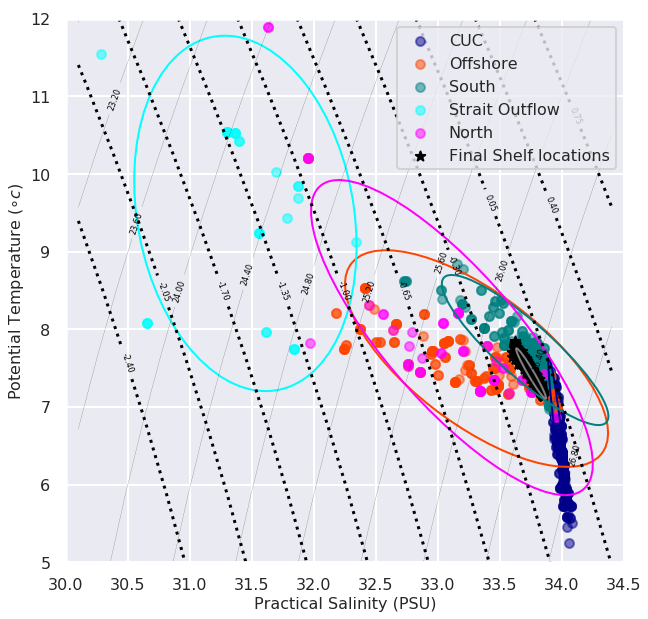

In [27]:
# colors = cmo.cm.phase(np.linspace(0, 1, 200))


# traj_sal_domain = traj_sal[traj_sal != 1.0100000202412861e+20]
# traj_tem_domain = traj_tem[traj_sal != 1.0100000202412861e+20]

# smin = np.nanmin(traj_sal_last)  - (0.01 * np.nanmin(traj_sal_last))
smin = 30
smax = np.nanmax(traj_sal_last)  + (0.01 * np.nanmax(traj_sal_last))
# tmin = np.nanmin(traj_tem_last) - (0.1 * np.nanmax(traj_tem_last))
tmin = 4
tmax = 12
# tmax = np.nanmax(traj_tem_last) + (0.1 * np.nanmax(traj_tem_last))
 
# Calculate how many gridcells we need in the x and y dimensions
xdim = int(round((smax-smin)/0.1+1,0))
ydim = int(round((tmax-tmin)+1,0))
 
# Create empty grid of zeros
dens_1 = np.empty((ydim,xdim))
spic_1 = np.empty((ydim,xdim))
SA = np.empty((xdim))
CT = np.empty((ydim)) 
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(1,ydim-1,ydim)+tmin
si = np.linspace(1,xdim-1,xdim)*0.1+smin
 
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        
        SA[i] = gsw.SA_from_SP(si[i], 0, np.mean(traj_lon), np.mean(traj_lat))

        CT[j] = gsw.CT_from_pt(si[i], ti[j])
        
        dens_1[j,i]=gsw.rho(SA[i],CT[j],0)
        
        spic_1[j,i] = gsw.spiciness0(SA[i],CT[j])
 
# Substract 1000 to convert to sigma-t
dens_1 = dens_1 - 1000;
 
# Plot data ***********************************************
fig1, ax = plt.subplots(1, 1, figsize=(10,10))
CS = ax.contour(si,ti,dens_1, np.arange(22.4,27,0.4), linestyles='dashed', linewidths = 0.2,colors='k')
CS1 = ax.contour(si,ti,spic_1,np.arange(-2.4,1,0.35), linestyles='dotted', colors='k')
plt.clabel(CS, fontsize=8, inline=1, fmt='%0.2f') # Label every second level
plt.clabel(CS1, fontsize=8, inline=1, fmt='%0.2f') # Label every second level



ax.scatter(traj_sal_final_cuc, traj_tem_final_cuc, s=80, alpha=0.5, c = 'darkblue', label = 'CUC')
sal_mean_cuc = np.mean(traj_sal_final_cuc)
tem_mean_cuc = np.mean(traj_tem_final_cuc)
cov_cuc = np.cov(traj_sal_final_cuc, traj_tem_final_cuc)
cuc_ell = get_cov_ellipse(cov_cuc, (sal_mean_cuc, tem_mean_cuc), 2,
                    ec='darkblue', fc = None)
cuc_ell.set_facecolor('none')
ax.add_artist(cuc_ell)




ax.scatter(traj_sal_final_off, traj_tem_final_off, s=80, alpha=0.5, c = 'orangered', label = 'Offshore')
sal_mean_off = np.mean(traj_sal_final_off)
tem_mean_off = np.mean(traj_tem_final_off)
cov_off = np.cov(traj_sal_final_off, traj_tem_final_off)
off_ell = get_cov_ellipse(cov_off, (sal_mean_off, tem_mean_off), 2,
                    ec='orangered', fc = None)
off_ell.set_facecolor('none')
ax.add_artist(off_ell)


traj_tem_final_north = traj_tem_final_north[traj_sal_final_north > 30]
traj_sal_final_north = traj_sal_final_north[traj_sal_final_north > 30]

ax.scatter(traj_sal_final_south, traj_tem_final_south, s=80, alpha=0.5, c= 'Teal', label = 'South')
sal_mean_south = np.mean(traj_sal_final_south)
tem_mean_south = np.mean(traj_tem_final_south)
cov_south = np.cov(traj_sal_final_south, traj_tem_final_south)
south_ell = get_cov_ellipse(cov_south, (sal_mean_south, tem_mean_south), 3,
                    ec='Teal', fc = None)
south_ell.set_facecolor('none')
ax.add_artist(south_ell)




# traj_tem_final_juan = traj_tem_final_juan[traj_sal_final_juan < 32.8]
# traj_sal_final_juan = traj_sal_final_juan[traj_sal_final_juan < 32.8]

ax.scatter(traj_sal_final_juan, traj_tem_final_juan, s=80, alpha=0.5, c = 'cyan', label = 'Strait Outflow')
sal_mean_juan = np.mean(traj_sal_final_juan)
tem_mean_juan = np.mean(traj_tem_final_juan)
cov_juan = np.cov(traj_sal_final_juan, traj_tem_final_juan)
juan_ell = get_cov_ellipse(cov_juan, (sal_mean_juan, tem_mean_juan), 2,
                    fc = None, ec='cyan')
juan_ell.set_facecolor('none')
ax.add_artist(juan_ell)




ax.scatter(traj_sal_final_north, traj_tem_final_north, s=80, alpha=0.5, c = 'Magenta', label = 'North')
sal_mean_north = np.mean(traj_sal_final_north)
tem_mean_north = np.mean(traj_tem_final_north)
cov_north = np.cov(traj_sal_final_north, traj_tem_final_north)
north_ell = get_cov_ellipse(cov_north, (sal_mean_north, tem_mean_north), 2,
                    ec='Magenta', fc = None)
north_ell.set_facecolor('none')
ax.add_artist(north_ell)

# traj_tem_final_local = traj_tem_final_local[traj_sal_final_local > 30]
# traj_sal_final_local = traj_sal_final_local[traj_sal_final_local > 30]

# ax.scatter(traj_sal_final_local, traj_tem_final_local, s=80, alpha=0.5, c = 'Gold', label = 'Local Water')
# sal_mean_local = np.mean(traj_sal_final_local)
# tem_mean_local = np.mean(traj_tem_final_local)
# cov_local = np.cov(traj_sal_final_local, traj_tem_final_local)
# local_ell = get_cov_ellipse(cov_local, (sal_mean_local, tem_mean_local), 2,
#                     ec='Gold', fc = None)
# local_ell.set_facecolor('none')
# ax.add_artist(local_ell)


traj_tem_init = traj_tem_init[traj_sal_init > 30]
traj_sal_init = traj_sal_init[traj_sal_init > 30]

ax.scatter(traj_sal_init, traj_tem_init, s=100, marker='*', c = 'k', label = "Final Shelf locations")#'chartreuse')
sal_mean_init = np.mean(traj_sal_init)
tem_mean_init = np.mean(traj_tem_init)
cov_init = np.cov(traj_sal_init, traj_tem_init)
init_ell = get_cov_ellipse(cov_init, (sal_mean_init, tem_mean_init), 2,
                    ec='gray', fc = None)
init_ell.set_facecolor('none')
ax.add_artist(init_ell)


ax.legend(loc = 'best', fontsize = 16)


 
ax.set_xlabel('Practical Salinity (PSU)', fontsize = 16)
ax.set_ylabel('Potential Temperature ($\circ c$)', fontsize = 16)
ax.tick_params(axis='both',labelsize =16)
ax.set_xlim(30,34.5)
ax.set_ylim(5,12)


# legend = ax.legend(loc='upper right', fancybox=True, framealpha=0.25)

(5, 12)

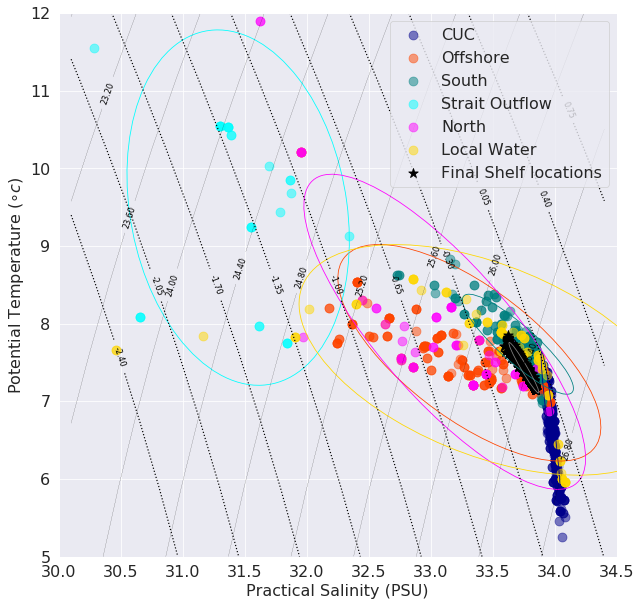

In [59]:
# colors = cmo.cm.phase(np.linspace(0, 1, 200))


# traj_sal_domain = traj_sal[traj_sal != 1.0100000202412861e+20]
# traj_tem_domain = traj_tem[traj_sal != 1.0100000202412861e+20]

# smin = np.nanmin(traj_sal_last)  - (0.01 * np.nanmin(traj_sal_last))
smin = 30
smax = np.nanmax(traj_sal_last)  + (0.01 * np.nanmax(traj_sal_last))
# tmin = np.nanmin(traj_tem_last) - (0.1 * np.nanmax(traj_tem_last))
tmin = 4
tmax = 12
# tmax = np.nanmax(traj_tem_last) + (0.1 * np.nanmax(traj_tem_last))
 
# Calculate how many gridcells we need in the x and y dimensions
xdim = int(round((smax-smin)/0.1+1,0))
ydim = int(round((tmax-tmin)+1,0))
 
# Create empty grid of zeros
dens_1 = np.empty((ydim,xdim))
spic_1 = np.empty((ydim,xdim))
SA = np.empty((xdim))
CT = np.empty((ydim)) 
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(1,ydim-1,ydim)+tmin
si = np.linspace(1,xdim-1,xdim)*0.1+smin
 
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        
        SA[i] = gsw.SA_from_SP(si[i], 0, np.mean(traj_lon), np.mean(traj_lat))

        CT[j] = gsw.CT_from_pt(si[i], ti[j])
        
        dens_1[j,i]=gsw.rho(SA[i],CT[j],0)
        
        spic_1[j,i] = gsw.spiciness0(SA[i],CT[j])
 
# Substract 1000 to convert to sigma-t
dens_1 = dens_1 - 1000;
 
# Plot data ***********************************************
fig1, ax = plt.subplots(1, 1, figsize=(10,10))
CS = ax.contour(si,ti,dens_1, np.arange(22.4,27,0.4), linestyles='dashed', linewidths = 0.2,colors='k')
CS1 = ax.contour(si,ti,spic_1,np.arange(-2.4,1,0.35), linestyles='dotted', colors='k')
plt.clabel(CS, fontsize=8, inline=1, fmt='%0.2f') # Label every second level
plt.clabel(CS1, fontsize=8, inline=1, fmt='%0.2f') # Label every second level



ax.scatter(traj_sal_final_cuc, traj_tem_final_cuc, s=80, alpha=0.5, c = 'darkblue', label = 'CUC')
sal_mean_cuc = np.mean(traj_sal_final_cuc)
tem_mean_cuc = np.mean(traj_tem_final_cuc)
cov_cuc = np.cov(traj_sal_final_cuc, traj_tem_final_cuc)
cuc_ell = get_cov_ellipse(cov_cuc, (sal_mean_cuc, tem_mean_cuc), 2,
                    ec='darkblue', fc = None)
cuc_ell.set_facecolor('none')
ax.add_artist(cuc_ell)




ax.scatter(traj_sal_final_off, traj_tem_final_off, s=80, alpha=0.5, c = 'orangered', label = 'Offshore')
sal_mean_off = np.mean(traj_sal_final_off)
tem_mean_off = np.mean(traj_tem_final_off)
cov_off = np.cov(traj_sal_final_off, traj_tem_final_off)
off_ell = get_cov_ellipse(cov_off, (sal_mean_off, tem_mean_off), 2,
                    ec='orangered', fc = None)
off_ell.set_facecolor('none')
ax.add_artist(off_ell)


traj_tem_final_north = traj_tem_final_north[traj_sal_final_north > 30]
traj_sal_final_north = traj_sal_final_north[traj_sal_final_north > 30]

ax.scatter(traj_sal_final_south, traj_tem_final_south, s=80, alpha=0.5, c= 'Teal', label = 'South')
sal_mean_south = np.mean(traj_sal_final_south)
tem_mean_south = np.mean(traj_tem_final_south)
cov_south = np.cov(traj_sal_final_south, traj_tem_final_south)
south_ell = get_cov_ellipse(cov_south, (sal_mean_south, tem_mean_south), 2,
                    ec='Teal', fc = None)
south_ell.set_facecolor('none')
ax.add_artist(south_ell)




# traj_tem_final_juan = traj_tem_final_juan[traj_sal_final_juan < 32.8]
# traj_sal_final_juan = traj_sal_final_juan[traj_sal_final_juan < 32.8]

ax.scatter(traj_sal_final_juan, traj_tem_final_juan, s=80, alpha=0.5, c = 'cyan', label = 'Strait Outflow')
sal_mean_juan = np.mean(traj_sal_final_juan)
tem_mean_juan = np.mean(traj_tem_final_juan)
cov_juan = np.cov(traj_sal_final_juan, traj_tem_final_juan)
juan_ell = get_cov_ellipse(cov_juan, (sal_mean_juan, tem_mean_juan), 2,
                    fc = None, ec='cyan')
juan_ell.set_facecolor('none')
ax.add_artist(juan_ell)




ax.scatter(traj_sal_final_north, traj_tem_final_north, s=80, alpha=0.5, c = 'Magenta', label = 'North')
sal_mean_north = np.mean(traj_sal_final_north)
tem_mean_north = np.mean(traj_tem_final_north)
cov_north = np.cov(traj_sal_final_north, traj_tem_final_north)
north_ell = get_cov_ellipse(cov_north, (sal_mean_north, tem_mean_north), 2,
                    ec='Magenta', fc = None)
north_ell.set_facecolor('none')
ax.add_artist(north_ell)

traj_tem_final_local = traj_tem_final_local[traj_sal_final_local > 30]
traj_sal_final_local = traj_sal_final_local[traj_sal_final_local > 30]

ax.scatter(traj_sal_final_local, traj_tem_final_local, s=80, alpha=0.5, c = 'Gold', label = 'Local Water')
sal_mean_local = np.mean(traj_sal_final_local)
tem_mean_local = np.mean(traj_tem_final_local)
cov_local = np.cov(traj_sal_final_local, traj_tem_final_local)
local_ell = get_cov_ellipse(cov_local, (sal_mean_local, tem_mean_local), 2,
                    ec='Gold', fc = None)
local_ell.set_facecolor('none')
ax.add_artist(local_ell)


traj_tem_init = traj_tem_init[traj_sal_init > 30]
traj_sal_init = traj_sal_init[traj_sal_init > 30]

ax.scatter(traj_sal_init, traj_tem_init, s=100, marker='*', c = 'k', label = "Final Shelf locations")#'chartreuse')
sal_mean_init = np.mean(traj_sal_init)
tem_mean_init = np.mean(traj_tem_init)
cov_init = np.cov(traj_sal_init, traj_tem_init)
init_ell = get_cov_ellipse(cov_init, (sal_mean_init, tem_mean_init), 2,
                    ec='gray', fc = None)
init_ell.set_facecolor('none')
ax.add_artist(init_ell)


ax.legend(loc = 'best', fontsize = 16)


 
ax.set_xlabel('Practical Salinity (PSU)', fontsize = 16)
ax.set_ylabel('Potential Temperature ($\circ c$)', fontsize = 16)
ax.tick_params(axis='both',labelsize =16)
ax.set_xlim(30,34.5)
ax.set_ylim(5,12)


# legend = ax.legend(loc='upper right', fancybox=True, framealpha=0.25)

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


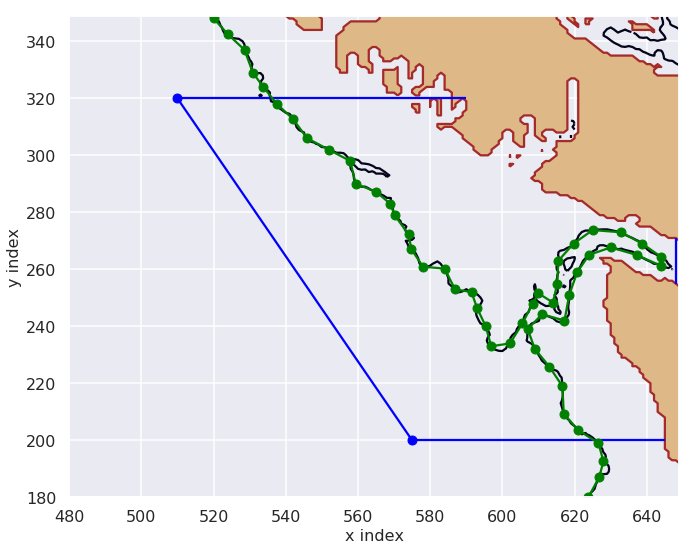

In [13]:



bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

Z = bathy.variables['Bathymetry']


lon = bathy['nav_lon'][...]
lat = bathy['nav_lat'][...]




cmap=plt.cm.get_cmap('nipy_spectral')
#     cmap = plt.cm.get_cmap('gist_rainbow')
cmap.set_bad('#8b7765')
cmin = 0
cmax = 300

import matplotlib as mpl
#     norm = mpl.colors.Normalize(vmin=cmin,vmax=cmax)

fig, ax = plt.subplots(1, 1, figsize=(10,8)); ax.grid()
CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(200,210,10))
# CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], level = [0,100,200,500,1000])
# CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=12)
# CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)




ax.set_xlabel('x index', fontsize =16)
ax.set_ylabel('y index', fontsize = 16)
ax.tick_params(axis='both',labelsize =16)


# ax.set_title('Particle track at depth \u2248 {d:.1f} m'.format(d = np.abs(traj_depth[0,part])), fontsize =16)
ax.legend(loc = 'best')

viz_tools.plot_land_mask(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='burlywood')
viz_tools.plot_coastline(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='brown')

x = [510,575]
y = [320,200]
ax.plot(x, y , 'bo-')

xmin = x_wcvi_slice[np.int(np.min(np.unique(x1)))]-1
xmax = x_wcvi_slice[np.int(np.max(np.unique(x1)))]-1


ymin = y_wcvi_slice[np.int(np.min(np.unique(y1)))]-1
ymax  = y_wcvi_slice[np.int(np.max(np.unique(y1)))]-1


# x_1 = [xmin, xmax]
# y_1 = [ymin, ymin]
# ax.plot(x_1, y_1 , 'go-')

# x_2 = [xmin, xmax]
# y_2 = [ymax, ymax]
# ax.plot(x_2, y_2 , 'go-')

# x_3 = [xmin, xmin]
# y_3 = [ymin, ymax]
# ax.plot(x_3, y_3 , 'go-')

# x_4 = [xmax, xmax]
# y_4 = [ymin, ymax]
# ax.plot(x_4, y_4 , 'go-')

ax.vlines(x = 648, ymin = 255, ymax = 271, color = 'blue')

# ax.get_legend().remove()
# lon_LB08 = -125.4775
# lat_LB08 = 48.4217

# j, i = geo_tools.find_closest_model_point(lon_LB08,lat_LB08,\
#                                           lon,lat,grid='NEMO',tols=\
#                                           {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
#                                            'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}}) 

# ax.scatter(i,j, marker = 'o', c = 'red', s = 300, linewidths=100, label = 'Eddy region')

ax.hlines(y = 200, xmin = 575, xmax=645, color = 'b')
ax.hlines(y = 320, xmin = 510, xmax=590, color = 'b')
ax.grid()

contour = CS.collections[0]
vs = contour.get_paths()[0].vertices


vert = CS.collections[0].get_paths()[0].vertices

x_200_wcvi = vert[:,0]
y_200_wcvi = vert[:,1]

# for i in range(0, len(x_200_wcvi), 10):
#     plt.plot(x_200_wcvi[i:i+1], y_200_wcvi[i:i+1], 'mo-')
    

Line = ax.plot(x_200_wcvi[::10], y_200_wcvi[::10], 'go-')
fig.tight_layout()





In [25]:
IK = find_index(500)

PK = find_index(1000)

LK = find_index(1500)

JK = find_index(2000)

LI = find_index(2500)

LP = find_index(3000)

MN = find_index(3500)

total_indi_low = np.concatenate((IK,PK,LK,JK,LI, LP, MN))

In [26]:
np.unique(total_indi_low).shape

(1114,)

In [27]:
cross_index_low = []


for i in np.unique(total_indi_low):

    if ((np.max(-traj_depth[:,i]) >= 200) & (np.min(-traj_depth[:,i]) < 200)) == True:
        
        cross_index_low = np.append(arr=cross_index_low, values=i)
        


In [28]:
percentage = cross_index_low.shape[0]/final_age_days.shape[0]

print(percentage)

0.5643044619422573


###    56.4 Percent of the Eddy water arrives at the locations by upwelling (our definition)

In [31]:
time_index_low = np.empty_like(cross_index_low)

for k in np.arange(cross_index_low.shape[0]):
    time_index_low[k] = np.min(np.argwhere(-traj_depth[:,cross_index_low[k].astype(int)] > 200))
    
    

In [32]:
np.save(file='/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/numpy_arrays_saved/cross_index_accurate_iso_low_two_more_months.npy', \
        arr=cross_index_low)

np.save(file='/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/numpy_arrays_saved/time_index_accurate_iso_low_two_more_months.npy',\
        arr=time_index_low)


In [22]:
cross_index_low = np.load(file='/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/numpy_arrays_saved/cross_index_accurate_iso_low_two_more_months.npy')

time_index_low  = np.load(file='/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/numpy_arrays_saved/time_index_accurate_iso_low_two_more_months.npy')

In [23]:
x_200_total = np.load(file='/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/numpy_arrays_saved/\
x_200_total_eddy_water_acc_iso_two_more_months.npy')

y_200_total  = np.load(file='/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/numpy_arrays_saved/\
y_200_total_eddy_water_acc_iso_iso_two_more_months.npy')

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


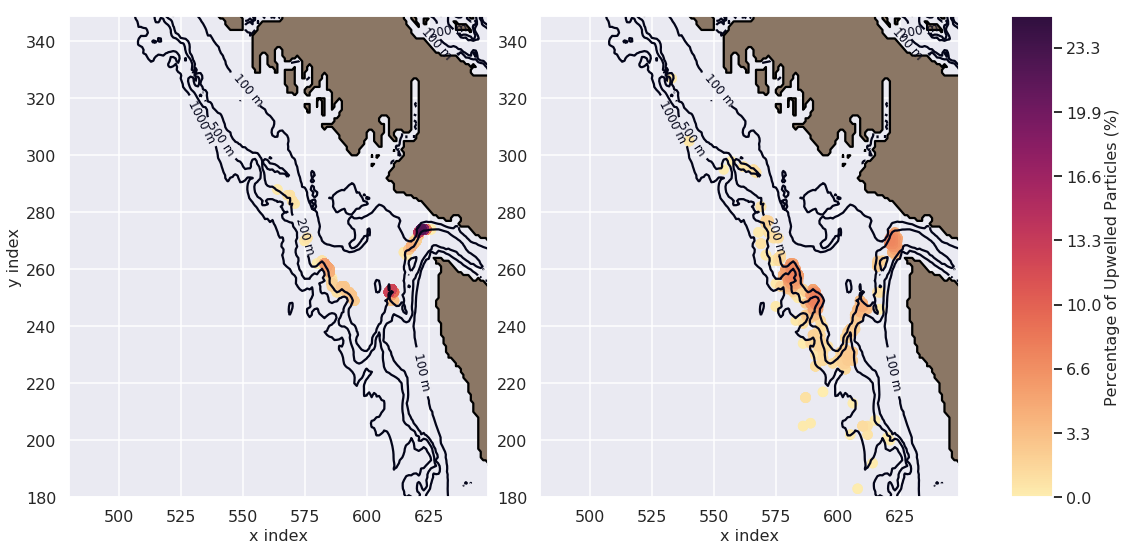

In [38]:
from scipy.interpolate import interpn
from mpl_toolkits.axes_grid1 import make_axes_locatable





cmap = plt.get_cmap(cmo.cm.matter)


bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

Z = bathy.variables['Bathymetry']


lon = bathy['nav_lon'][...]
lat = bathy['nav_lat'][...]




# cmap=plt.cm.get_cmap('nipy_spectral')
# cmap = plt.cm.get_cmap('gist_rainbow_r')
cmap.set_bad('#8b7765')
vmin = 0
vmax = 150

import matplotlib as mpl

gridspec = {'width_ratios': [1, 1, 0.1]}

fig, ax = plt.subplots(1, 3, figsize=(16, 8), gridspec_kw=gridspec)


# fig, (ax1,ax) = plt.subplots(1, 2, figsize=(12,8), sharey=True); 

ax[0].grid()

CS1 = ax[0].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,110,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)


CS1 = ax[0].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(200,210,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

CS1 = ax[0].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(1000,1010,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

CS1 = ax[0].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(500,510,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)



ax[0].set_xlabel('x index', fontsize =16)
ax[0].set_ylabel('y index', fontsize = 16)
ax[0].tick_params(axis='both',labelsize =16)

ax[0].legend(loc = 'best')

viz_tools.plot_land_mask(ax[0], bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='#8b7765')
viz_tools.plot_coastline(ax[0], bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='k')


lon_LB08 = -125.4775
lat_LB08 = 48.4217

j, i = geo_tools.find_closest_model_point(lon_LB08,lat_LB08,\
                                          lon,lat,grid='NEMO',tols=\
                                          {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                           'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}}) 


q = density_scatter(x_200_total[~np.isnan(y_200_total)], y_200_total[~np.isnan(y_200_total)], ax= ax[0], bins = [30,30], cmap = cmap , vmin = vmin, vmax = vmax)

ax[0].grid()


# Line = ax[0].plot(x_200_wcvi[::1], y_200_wcvi[::1], 'k-')



ax[1].grid()


CS1 = ax[1].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,110,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

CS1 = ax[1].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(200,210,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

CS1 = ax[1].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(1000,1010,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

CS1 = ax[1].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(500,510,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)




ax[1].set_xlabel('x index', fontsize =16)
# ax.set_ylabel('y index', fontsize = 16)
ax[1].tick_params(axis='both',labelsize =16)



ax[1].legend(loc = 'best')

viz_tools.plot_land_mask(ax[1], bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='#8b7765')
viz_tools.plot_coastline(ax[1], bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='k')



# ax.vlines(x = 635, ymin = 261, ymax = 279, color = 'blue')

# ax.get_legend().remove()
lon_LB08 = -125.4775
lat_LB08 = 48.4217

j, i = geo_tools.find_closest_model_point(lon_LB08,lat_LB08,\
                                          lon,lat,grid='NEMO',tols=\
                                          {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                           'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}}) 


x_up = []
y_up = []

for k in np.arange(cross_index_low.shape[0]):
    y_p, x_p = geo_tools.find_closest_model_point(traj_lon[time_index_low[k].astype(int), cross_index_low[k].astype(int)],\
                                          traj_lat[time_index_low[k].astype(int), cross_index_low[k].astype(int)],\
                                          lon,lat,grid='NEMO',tols=\
                                          {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                           'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}}) 
    
    y_up = np.append(arr=y_up, values=y_p)
    x_up = np.append(arr=x_up, values=x_p)


q = density_scatter(x_up, y_up, ax= ax[1], bins = [30,30], cmap = cmap , vmin = vmin, vmax = vmax)

ax[1].grid()


# Line = ax[1].plot(x_200_wcvi[::1], y_200_wcvi[::1], 'm-')



m = cm.ScalarMappable(cmap=cmap)
m.set_array(q)
m.set_clim(vmin,vmax)
# plt.colorbar(m, cax=ax[2])

cbar = fig.colorbar(m, cax=ax[2])#, format=ticker.FuncFormatter(fmt))


cbar.ax.set_yticklabels(np.around(a=np.linspace(start=(cbar.vmin/cross_index_low.shape[0])*100, \
                                    stop=(cbar.vmax/cross_index_low.shape[0])*100, num=8), decimals = 1))

cbar.set_label(label='Percentage of Upwelled Particles (%)', fontsize = 16)
cbar.ax.tick_params(labelsize=16)

fig.tight_layout(h_pad=0.01,w_pad=0.01)



In [33]:
zlevels = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_20140915_00001440_grid_T.nc').variables['deptht'][:32]
y_wcvi_slice = np.array(np.arange(180,350))
x_wcvi_slice = np.array(np.arange(480,650))


bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

Z = bathy.variables['Bathymetry']


lon = bathy['nav_lon'][...]
lat = bathy['nav_lat'][...]



nc_file = nc.Dataset('/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/\
accurate_isopycnals_south_outer_shelf__water_particles_two_months_more.nc')

In [34]:


init_x = nc_file.variables['init_x']
init_z = nc_file.variables['init_z']
init_age = nc_file.variables['init_age']

traj_depth = nc_file.variables['traj_depth'][:]
traj_lon   = nc_file.variables['traj_lon'][:]
traj_lat   = nc_file.variables['traj_lat'][:]
traj_rho   = nc_file.variables['traj_dens'][:]
traj_tem   = nc_file.variables['traj_temp'][:]
traj_sal   = nc_file.variables['traj_salt'][:]
traj_time  = nc_file.variables['traj_time']


final_age = nc_file.variables['final_age']


# lon1=nc_file.variables['traj_lon'][:]
# lat1=nc_file.variables['traj_lat'][:]
# dep1=nc_file.variables['traj_depth'][:]
x1=nc_file.variables['init_x'][:]
y1=nc_file.variables['init_y'][:]
t1=nc_file.variables['traj_time'][:]

x_high = x1
y_high = y1

x2=nc_file.variables['final_x'][:]
y2=nc_file.variables['final_y'][:]


final_z = nc_file.variables['final_z'][:]

final_age_days = final_age[:]/(3600)

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type


In [35]:
x_final = []
y_final = []


for i in np.arange(x2.shape[0]):
    x_final = np.append(arr=x_final,values=x_wcvi_slice[np.int(np.rint(x2[i]))-1])
    y_final = np.append(arr=y_final,values=y_wcvi_slice[np.int(np.rint(y2[i]))-1])

In [36]:
x_final.shape

(363,)

In [37]:
x = [510,575]
y = [320,200]


coefficients = np.polyfit(x, y, 1)

x_final_off = np.arange(x[0],x[1])
polynomial = np.poly1d(coefficients)
y_final_off = np.rint(polynomial(x_final_off))

p1= (x[0],y[0])
p1 = np.asarray(p1)
p2 = (x[1], y[1])
p2 = np.asarray(p2)



d = np.empty_like(x_final)

off_ind = []


for r in np.arange(x_final.shape[0]):

    p3 = (x_final[r], y_final[r])
    p3 = np.asarray(p3)
    d[r] =np.cross(p2-p1,p3-p1)/np.linalg.norm(p2-p1)
    
    if ((d[r] < 0) & (x_final[r] < 575)):
        off_ind = np.append(arr=off_ind, values=np.int(r))

In [38]:
num_north = np.round(a=final_age[(x_final < 580) & (y_final > 300)].shape[0]/final_z.shape[0], decimals=3)

north_percent = 100*num_north

print(north_percent)

num_cuc = np.round(a=np.where(final_z[((x_final < 630) & (y_final < 200)) & \
                                      ((x_final > 580) & (y_final < 200))]>26.3)[0].shape[0]/final_z.shape[0], decimals = 3)

cuc_percent = 100*num_cuc

print(cuc_percent)

num_south = np.round(a=np.where(final_z[((x_final < 630) & (y_final < 200)) & \
                                      ((x_final > 580) & (y_final < 200))]<=26.3)[0].shape[0]/final_z.shape[0], decimals = 3)

south_percent = 100*num_south

print(south_percent)

### Bigger box
x = [510,575]
y = [320,200]


coefficients = np.polyfit(x, y, 1)

x_final_off = np.arange(x[0],x[1])
polynomial = np.poly1d(coefficients)
y_final_off = np.rint(polynomial(x_final_off))

num_off = off_ind.shape[0]/final_z.shape[0]
off_percent = np.round(a=100*num_off, decimals=1)

print(off_percent)

num_juan = np.round(a=np.where((x_final > 648))[0].shape[0]/final_z.shape[0], decimals=3)

juan_percent = num_juan*100

print(juan_percent)

6.3
28.4
33.3
22.0
6.6


In [39]:
cuc_percent_high = cuc_percent
juan_percent_high = juan_percent
north_percent_high = north_percent
south_percent_high = south_percent
off_percent_high = off_percent



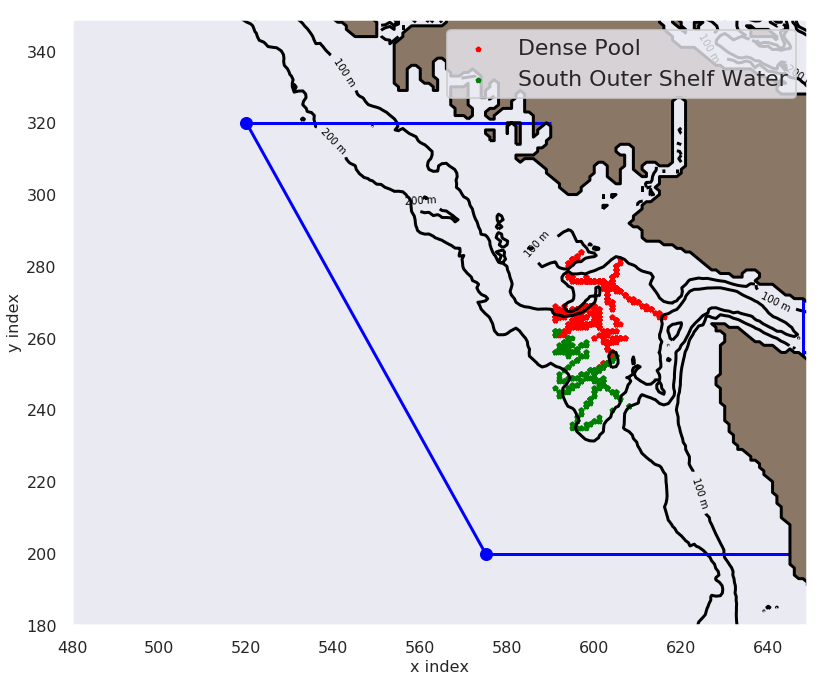

In [40]:
bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

Z = bathy.variables['Bathymetry']


lon = bathy['nav_lon'][...]
lat = bathy['nav_lat'][...]






import matplotlib as mpl
#     norm = mpl.colors.Normalize(vmin=cmin,vmax=cmax)

fig, ax = plt.subplots(1, 1, figsize=(12,10)); 
ax.grid()

CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,110,10),colors='black')
CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(200,210,10),colors='black')
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=10)
CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=10)

x = [520,575]
y = [320,200]
ax.plot(x, y , 'bo-')


ax.hlines(y = 200, xmin = 575, xmax=645, color = 'b')
ax.hlines(y = 320, xmin = 520, xmax=590, color = 'b')
ax.grid()

# axins = inset_axes(ax, width="75%", height="75%",
#                    bbox_to_anchor=(.085, .1, .5, .5),
#                    bbox_transform=ax.transAxes, loc=3)
# axins.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False)

# axins.tick_params(
#     axis='y',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False)


ax.scatter(x_wcvi_slice[x_low[:].astype(int)-1],y_wcvi_slice[y_low[:].astype(int)-1], marker = '*', c = 'red', \
           s = 10, linewidths=3, label = 'Dense Pool')


ax.scatter(x_wcvi_slice[x_high[:].astype(int)-1],y_wcvi_slice[y_high[:].astype(int)-1], marker = '*', c = 'green', \
           s = 10, linewidths=3, label = 'South Outer Shelf Water')

    

ax.set_xlabel('x index', fontsize =16)
ax.set_ylabel('y index', fontsize = 16)
ax.tick_params(axis='both',labelsize =16)

# axins.axis('equal') 
ax.vlines(x = 648, ymin = 255, ymax = 271, color = 'blue')


# ax.set_title('Particle track at depth \u2248 {d:.1f} m'.format(d = np.abs(traj_depth[0,part])), fontsize =16)
ax.legend(loc = 'best')

viz_tools.plot_land_mask(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='#8b7765')
viz_tools.plot_coastline(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='black')

# N = 2

# local_percent_low = 100 - (cuc_percent_low + juan_percent_low + north_percent_low + south_percent_low +\
#                           off_percent_low)
# local_percent_high = 100 - (cuc_percent_high + juan_percent_high + north_percent_high + south_percent_high +\
#                           off_percent_high)

# CUC   = (cuc_percent_low, cuc_percent_high)
# OFF   = [off_percent_low, off_percent_high]
# NORTH = [north_percent_low, north_percent_high]
# SOUTH = [south_percent_low, south_percent_high]
# JUAN  = [juan_percent_low, juan_percent_high]
# LOCAl = [local_percent_low, local_percent_high]


# ind = np.arange(N) 
# barWidth = 0.15   

# # Set position of bar on X axis
# r1 = np.arange(len(CUC))
# r2 = [x + barWidth for x in r1]
# r3 = [x + barWidth for x in r2]
# r4 = [x + barWidth for x in r3]
# r5 = [x + barWidth for x in r4]
# r6 = [x + barWidth for x in r5]

# axins.bar(r5, CUC, width=barWidth, color = 'darkblue', label='CUC')
# axins.bar(r3, OFF, width=barWidth, color = 'orangered',  label='Offshore')
# axins.bar(r1,  JUAN, width=barWidth, color = 'cyan', label='Strait Outflow')
# axins.bar(r4, SOUTH, width=barWidth, color = 'teal', label='South')
# axins.bar(r2, NORTH, width=barWidth, color = 'magenta', label='North')
# axins.bar(r6, LOCAl, width=barWidth, color = 'brown', label='Local water')

# axins.set_ylabel('Percentage')
# # plt.title('For all the')
# axins.set_xticks((barWidth, 1+ barWidth, 2+ barWidth))
# axins.set_xticklabels(('Eddy Water', 'South Outer-Shelf'))

# # ax.set_xticks([r + barWidth for r in range(len(CUC))], ['Top 21m', '21 till 65m', '65 till 155m'])
# axins.legend(loc='best', bbox_to_anchor=(-0.08, 1.5, .5, .5), fancybox = False)

ax.grid()

fig.tight_layout()

In [41]:
sns.set_context('talk')

<bound method _AxesBase.grid of <matplotlib.axes._subplots.AxesSubplot object at 0x7f18c80dcc50>>

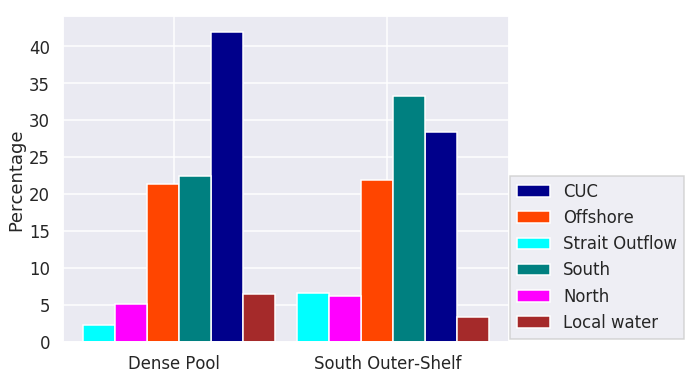

In [37]:
N = 2

local_percent_low = 100 - (cuc_percent_low + juan_percent_low + north_percent_low + south_percent_low +\
                          off_percent_low)
local_percent_high = 100 - (cuc_percent_high + juan_percent_high + north_percent_high + south_percent_high +\
                          off_percent_high)

CUC   = (cuc_percent_low, cuc_percent_high)
OFF   = [off_percent_low, off_percent_high]
NORTH = [north_percent_low, north_percent_high]
SOUTH = [south_percent_low, south_percent_high]
JUAN  = [juan_percent_low, juan_percent_high]
LOCAl = [local_percent_low, local_percent_high]


ind = np.arange(N) 
barWidth = 0.15   

# Set position of bar on X axis
r1 = np.arange(len(CUC))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]

fig, ax = plt.subplots(1, 1, figsize=(8,6))

ax.bar(r5, CUC, width=barWidth, color = 'darkblue', label='CUC')
ax.bar(r3, OFF, width=barWidth, color = 'orangered',  label='Offshore')
ax.bar(r1,  JUAN, width=barWidth, color = 'cyan', label='Strait Outflow')
ax.bar(r4, SOUTH, width=barWidth, color = 'teal', label='South')
ax.bar(r2, NORTH, width=barWidth, color = 'magenta', label='North')
ax.bar(r6, LOCAl, width=barWidth, color = 'brown', label='Local water')

ax.set_ylabel('Percentage')
# plt.title('For all the')
ax.set_xticks((0.2+barWidth, 1.2+ barWidth))
ax.set_xticklabels(('Dense Pool', 'South Outer-Shelf'))

# ax.set_xticks([r + barWidth for r in range(len(CUC))], ['Top 21m', '21 till 65m', '65 till 155m'])
ax.legend(loc='best', bbox_to_anchor=(.91, 0.035, .5, .5), fancybox = False)
ax.grid

<bound method _AxesBase.grid of <matplotlib.axes._subplots.AxesSubplot object at 0x7f1b180483c8>>

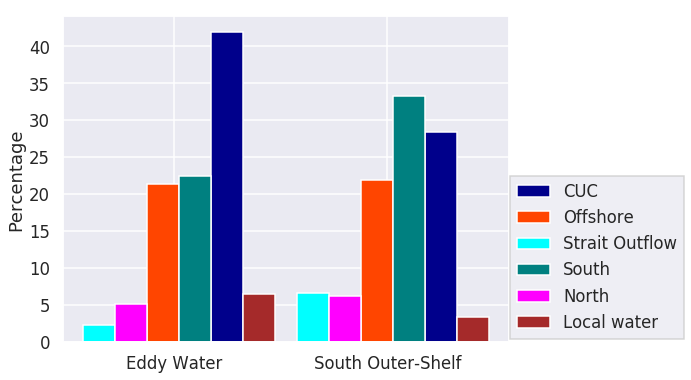

In [20]:
N = 2

local_percent_low = 100 - (cuc_percent_low + juan_percent_low + north_percent_low + south_percent_low +\
                          off_percent_low)
local_percent_high = 100 - (cuc_percent_high + juan_percent_high + north_percent_high + south_percent_high +\
                          off_percent_high)

CUC   = (cuc_percent_low, cuc_percent_high)
OFF   = [off_percent_low, off_percent_high]
NORTH = [north_percent_low, north_percent_high]
SOUTH = [south_percent_low, south_percent_high]
JUAN  = [juan_percent_low, juan_percent_high]
LOCAl = [local_percent_low, local_percent_high]


ind = np.arange(N) 
barWidth = 0.15   

# Set position of bar on X axis
r1 = np.arange(len(CUC))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]

fig, ax = plt.subplots(1, 1, figsize=(8,6))

ax.bar(r5, CUC, width=barWidth, color = 'darkblue', label='CUC')
ax.bar(r3, OFF, width=barWidth, color = 'orangered',  label='Offshore')
ax.bar(r1,  JUAN, width=barWidth, color = 'cyan', label='Strait Outflow')
ax.bar(r4, SOUTH, width=barWidth, color = 'teal', label='South')
ax.bar(r2, NORTH, width=barWidth, color = 'magenta', label='North')
ax.bar(r6, LOCAl, width=barWidth, color = 'brown', label='Local water')

ax.set_ylabel('Percentage')
# plt.title('For all the')
ax.set_xticks((0.2+barWidth, 1.2+ barWidth))
ax.set_xticklabels(('Eddy Water', 'South Outer-Shelf'))

# ax.set_xticks([r + barWidth for r in range(len(CUC))], ['Top 21m', '21 till 65m', '65 till 155m'])
ax.legend(loc='best', bbox_to_anchor=(.91, 0.035, .5, .5), fancybox = False)
ax.grid

In [42]:
max_life_ind = np.array(np.where(final_age_days == np.max(final_age_days))[0])

off_ind   = off_ind
north_ind = np.where([(x_final < 580) & (y_final > 300)])[1]
south_ind = []
cuc_ind   = []


ind_all_south  = np.where(((x_final < 630) & (y_final < 200)) & \
                                      ((x_final > 580) & (y_final < 200)))[0]

for k in ind_all_south:
    if final_z[k] <= 26.3:
        south_ind = np.append(arr=south_ind, values= k)
        
    if final_z[k] > 26.3:
        cuc_ind = np.append(arr=cuc_ind, values=k)
        

juan_ind =  np.where((x_final > 648))[0]

non_local_ind = np.concatenate((off_ind, north_ind, south_ind, cuc_ind, juan_ind))

ind_local = np.setdiff1d(max_life_ind, np.unique(non_local_ind, return_index= False).astype(int), assume_unique=True)

# off_ind/

# ind_local = np.setdiff1d(max_life_ind, off_ind, assume_unique= True)

x_local_low_actual = x2[ind_local]
y_local_low_actual = y2[ind_local]

depth_local_low_actual = -traj_depth_last[ind_local]


In [43]:
count_ind = np.concatenate((ind_local, np.unique(non_local_ind, return_index= False).astype(int)))

count_ind.shape[0]/final_z.shape[0]

0.9972451790633609

In [44]:
traj_tem_last   = np.empty_like(final_age_days)
traj_sal_last   = np.empty_like(final_age_days)
traj_rho_last   = np.empty_like(final_age_days)
traj_depth_last = np.empty_like(final_age_days)


traj_tem_init   = np.empty_like(final_age_days)
traj_sal_init   = np.empty_like(final_age_days)
traj_rho_init   = np.empty_like(final_age_days)
traj_depth_init = np.empty_like(final_age_days)

for r in np.arange(traj_tem_last.shape[0]):
    traj_tem_last[r]  =  traj_tem[np.int(final_age_days[r]),r]
    traj_sal_last[r]  =  traj_sal[np.int(final_age_days[r]),r]
    traj_rho_last[r]  =  traj_rho[np.int(final_age_days[r]),r]
    traj_depth_last[r] = traj_depth[np.int(final_age_days[r]),r]
    
    traj_tem_init[r]  =  traj_tem[0,r]
    traj_sal_init[r]  =  traj_sal[0,r]
    traj_rho_init[r]  =  traj_rho[0,r]    
    traj_depth_init[r]=  traj_depth[0,r] 
    

In [45]:

traj_tem_final_cuc = traj_tem_last[cuc_ind.astype(int)]
traj_sal_final_cuc = traj_sal_last[cuc_ind.astype(int)]
traj_rho_final_cuc = traj_rho_last[cuc_ind.astype(int)]
traj_depth_final_cuc = traj_depth_last[cuc_ind.astype(int)]
traj_days_final_cuc = final_age_days[cuc_ind.astype(int)]/24



traj_tem_final_north = traj_tem_last[north_ind.astype(int)]
traj_sal_final_north = traj_sal_last[north_ind.astype(int)]
traj_rho_final_north = traj_rho_last[north_ind.astype(int)]
traj_depth_final_north = traj_depth_last[north_ind.astype(int)]
traj_days_final_north = final_age_days[north_ind.astype(int)]/24



traj_tem_final_south   = traj_tem_last[south_ind.astype(int)]
traj_sal_final_south   = traj_sal_last[south_ind.astype(int)]
traj_rho_final_south   = traj_rho_last[south_ind.astype(int)]
traj_depth_final_south = traj_depth_last[south_ind.astype(int)]
traj_days_final_south  = final_age_days[south_ind.astype(int)]/24


traj_tem_final_juan = traj_tem_last[juan_ind.astype(int)]
traj_sal_final_juan = traj_sal_last[juan_ind.astype(int)]
traj_rho_final_juan = traj_rho_last[juan_ind.astype(int)]
traj_depth_final_juan = traj_depth_last[juan_ind.astype(int)]
traj_days_final_juan = final_age_days[juan_ind.astype(int)]/24


traj_tem_final_local = traj_tem_last[ind_local.astype(int)]
traj_sal_final_local = traj_sal_last[ind_local.astype(int)]
traj_rho_final_local = traj_rho_last[ind_local.astype(int)]
traj_depth_final_local = traj_depth_last[ind_local.astype(int)]
traj_days_final_local = final_age_days[ind_local.astype(int)]/24




x = [510,575]
y = [320,200]

coefficients = np.polyfit(x, y, 1)
x_final_off = np.arange(x[0],x[1])
polynomial = np.poly1d(coefficients)
y_final_off = np.rint(polynomial(x_final_off))

traj_tem_final_off = []
traj_sal_final_off = []
traj_rho_final_off = []
traj_depth_final_off = []
traj_days_final_off = []

for l in np.arange(off_ind.shape[0]):

    traj_depth_final_off = np.append(arr=traj_depth_final_off, values=traj_depth_last[np.int(off_ind[l])])
    traj_days_final_off = np.append(arr=traj_days_final_off, values=final_age_days[np.int(off_ind[l])]/24)
    traj_rho_final_off   = np.append(arr=traj_rho_final_off, values=traj_rho_last[np.int(off_ind[l])])
    traj_tem_final_off   = np.append(arr=traj_tem_final_off, values=traj_tem_last[np.int(off_ind[l])])
    traj_sal_final_off   = np.append(arr=traj_sal_final_off, values=traj_sal_last[np.int(off_ind[l])])


In [46]:
pressure_loc_cuc = np.empty_like(traj_depth_final_cuc)
SA_loc_cuc       = np.empty_like(traj_depth_final_cuc)
CT_loc_cuc       = np.empty_like(traj_depth_final_cuc)
spic_loc_cuc     = np.empty_like(traj_depth_final_cuc)



for i in np.arange(traj_depth_final_cuc.shape[0]):
    
    pressure_loc_cuc[i] = gsw.p_from_z(traj_depth_final_cuc[i],np.mean(traj_lat))
    
    SA_loc_cuc[i] = gsw.SA_from_SP(traj_sal_final_cuc[i], pressure_loc_cuc[i], np.mean(traj_lon), np.mean(traj_lat))
    
    CT_loc_cuc[i] = gsw.CT_from_pt(traj_sal_final_cuc[i], traj_tem_final_cuc[i])
    
    spic_loc_cuc[i] = gsw.spiciness0(SA_loc_cuc[i], CT_loc_cuc[i])
    
pressure_loc_off = np.empty_like(traj_depth_final_off)
SA_loc_off       = np.empty_like(traj_depth_final_off)
CT_loc_off       = np.empty_like(traj_depth_final_off)
spic_loc_off     = np.empty_like(traj_depth_final_off)



for i in np.arange(traj_depth_final_off.shape[0]):
    
    pressure_loc_off[i] = gsw.p_from_z(traj_depth_final_off[i],np.mean(traj_lat))
    
    SA_loc_off[i] = gsw.SA_from_SP(traj_sal_final_off[i], pressure_loc_off[i], np.mean(traj_lon), np.mean(traj_lat))
    
    CT_loc_off[i] = gsw.CT_from_pt(traj_sal_final_off[i], traj_tem_final_off[i])
    
    spic_loc_off[i] = gsw.spiciness0(SA_loc_off[i], CT_loc_off[i])
    
pressure_loc_south = np.empty_like(traj_depth_final_south)
SA_loc_south       = np.empty_like(traj_depth_final_south)
CT_loc_south       = np.empty_like(traj_depth_final_south)
spic_loc_south     = np.empty_like(traj_depth_final_south)



for i in np.arange(traj_depth_final_south.shape[0]):
    
    pressure_loc_south[i] = gsw.p_from_z(traj_depth_final_south[i],np.mean(traj_lat))
    
    SA_loc_south[i] = gsw.SA_from_SP(traj_sal_final_south[i], pressure_loc_south[i], np.mean(traj_lon), np.mean(traj_lat))
    
    CT_loc_south[i] = gsw.CT_from_pt(traj_sal_final_south[i], traj_tem_final_south[i])
    
    spic_loc_south[i] = gsw.spiciness0(SA_loc_south[i], CT_loc_south[i])
    
pressure_loc_north= np.empty_like(traj_depth_final_north)
SA_loc_north       = np.empty_like(traj_depth_final_north)
CT_loc_north       = np.empty_like(traj_depth_final_north)
spic_loc_north     = np.empty_like(traj_depth_final_north)



for i in np.arange(traj_depth_final_north.shape[0]):
    
    pressure_loc_north[i] = gsw.p_from_z(traj_depth_final_north[i],np.mean(traj_lat))
    
    SA_loc_north[i] = gsw.SA_from_SP(traj_sal_final_north[i], pressure_loc_north[i], np.mean(traj_lon), np.mean(traj_lat))
    
    CT_loc_north[i] = gsw.CT_from_pt(traj_sal_final_north[i], traj_tem_final_north[i])
    
    spic_loc_north[i] = gsw.spiciness0(SA_loc_north[i], CT_loc_north[i])
    

pressure_loc_juan= np.empty_like(traj_depth_final_juan)
SA_loc_juan       = np.empty_like(traj_depth_final_juan)
CT_loc_juan       = np.empty_like(traj_depth_final_juan)
spic_loc_juan     = np.empty_like(traj_depth_final_juan)



for i in np.arange(traj_depth_final_juan.shape[0]):
    
    pressure_loc_juan[i] = gsw.p_from_z(traj_depth_final_juan[i],np.mean(traj_lat))
    
    SA_loc_juan[i] = gsw.SA_from_SP(traj_sal_final_juan[i], pressure_loc_juan[i], np.mean(traj_lon), np.mean(traj_lat))
    
    CT_loc_juan[i] = gsw.CT_from_pt(traj_sal_final_juan[i], traj_tem_final_juan[i])
    
    spic_loc_juan[i] = gsw.spiciness0(SA_loc_juan[i], CT_loc_juan[i])
    

In [47]:

pressure_loc_init = np.empty_like(traj_tem_init)
SA_loc_init       = np.empty_like(traj_depth_init)
CT_loc_init       = np.empty_like(traj_depth_init)
spic_loc_init     = np.empty_like(traj_depth_init)



for i in np.arange(traj_depth_init.shape[0]):
    
    pressure_loc_init[i] = gsw.p_from_z(traj_depth_init[i],np.mean(traj_lat))
    
    SA_loc_init[i] = gsw.SA_from_SP(traj_sal_init[i], pressure_loc_init[i], np.mean(traj_lon), np.mean(traj_lat))
    
    CT_loc_init[i] = gsw.CT_from_pt(traj_sal_init[i], traj_tem_init[i])
    
    spic_loc_init[i] = gsw.spiciness0(SA_loc_init[i], CT_loc_init[i])
    
    
pressure_loc_local = np.empty_like(traj_depth_final_local)
SA_loc_local       = np.empty_like(traj_depth_final_local)
CT_loc_local       = np.empty_like(traj_depth_final_local)
spic_loc_local     = np.empty_like(traj_depth_final_local)



for i in np.arange(traj_depth_final_local.shape[0]):
    
    pressure_loc_local[i] = gsw.p_from_z(traj_depth_final_local[i],np.mean(traj_lat))
    
    SA_loc_local[i] = gsw.SA_from_SP(traj_sal_final_local[i], pressure_loc_local[i], np.mean(traj_lon), np.mean(traj_lat))
    
    CT_loc_local[i] = gsw.CT_from_pt(traj_sal_final_local[i], traj_tem_final_local[i])
    
    spic_loc_local[i] = gsw.spiciness0(SA_loc_local[i], CT_loc_local[i])    
    

In [48]:
spic_loc_local = spic_loc_local[spic_loc_local>-2]
spic_loc_init = spic_loc_init[spic_loc_init>-2]


In [49]:
##For Spice


spic_cuc   = np.mean(spic_loc_cuc)
spic_south = np.mean(spic_loc_south)
spic_off   = np.mean(spic_loc_off)
spic_north = np.mean(spic_loc_north)
spic_juan  = np.mean(spic_loc_juan)
spic_local = np.mean(spic_loc_local)

spic_cuc_std   = np.std(spic_loc_cuc)
spic_south_std = np.std(spic_loc_south)
spic_off_std   = np.std(spic_loc_off)
spic_north_std = np.std(spic_loc_north)
spic_juan_std  = np.std(spic_loc_juan)
spic_local_std = np.std(spic_loc_local)

frac_cuc   = cuc_percent_low/100
frac_south = south_percent_low/100
frac_off   = off_percent_low/100
frac_north = north_percent_low/100
frac_juan = juan_percent_low/100
frac_local = (ind_local.shape[0]/final_z.shape[0])

# spic_mixed = spic_cuc*frac_cuc + spic_south*frac_south + spic_off*frac_off + spic_juan*frac_juan + spic_north*frac_north + \
#      spic_local*frac_local

spic_mixed = spic_cuc*frac_cuc + spic_south*frac_south + spic_local*frac_local
    
print(spic_mixed)

# err_mixing_spic = np.sqrt((spic_cuc_std*frac_cuc)**2 + (spic_south_std*frac_south)**2 + (spic_off_std*frac_off)**2 + (spic_juan_std*frac_juan)**2 + \
#               (spic_north_std*frac_north)**2 + (spic_local_std*frac_local)**2)

err_mixing_spic = np.sqrt((spic_cuc_std*frac_cuc)**2 + (spic_south_std*frac_south)**2 + (spic_local_std*frac_local)**2)

print(err_mixing_spic)

print(np.mean(spic_loc_init))

-0.0479538324171
0.0545139845754
-0.0741569416332


In [50]:
##For Spice


T_cuc   = np.mean(traj_tem_final_cuc)
T_south = np.mean(traj_tem_final_south)
T_off   = np.mean(traj_tem_final_off)
T_north = np.mean(traj_tem_final_north)
T_juan  = np.mean(traj_tem_final_juan)
T_local = np.mean(traj_tem_final_local)

T_cuc_std   = np.std(traj_tem_final_cuc)
T_south_std = np.std(traj_tem_final_south)
T_off_std   = np.std(traj_tem_final_off)
T_north_std = np.std(traj_tem_final_north)
T_juan_std  = np.std(traj_tem_final_juan)
T_local_std = np.std(traj_tem_final_local)

frac_cuc   = cuc_percent_low/100
frac_south = south_percent_low/100
frac_off   = off_percent_low/100
frac_north = north_percent_low/100
frac_juan = juan_percent_low/100


frac_local = (ind_local.shape[0]/final_z.shape[0])

# T_mixed = T_cuc*frac_cuc + T_south*frac_south + T_local*frac_local
T_mixed = T_cuc*frac_cuc*1.08 + T_south*frac_south + T_off*frac_off + T_juan*frac_juan + T_north*frac_north + \
     T_local*frac_local
    
print(T_mixed)

err_mixing_T = np.sqrt((T_cuc_std*frac_cuc)**2 + (T_south_std*frac_south)**2 + (T_off_std*frac_off)**2 + (T_juan_std*frac_juan)**2 + \
              (T_north_std*frac_north)**2 + (T_local_std*frac_local)**2)

# err_mixing_T = np.sqrt((T_cuc_std*frac_cuc)**2 + (T_south_std*frac_south)**2 + (T_local_std*frac_local)**2)

print(err_mixing_T)

print(np.mean(traj_tem_init))

7.62299646808
0.270146483771
7.64911520383


In [51]:
##For Spice


Sal_cuc   = np.mean(traj_sal_final_cuc)
Sal_south = np.mean(traj_sal_final_south)
Sal_off   = np.mean(traj_sal_final_off)
Sal_north = np.mean(traj_sal_final_north)
Sal_juan  = np.mean(traj_sal_final_juan)
Sal_local = np.mean(traj_sal_final_local)

Sal_cuc_std   = np.std(traj_sal_final_cuc)
Sal_south_std = np.std(traj_sal_final_south)
Sal_off_std   = np.std(traj_sal_final_off)
Sal_north_std = np.std(traj_sal_final_north)
Sal_juan_std  = np.std(traj_sal_final_juan)
Sal_local_std = np.std(traj_sal_final_local)

frac_cuc   = cuc_percent_low/100
frac_south = (south_percent_low/100)*1.009
frac_off   = off_percent_low/100
frac_north = north_percent_low/100
frac_juan = juan_percent_low/100


frac_local = (ind_local.shape[0]/final_z.shape[0])

# Sal_mixed = Sal_cuc*frac_cuc + Sal_south*frac_south + Sal_local*frac_local
Sal_mixed = Sal_cuc*frac_cuc*1.01 + Sal_south*frac_south + Sal_off*frac_off + Sal_juan*frac_juan + Sal_north*frac_north + \
     Sal_local*frac_local
    
print(Sal_mixed)

err_mixing_Sal = np.sqrt((Sal_cuc_std*frac_cuc)**2 + (Sal_south_std*frac_south)**2 + (Sal_off_std*frac_off)**2 + (Sal_juan_std*frac_juan)**2 + \
              (Sal_north_std*frac_north)**2 + (Sal_local_std*frac_local)**2)

# err_mixing_Sal = np.sqrt((Sal_cuc_std*frac_cuc)**2 + (Sal_south_std*frac_south)**2 + (Sal_local_std*frac_local)**2)

print(err_mixing_Sal)

print(np.mean(traj_sal_init))

33.6993640218
0.153823493003
33.7026614039


In [52]:
##For Density


Rho_cuc   = np.mean(traj_rho_final_cuc)
Rho_south = np.mean(traj_rho_final_south)
Rho_off   = np.mean(traj_rho_final_off)
Rho_north = np.mean(traj_rho_final_north)
Rho_juan  = np.mean(traj_rho_final_juan)
Rho_local = np.mean(traj_rho_final_local)

Rho_cuc_std   = np.std(traj_rho_final_cuc)
Rho_south_std = np.std(traj_rho_final_south)
Rho_off_std   = np.std(traj_rho_final_off)
Rho_north_std = np.std(traj_rho_final_north)
Rho_juan_std  = np.std(traj_rho_final_juan)
Rho_local_std = np.std(traj_rho_final_local)

frac_cuc   = cuc_percent_low/100
frac_south = (south_percent_low/100)*1.009
frac_off   = off_percent_low/100
frac_north = north_percent_low/100
frac_juan = juan_percent_low/100
frac_local = (ind_local.shape[0]/final_z.shape[0])

# Rho_mixed = Rho_cuc*frac_cuc + Rho_south*frac_south + Rho_local*frac_local
Rho_mixed = Rho_cuc*frac_cuc*1.007 + Rho_south*frac_south + Rho_off*frac_off + Rho_juan*frac_juan + Rho_north*frac_north + \
     Rho_local*frac_local
    
print(Rho_mixed)

err_mixing_Rho = np.sqrt((Rho_cuc_std*frac_cuc)**2 + (Rho_south_std*frac_south)**2 + (Rho_off_std*frac_off)**2 + (Rho_juan_std*frac_juan)**2 + \
              (Rho_north_std*frac_north)**2 + (Rho_local_std*frac_local)**2)

# err_mixing_Rho = np.sqrt((Rho_cuc_std*frac_cuc)**2 + (Rho_south_std*frac_south)**2 + (Rho_local_std*frac_local)**2)

print(err_mixing_Rho)

print(np.mean(traj_rho_init))

26.3006629168
0.147169836655
26.306145534


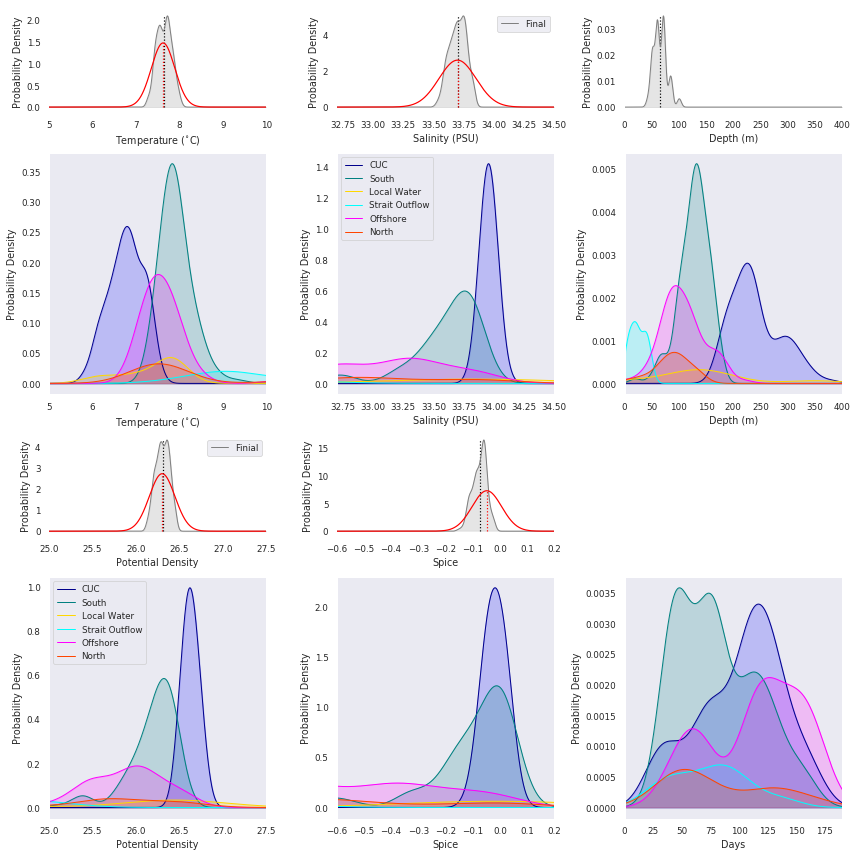

In [43]:
fig = plt.figure(figsize=(12,12))

# fig = plt.figure(figsize=(13,8))

gs2 = gridspec.GridSpec(6, 3)
# gs2.update(left=0.55, right=0.98, hspace=0.05)

# gs2.update(wspace=0.025, hspace=0.05)


ax1 = plt.subplot(gs2[1:3, 0])
ax1_marg = plt.subplot(gs2[0, 0], sharex=ax1, frameon = False)

ax2 = plt.subplot(gs2[4:, 0])
ax2_marg = plt.subplot(gs2[3, 0], sharex=ax2, frameon = False)



ax3 = plt.subplot(gs2[1:3, 1])
ax3_marg = plt.subplot(gs2[0, 1], sharex=ax3, frameon = False)

ax4 = plt.subplot(gs2[4:, 1])
ax4_marg = plt.subplot(gs2[3, 1], sharex=ax4, frameon = False)


ax5 = plt.subplot(gs2[1:3, 2])
ax5_marg = plt.subplot(gs2[0, 2], sharex=ax5, frameon = False)

ax6 = plt.subplot(gs2[4:, 2])
# ax6_marg = plt.subplot(gs2[3, 2], sharex=ax6, frameon = False)


#Temperature
w_cuc, w_south, w_local, w_north, w_juan, w_off, w_init, grid, mu, sigma = calculate_kde(variable='Temperature')


ax1.plot(grid, w_cuc, lw=1, color = 'darkblue', label = "CUC")
ax1.fill_between(grid, w_cuc, lw=1, color  = 'blue', alpha= 0.2)
# ax.vlines(x=np.mean(spic_loc_cuc), color = 'blue',  ymax=np.max(w_cuc), ymin = 0, linestyles='dotted')

ax1.plot(grid, w_south, lw=1, color = 'teal', label = "South")
ax1.fill_between(grid, w_south, color = 'teal',alpha = 0.2)

ax1.plot(grid, w_local, lw=1, color = 'gold', label = "Local Water")
ax1.fill_between(grid, w_local, color = 'gold', alpha= 0.2)
# ax.vlines(x=spic_local, color = 'yellow',  ymax=np.max(w_local), ymin = 0, linestyles='dotted')

ax1.plot(grid, w_juan, lw=1, color = 'cyan', label = "Strait Outflow")
ax1.fill_between(grid, w_juan, color = 'cyan', alpha= 0.2)

ax1.plot(grid, w_off, lw=1, color = 'magenta', label = "Offshore")
ax1.fill_between(grid, w_off, color = 'magenta', alpha= 0.2)

ax1.plot(grid, w_north, lw=1, color = 'orangered', label = "North")
ax1.fill_between(grid, w_north, color = 'orangered', alpha= 0.2)

ax1_marg.plot(grid, w_init, lw=1, color = 'gray', label = "Final")
ax1_marg.fill_between(grid, w_init, color = 'gray', alpha= 0.2)

ax1_marg.vlines(x=np.mean(traj_tem_init), color = 'k', ymax=np.max(w_init), \
                 ymin= 0, linestyles='dotted')

ax1_marg.plot(grid, scipy.stats.norm.pdf(grid, mu, sigma), 'red')
ax1_marg.vlines(x=mu, color = 'red', ymax=np.max(scipy.stats.norm.pdf(grid, mu, sigma)), ymin= 0, linestyles='dotted')
# fig.subplots_adjust(hspace=0)

ax1.set_xlim(5,10)
ax1.set_xlabel('Temperature ($^{\circ}$C)')
ax1.set_ylabel('Probability Density')
# ax1.legend(loc= 'best')

ax1_marg.set_xlim(5,10)
ax1_marg.set_xlabel('Temperature ($^{\circ}$C)')
ax1_marg.set_ylabel('Probability Density')
# ax1_marg.legend(loc= 'best')
# ax1.get_legend().remove()
ax1.grid()


#Salinity
w_cuc, w_south, w_local, w_north, w_juan, w_off, w_init, grid, mu, sigma = calculate_kde(variable='Salinity')


ax3.plot(grid, w_cuc, lw=1, color = 'darkblue', label = "CUC")
ax3.fill_between(grid, w_cuc, lw=1, color  = 'blue', alpha= 0.2)
# ax.vlines(x=np.mean(spic_loc_cuc), color = 'blue',  ymax=np.max(w_cuc), ymin = 0, linestyles='dotted')

ax3.plot(grid, w_south, lw=1, color = 'teal', label = "South")
ax3.fill_between(grid, w_south, color = 'teal',alpha = 0.2)

ax3.plot(grid, w_local, lw=1, color = 'gold', label = "Local Water")
ax3.fill_between(grid, w_local, color = 'gold', alpha= 0.2)
# ax.vlines(x=spic_local, color = 'yellow',  ymax=np.max(w_local), ymin = 0, linestyles='dotted')

ax3.plot(grid, w_juan, lw=1, color = 'cyan', label = "Strait Outflow")
ax3.fill_between(grid, w_juan, color = 'cyan', alpha= 0.2)

ax3.plot(grid, w_off, lw=1, color = 'magenta', label = "Offshore")
ax3.fill_between(grid, w_off, color = 'magenta', alpha= 0.2)

ax3.plot(grid, w_north, lw=1, color = 'orangered', label = "North")
ax3.fill_between(grid, w_north, color = 'orangered', alpha= 0.2)

ax3_marg.plot(grid, w_init, lw=1, color = 'gray', label = "Final")
ax3_marg.fill_between(grid, w_init, color = 'gray', alpha= 0.2)

ax3_marg.vlines(x=np.mean(traj_sal_init), color = 'k', ymax=np.max(w_init), \
                 ymin= 0, linestyles='dotted')

ax3_marg.plot(grid, scipy.stats.norm.pdf(grid, mu, sigma), 'red')
ax3_marg.vlines(x=mu, color = 'red', ymax=np.max(scipy.stats.norm.pdf(grid, mu, sigma)), ymin= 0, linestyles='dotted')
# fig.subplots_adjust(hspace=0)

ax3.set_xlim(32.7,34.5)
ax3.set_xlabel('Salinity (PSU)')
ax3.set_ylabel('Probability Density')
# ax3.get_legend().remove()

ax3_marg.set_xlim(32.7,34.5)
ax3_marg.set_xlabel('Salinity (PSU)')
ax3_marg.set_ylabel('Probability Density')
# ax3_marg.get_legend().remove()
ax3.grid()


#Density
w_cuc, w_south, w_local, w_north, w_juan, w_off, w_init, grid, mu, sigma = calculate_kde(variable='Density')


ax2.plot(grid, w_cuc, lw=1, color = 'darkblue', label = "CUC")
ax2.fill_between(grid, w_cuc, lw=1, color  = 'blue', alpha= 0.2)
# ax.vlines(x=np.mean(spic_loc_cuc), color = 'blue',  ymax=np.max(w_cuc), ymin = 0, linestyles='dotted')

ax2.plot(grid, w_south, lw=1, color = 'teal', label = "South")
ax2.fill_between(grid, w_south, color = 'teal',alpha = 0.2)

ax2.plot(grid, w_local, lw=1, color = 'gold', label = "Local Water")
ax2.fill_between(grid, w_local, color = 'gold', alpha= 0.2)
# ax.vlines(x=spic_local, color = 'yellow',  ymax=np.max(w_local), ymin = 0, linestyles='dotted')

ax2.plot(grid, w_juan, lw=1, color = 'cyan', label = "Strait Outflow")
ax2.fill_between(grid, w_juan, color = 'cyan', alpha= 0.2)

ax2.plot(grid, w_off, lw=1, color = 'magenta', label = "Offshore")
ax2.fill_between(grid, w_off, color = 'magenta', alpha= 0.2)

ax2.plot(grid, w_north, lw=1, color = 'orangered', label = "North")
ax2.fill_between(grid, w_north, color = 'orangered', alpha= 0.2)

ax2_marg.plot(grid, w_init, lw=1, color = 'gray', label = "Finial")
ax2_marg.fill_between(grid, w_init, color = 'gray', alpha= 0.2)

ax2_marg.vlines(x=np.mean(traj_rho_init), color = 'k', ymax=np.max(w_init), \
                 ymin= 0, linestyles='dotted')

ax2_marg.plot(grid, scipy.stats.norm.pdf(grid, mu, sigma), 'red')
ax2_marg.vlines(x=mu, color = 'red', ymax=np.max(scipy.stats.norm.pdf(grid, mu, sigma)), ymin= 0, linestyles='dotted')
# fig.subplots_adjust(hspace=0)

ax2.set_xlim(25,27.5)
ax2.set_xlabel('Potential Density')
ax2.set_ylabel('Probability Density')
# ax3.get_legend().remove()

ax2_marg.set_xlim(25,27.5)
ax2_marg.set_xlabel('Potential Density')
ax2_marg.set_ylabel('Probability Density')
# ax3_marg.get_legend().remove()
ax2.grid()

#Spice
w_cuc, w_south, w_local, w_north, w_juan, w_off, w_init, grid, mu, sigma = calculate_kde(variable='Spice')


ax4.plot(grid, w_cuc, lw=1, color = 'darkblue', label = "CUC")
ax4.fill_between(grid, w_cuc, lw=1, color  = 'blue', alpha= 0.2)
# ax.vlines(x=np.mean(spic_loc_cuc), color = 'blue',  ymax=np.max(w_cuc), ymin = 0, linestyles='dotted')

ax4.plot(grid, w_south, lw=1, color = 'teal', label = "South")
ax4.fill_between(grid, w_south, color = 'teal',alpha = 0.2)

ax4.plot(grid, w_local, lw=1, color = 'gold', label = "Local Water")
ax4.fill_between(grid, w_local, color = 'gold', alpha= 0.2)
# ax.vlines(x=spic_local, color = 'yellow',  ymax=np.max(w_local), ymin = 0, linestyles='dotted')

ax4.plot(grid, w_juan, lw=1, color = 'cyan', label = "Strait Outflow")
ax4.fill_between(grid, w_juan, color = 'cyan', alpha= 0.2)

ax4.plot(grid, w_off, lw=1, color = 'magenta', label = "Offshore")
ax4.fill_between(grid, w_off, color = 'magenta', alpha= 0.2)

ax4.plot(grid, w_north, lw=1, color = 'orangered', label = "North")
ax4.fill_between(grid, w_north, color = 'orangered', alpha= 0.2)

ax4_marg.plot(grid, w_init, lw=1, color = 'gray', label = "Final")
ax4_marg.fill_between(grid, w_init, color = 'gray', alpha= 0.2)

ax4_marg.vlines(x=np.mean(spic_loc_init), color = 'k', ymax=np.max(w_init), \
                 ymin= 0, linestyles='dotted')

ax4_marg.plot(grid, scipy.stats.norm.pdf(grid, mu, sigma), 'red')
ax4_marg.vlines(x=mu, color = 'red', ymax=np.max(scipy.stats.norm.pdf(grid, mu, sigma)), ymin= 0, linestyles='dotted')
# fig.subplots_adjust(hspace=0)

ax4.set_xlim(-0.6,0.2)
ax4.set_xlabel('Spice')
ax4.set_ylabel('Probability Density')
# ax3.get_legend().remove()

ax4_marg.set_xlim(-0.6,0.2)
ax4_marg.set_xlabel('Spice')
ax4_marg.set_ylabel('Probability Density')
# ax3_marg.get_legend().remove()
ax4.grid()



#Depth
w_cuc, w_south, w_local, w_north, w_juan, w_off, w_init, grid = calculate_kde(variable='Depth')


ax5.plot(grid, w_cuc, lw=1, color = 'darkblue', label = "CUC")
ax5.fill_between(grid, w_cuc, lw=1, color  = 'blue', alpha= 0.2)
# ax.vlines(x=np.mean(spic_loc_cuc), color = 'blue',  ymax=np.max(w_cuc), ymin = 0, linestyles='dotted')

ax5.plot(grid, w_south, lw=1, color = 'teal', label = "South")
ax5.fill_between(grid, w_south, color = 'teal',alpha = 0.2)

ax5.plot(grid, w_local, lw=1, color = 'gold', label = "Local Water")
ax5.fill_between(grid, w_local, color = 'gold', alpha= 0.2)
# ax.vlines(x=spic_local, color = 'yellow',  ymax=np.max(w_local), ymin = 0, linestyles='dotted')

ax5.plot(grid, w_juan, lw=1, color = 'cyan', label = "Strait Outflow")
ax5.fill_between(grid, w_juan, color = 'cyan', alpha= 0.2)

ax5.plot(grid, w_off, lw=1, color = 'magenta', label = "Offshore")
ax5.fill_between(grid, w_off, color = 'magenta', alpha= 0.2)

ax5.plot(grid, w_north, lw=1, color = 'orangered', label = "North")
ax5.fill_between(grid, w_north, color = 'orangered', alpha= 0.2)

ax5_marg.plot(grid, w_init, lw=1, color = 'gray', label = "Final")
ax5_marg.fill_between(grid, w_init, color = 'gray', alpha= 0.2)

ax5_marg.vlines(x=np.mean(-traj_depth_init), color = 'k', ymax=np.max(w_init), \
                 ymin= 0, linestyles='dotted')


ax5.set_xlim(0,400)
ax5.set_xlabel('Depth (m)')
ax5.set_ylabel('Probability Density')
# ax3.get_legend().remove()

ax5_marg.set_xlim(0,400)
ax5_marg.set_xlabel('Depth (m)')
ax5_marg.set_ylabel('Probability Density')
# ax3_marg.get_legend().remove()
ax5.grid()

#Days
w_cuc, w_south,  w_north, w_juan, w_off,  grid = calculate_kde(variable='Days')


ax6.plot(grid, w_cuc, lw=1, color = 'darkblue', label = "CUC")
ax6.fill_between(grid, w_cuc, lw=1, color  = 'blue', alpha= 0.2)
# ax.vlines(x=np.mean(spic_loc_cuc), color = 'blue',  ymax=np.max(w_cuc), ymin = 0, linestyles='dotted')

ax6.plot(grid, w_south, lw=1, color = 'teal', label = "South")
ax6.fill_between(grid, w_south, color = 'teal',alpha = 0.2)


ax6.plot(grid, w_juan, lw=1, color = 'cyan', label = "Strait Outflow")
ax6.fill_between(grid, w_juan, color = 'cyan', alpha= 0.2)

ax6.plot(grid, w_off, lw=1, color = 'magenta', label = "Offshore")
ax6.fill_between(grid, w_off, color = 'magenta', alpha= 0.2)

ax6.plot(grid, w_north, lw=1, color = 'orangered', label = "North")
ax6.fill_between(grid, w_north, color = 'orangered', alpha= 0.2)




ax6.set_xlim(0,190)
ax6.set_xlabel('Days')
ax6.set_ylabel('Probability Density')
# ax6.legend(loc = 'best')
# ax3.get_legend().remove()

# ax3_marg.get_legend().remove()
ax6.grid()



ax2.legend(loc = 'best')
ax2_marg.legend(loc = 'best')

ax3.legend(loc = 'best')
ax3_marg.legend(loc = 'best')



gs2.tight_layout(fig=fig,rect=[0, 0, 1, 1], h_pad=0.1)



/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


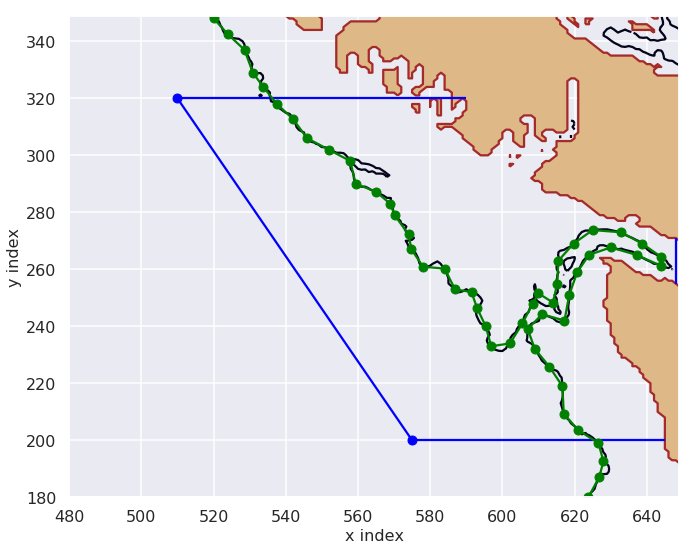

In [30]:



bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

Z = bathy.variables['Bathymetry']


lon = bathy['nav_lon'][...]
lat = bathy['nav_lat'][...]




cmap=plt.cm.get_cmap('nipy_spectral')
#     cmap = plt.cm.get_cmap('gist_rainbow')
cmap.set_bad('#8b7765')
cmin = 0
cmax = 300

import matplotlib as mpl
#     norm = mpl.colors.Normalize(vmin=cmin,vmax=cmax)

fig, ax = plt.subplots(1, 1, figsize=(10,8)); ax.grid()
CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(200,210,10))
# CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], level = [0,100,200,500,1000])
# CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=12)
# CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)




ax.set_xlabel('x index', fontsize =16)
ax.set_ylabel('y index', fontsize = 16)
ax.tick_params(axis='both',labelsize =16)


# ax.set_title('Particle track at depth \u2248 {d:.1f} m'.format(d = np.abs(traj_depth[0,part])), fontsize =16)
ax.legend(loc = 'best')

viz_tools.plot_land_mask(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='burlywood')
viz_tools.plot_coastline(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='brown')

x = [510,575]
y = [320,200]
ax.plot(x, y , 'bo-')

xmin = x_wcvi_slice[np.int(np.min(np.unique(x1)))]-1
xmax = x_wcvi_slice[np.int(np.max(np.unique(x1)))]-1


ymin = y_wcvi_slice[np.int(np.min(np.unique(y1)))]-1
ymax  = y_wcvi_slice[np.int(np.max(np.unique(y1)))]-1


# x_1 = [xmin, xmax]
# y_1 = [ymin, ymin]
# ax.plot(x_1, y_1 , 'go-')

# x_2 = [xmin, xmax]
# y_2 = [ymax, ymax]
# ax.plot(x_2, y_2 , 'go-')

# x_3 = [xmin, xmin]
# y_3 = [ymin, ymax]
# ax.plot(x_3, y_3 , 'go-')

# x_4 = [xmax, xmax]
# y_4 = [ymin, ymax]
# ax.plot(x_4, y_4 , 'go-')

ax.vlines(x = 648, ymin = 255, ymax = 271, color = 'blue')

# ax.get_legend().remove()
# lon_LB08 = -125.4775
# lat_LB08 = 48.4217

# j, i = geo_tools.find_closest_model_point(lon_LB08,lat_LB08,\
#                                           lon,lat,grid='NEMO',tols=\
#                                           {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
#                                            'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}}) 

# ax.scatter(i,j, marker = 'o', c = 'red', s = 300, linewidths=100, label = 'Eddy region')

ax.hlines(y = 200, xmin = 575, xmax=645, color = 'b')
ax.hlines(y = 320, xmin = 510, xmax=590, color = 'b')
ax.grid()

contour = CS.collections[0]
vs = contour.get_paths()[0].vertices


vert = CS.collections[0].get_paths()[0].vertices

x_200_wcvi = vert[:,0]
y_200_wcvi = vert[:,1]

# for i in range(0, len(x_200_wcvi), 10):
#     plt.plot(x_200_wcvi[i:i+1], y_200_wcvi[i:i+1], 'mo-')
    

Line = ax.plot(x_200_wcvi[::10], y_200_wcvi[::10], 'go-')
fig.tight_layout()





In [31]:
IK = find_index(500)

PK = find_index(1000)

LK = find_index(1500)

JK = find_index(2000)

LI = find_index(2500)

LP = find_index(3000)

MN = find_index(3500)

total_indi_high = np.concatenate((IK,PK,LK,JK,LI, LP, MN))

In [32]:
total_indi_high.shape

(939,)

In [33]:
cross_index_high = []


for i in np.unique(total_indi_high):

    if ((np.max(-traj_depth[:,i]) >= 200) & (np.min(-traj_depth[:,i]) < 200)) == True:
        
        cross_index_high = np.append(arr=cross_index_high, values=i)
        


In [34]:
percentage = cross_index_high.shape[0]/final_age_days.shape[0]

print(percentage)

0.36363636363636365


## 36.4 percent of the particles have been upwelled

In [35]:
time_index_high = np.empty_like(cross_index_high)

for k in np.arange(cross_index_high.shape[0]):
    time_index_high[k] = np.min(np.argwhere(-traj_depth[:,cross_index_high[k].astype(int)] > 200))
    
    

In [36]:
np.save(file='/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/numpy_arrays_saved/cross_index_accurate_iso_high_two_more_months.npy', \
        arr=cross_index_high)

np.save(file='/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/numpy_arrays_saved/time_index_accurate_iso_high_two_more_months.npy',\
        arr=time_index_high)


In [50]:
cross_index_high = np.load(file='/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/\
numpy_arrays_saved/cross_index_accurate_iso_high_two_more_months.npy')

time_index_high = np.load(file='/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/numpy_arrays_saved/\
time_index_accurate_iso_high_two_more_months.npy')

In [51]:
x_200_total = np.load(file='/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/numpy_arrays_saved/\
x_200_south_outer_shelf_water_acc_iso_two_more_months.npy')

y_200_total  = np.load(file='/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/numpy_arrays_saved/\
y_200_south_outer_shelf_water_acc_iso_two_more_months.npy')

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


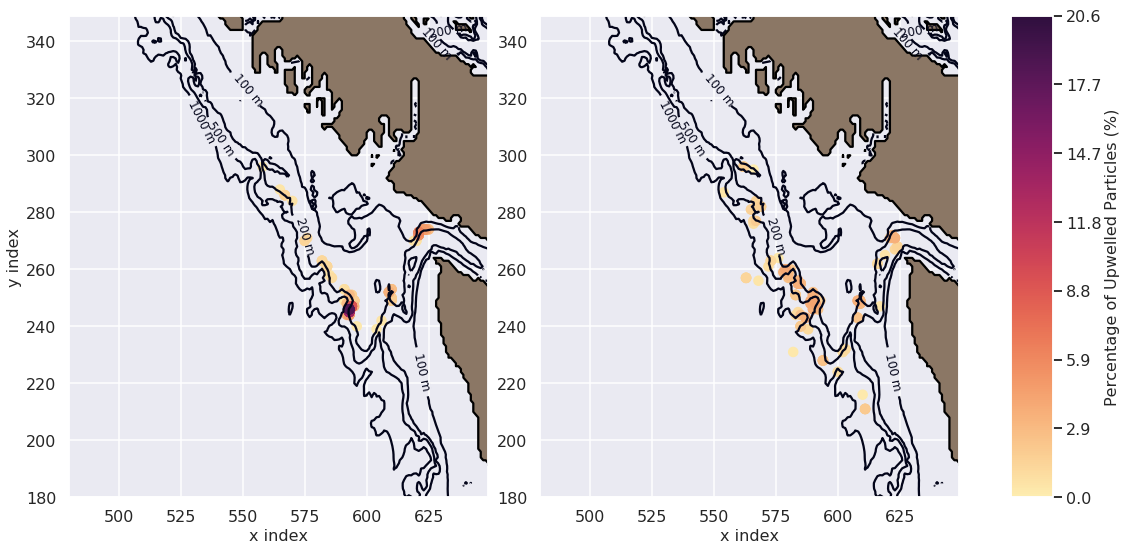

In [53]:
from scipy.interpolate import interpn
from mpl_toolkits.axes_grid1 import make_axes_locatable





cmap = plt.get_cmap(cmo.cm.matter)


bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

Z = bathy.variables['Bathymetry']


lon = bathy['nav_lon'][...]
lat = bathy['nav_lat'][...]




# cmap=plt.cm.get_cmap('nipy_spectral')
# cmap = plt.cm.get_cmap('gist_rainbow_r')
cmap.set_bad('#8b7765')
vmin = 0
vmax = 35

import matplotlib as mpl

gridspec = {'width_ratios': [1, 1, 0.1]}

fig, ax = plt.subplots(1, 3, figsize=(16, 8), gridspec_kw=gridspec)


# fig, (ax1,ax) = plt.subplots(1, 2, figsize=(12,8), sharey=True); 

ax[0].grid()

CS1 = ax[0].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,110,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)


CS1 = ax[0].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(200,210,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

CS1 = ax[0].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(1000,1010,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

CS1 = ax[0].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(500,510,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)



ax[0].set_xlabel('x index', fontsize =16)
ax[0].set_ylabel('y index', fontsize = 16)
ax[0].tick_params(axis='both',labelsize =16)

ax[0].legend(loc = 'best')

viz_tools.plot_land_mask(ax[0], bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='#8b7765')
viz_tools.plot_coastline(ax[0], bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='k')


lon_LB08 = -125.4775
lat_LB08 = 48.4217

j, i = geo_tools.find_closest_model_point(lon_LB08,lat_LB08,\
                                          lon,lat,grid='NEMO',tols=\
                                          {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                           'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}}) 


q = density_scatter(x_200_total[~np.isnan(y_200_total)], y_200_total[~np.isnan(y_200_total)], ax= ax[0], bins = [30,30], cmap = cmap , vmin = vmin, vmax = vmax)

ax[0].grid()


# Line = ax[0].plot(x_200_wcvi[::1], y_200_wcvi[::1], 'k-')



ax[1].grid()


CS1 = ax[1].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,110,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

CS1 = ax[1].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(200,210,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

CS1 = ax[1].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(1000,1010,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

CS1 = ax[1].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(500,510,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)




ax[1].set_xlabel('x index', fontsize =16)
# ax.set_ylabel('y index', fontsize = 16)
ax[1].tick_params(axis='both',labelsize =16)



ax[1].legend(loc = 'best')

viz_tools.plot_land_mask(ax[1], bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='#8b7765')
viz_tools.plot_coastline(ax[1], bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='k')



# ax.vlines(x = 635, ymin = 261, ymax = 279, color = 'blue')

# ax.get_legend().remove()
lon_LB08 = -125.4775
lat_LB08 = 48.4217

j, i = geo_tools.find_closest_model_point(lon_LB08,lat_LB08,\
                                          lon,lat,grid='NEMO',tols=\
                                          {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                           'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}}) 


x_up = []
y_up = []

for k in np.arange(cross_index_high.shape[0]):
    y_p, x_p = geo_tools.find_closest_model_point(traj_lon[time_index_high[k].astype(int), cross_index_high[k].astype(int)],\
                                          traj_lat[time_index_high[k].astype(int), cross_index_high[k].astype(int)],\
                                          lon,lat,grid='NEMO',tols=\
                                          {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                           'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}}) 
    
    y_up = np.append(arr=y_up, values=y_p)
    x_up = np.append(arr=x_up, values=x_p)


q = density_scatter(x_up, y_up, ax= ax[1], bins = [30,30], cmap = cmap , vmin = vmin, vmax = vmax)

ax[1].grid()


# Line = ax[1].plot(x_200_wcvi[::1], y_200_wcvi[::1], 'm-')



m = cm.ScalarMappable(cmap=cmap)
m.set_array(q)
m.set_clim(vmin,vmax)
# plt.colorbar(m, cax=ax[2])

cbar = fig.colorbar(m, cax=ax[2])#, format=ticker.FuncFormatter(fmt))


cbar.ax.set_yticklabels(np.around(a=np.linspace(start=(cbar.vmin/cross_index_high.shape[0])*100, \
                                    stop=(cbar.vmax/cross_index_high.shape[0])*100, num=10), decimals = 1))

cbar.set_label(label='Percentage of Upwelled Particles (%)', fontsize = 16)
cbar.ax.tick_params(labelsize=16)

fig.tight_layout(h_pad=0.01,w_pad=0.01)



(5, 12)

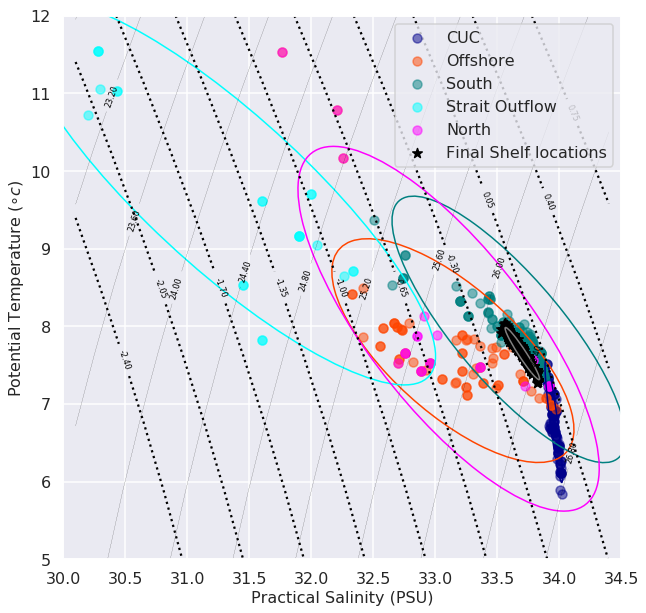

In [53]:
# colors = cmo.cm.phase(np.linspace(0, 1, 200))


# traj_sal_domain = traj_sal[traj_sal != 1.0100000202412861e+20]
# traj_tem_domain = traj_tem[traj_sal != 1.0100000202412861e+20]

# smin = np.nanmin(traj_sal_last)  - (0.01 * np.nanmin(traj_sal_last))
smin = 30
smax = np.nanmax(traj_sal_last)  + (0.01 * np.nanmax(traj_sal_last))
# tmin = np.nanmin(traj_tem_last) - (0.1 * np.nanmax(traj_tem_last))
tmin = 4
tmax = 12
# tmax = np.nanmax(traj_tem_last) + (0.1 * np.nanmax(traj_tem_last))
 
# Calculate how many gridcells we need in the x and y dimensions
xdim = int(round((smax-smin)/0.1+1,0))
ydim = int(round((tmax-tmin)+1,0))
 
# Create empty grid of zeros
dens_1 = np.empty((ydim,xdim))
spic_1 = np.empty((ydim,xdim))
SA = np.empty((xdim))
CT = np.empty((ydim)) 
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(1,ydim-1,ydim)+tmin
si = np.linspace(1,xdim-1,xdim)*0.1+smin
 
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        
        SA[i] = gsw.SA_from_SP(si[i], 0, np.mean(traj_lon), np.mean(traj_lat))

        CT[j] = gsw.CT_from_pt(si[i], ti[j])
        
        dens_1[j,i]=gsw.rho(SA[i],CT[j],0)
        
        spic_1[j,i] = gsw.spiciness0(SA[i],CT[j])
 
# Substract 1000 to convert to sigma-t
dens_1 = dens_1 - 1000;
 
# Plot data ***********************************************
fig1, ax = plt.subplots(1, 1, figsize=(10,10))
CS = ax.contour(si,ti,dens_1, np.arange(22.4,27,0.4), linestyles='dashed', linewidths = 0.2,colors='k')
CS1 = ax.contour(si,ti,spic_1,np.arange(-2.4,1,0.35), linestyles='dotted', colors='k')
plt.clabel(CS, fontsize=8, inline=1, fmt='%0.2f') # Label every second level
plt.clabel(CS1, fontsize=8, inline=1, fmt='%0.2f') # Label every second level



ax.scatter(traj_sal_final_cuc, traj_tem_final_cuc, s=80, alpha=0.5, c = 'darkblue', label = 'CUC')
sal_mean_cuc = np.mean(traj_sal_final_cuc)
tem_mean_cuc = np.mean(traj_tem_final_cuc)
cov_cuc = np.cov(traj_sal_final_cuc, traj_tem_final_cuc)
cuc_ell = get_cov_ellipse(cov_cuc, (sal_mean_cuc, tem_mean_cuc), 2,
                    ec='darkblue', fc = None)
cuc_ell.set_facecolor('none')
ax.add_artist(cuc_ell)




ax.scatter(traj_sal_final_off, traj_tem_final_off, s=80, alpha=0.5, c = 'orangered', label = 'Offshore')
sal_mean_off = np.mean(traj_sal_final_off)
tem_mean_off = np.mean(traj_tem_final_off)
cov_off = np.cov(traj_sal_final_off, traj_tem_final_off)
off_ell = get_cov_ellipse(cov_off, (sal_mean_off, tem_mean_off), 2,
                    ec='orangered', fc = None)
off_ell.set_facecolor('none')
ax.add_artist(off_ell)


traj_tem_final_north = traj_tem_final_north[traj_sal_final_north > 30]
traj_sal_final_north = traj_sal_final_north[traj_sal_final_north > 30]

ax.scatter(traj_sal_final_south, traj_tem_final_south, s=80, alpha=0.5, c= 'Teal', label = 'South')
sal_mean_south = np.mean(traj_sal_final_south)
tem_mean_south = np.mean(traj_tem_final_south)
cov_south = np.cov(traj_sal_final_south, traj_tem_final_south)
south_ell = get_cov_ellipse(cov_south, (sal_mean_south, tem_mean_south), 3,
                    ec='Teal', fc = None)
south_ell.set_facecolor('none')
ax.add_artist(south_ell)




# traj_tem_final_juan = traj_tem_final_juan[traj_sal_final_juan < 32.8]
# traj_sal_final_juan = traj_sal_final_juan[traj_sal_final_juan < 32.8]

ax.scatter(traj_sal_final_juan, traj_tem_final_juan, s=80, alpha=0.5, c = 'cyan', label = 'Strait Outflow')
sal_mean_juan = np.mean(traj_sal_final_juan)
tem_mean_juan = np.mean(traj_tem_final_juan)
cov_juan = np.cov(traj_sal_final_juan, traj_tem_final_juan)
juan_ell = get_cov_ellipse(cov_juan, (sal_mean_juan, tem_mean_juan), 2,
                    fc = None, ec='cyan')
juan_ell.set_facecolor('none')
ax.add_artist(juan_ell)




ax.scatter(traj_sal_final_north, traj_tem_final_north, s=80, alpha=0.5, c = 'Magenta', label = 'North')
sal_mean_north = np.mean(traj_sal_final_north)
tem_mean_north = np.mean(traj_tem_final_north)
cov_north = np.cov(traj_sal_final_north, traj_tem_final_north)
north_ell = get_cov_ellipse(cov_north, (sal_mean_north, tem_mean_north), 2,
                    ec='Magenta', fc = None)
north_ell.set_facecolor('none')
ax.add_artist(north_ell)

# traj_tem_final_local = traj_tem_final_local[traj_sal_final_local > 30]
# traj_sal_final_local = traj_sal_final_local[traj_sal_final_local > 30]

# ax.scatter(traj_sal_final_local, traj_tem_final_local, s=80, alpha=0.5, c = 'Gold', label = 'Local Water')
# sal_mean_local = np.mean(traj_sal_final_local)
# tem_mean_local = np.mean(traj_tem_final_local)
# cov_local = np.cov(traj_sal_final_local, traj_tem_final_local)
# local_ell = get_cov_ellipse(cov_local, (sal_mean_local, tem_mean_local), 2,
#                     ec='Gold', fc = None)
# local_ell.set_facecolor('none')
# ax.add_artist(local_ell)


traj_tem_init = traj_tem_init[traj_sal_init > 30]
traj_sal_init = traj_sal_init[traj_sal_init > 30]

ax.scatter(traj_sal_init, traj_tem_init, s=100, marker='*', c = 'k', label = "Final Shelf locations")#'chartreuse')
sal_mean_init = np.mean(traj_sal_init)
tem_mean_init = np.mean(traj_tem_init)
cov_init = np.cov(traj_sal_init, traj_tem_init)
init_ell = get_cov_ellipse(cov_init, (sal_mean_init, tem_mean_init), 2,
                    ec='gray', fc = None)
init_ell.set_facecolor('none')
ax.add_artist(init_ell)


ax.legend(loc = 'best', fontsize = 16)


 
ax.set_xlabel('Practical Salinity (PSU)', fontsize = 16)
ax.set_ylabel('Potential Temperature ($\circ c$)', fontsize = 16)
ax.tick_params(axis='both',labelsize =16)
ax.set_xlim(30,34.5)
ax.set_ylim(5,12)


# legend = ax.legend(loc='upper right', fancybox=True, framealpha=0.25)